Max DrawDown

In [4]:
import pandas as pd

def calculate_max_drawdown(series):
    # Calcul du sommet historique glissant
    roll_max = series.cummax()
    # Calcul du drawdown quotidien
    drawdown = (series - roll_max) / roll_max
    # Le Maximum Drawdown est le minimum de ces valeurs
    return drawdown.min()

# Chargement de vos données concaténées (ou boucle sur vos fichiers raw)
# Ici, on suppose que vous avez un DataFrame 'df' avec les colonnes 'Date', 'Ticker', 'Close'
mdd_results = df.groupby('Ticker')['Close'].apply(calculate_max_drawdown).sort_values()

print("📈 Maximum Drawdown par action (du plus risqué au moins risqué) :")
print(mdd_results)

NameError: name 'df' is not defined

DOwnload Data

In [56]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import yfinance as yf
import pandas_ta
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')



# --- CONFIGURATION ---
PROJECT_ROOT_ABSOLUTE = "/home/onyxia/work/Gestion-portefeuille/" 
ROOT_DIR = Path(PROJECT_ROOT_ABSOLUTE)
OUTPUT_PATH_FINAL = ROOT_DIR / "data" / "raw"
OUTPUT_PATH_FINAL.mkdir(parents=True, exist_ok=True)


CAC40_TICKERS = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ATO.PA", "CS.PA", "BNP.PA",
    "EN.PA", "CAP.PA", "CA.PA", "DSY.PA", "EL.PA", "ENGI.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "OR.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
    "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA",
    "URW.PA", "VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "FR.PA"
]


end_date = datetime.today().strftime('%Y-%m-%d')  # Ou date fixe '2025-12-25'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)  # 10 ans


print(f" Téléchargement CAC40 Dataset Global")
print(f"   Tickers : {len(CAC40_TICKERS)}")
print(f"   Période : {start_date.date()} → {end_date}")


# --- TÉLÉCHARGEMENT GROUPÉ (comme S&P500) ---
df = yf.download(
    tickers=CAC40_TICKERS,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=True
).stack()

# --- RESTRUCTURATION (comme S&P500) ---
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()


print(f"\n Dataset CAC40 créé !")
print(f"   Shape : {df.shape}")
print(f"   Tickers : {df.index.get_level_values('ticker').nunique()}")
print(f"   Période : {df.index.get_level_values('date').min().date()} → {df.index.get_level_values('date').max().date()}")


# --- APERÇU ---
print("\n Aperçu des données :")
#print(df.head(10000))

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df




[                       0%                       ]

 Téléchargement CAC40 Dataset Global
   Tickers : 40
   Période : 2015-12-30 → 2025-12-27


[*********************100%***********************]  40 of 40 completed



 Dataset CAC40 créé !
   Shape : (100491, 6)
   Tickers : 40
   Période : 2015-12-30 → 2025-12-24

 Aperçu des données :


Price                adj close        close         high          low  \
date       ticker                                                       
2015-12-30 AI.PA     56.584751    69.852806    70.285233    69.719757   
           AIR.PA    54.317242    62.580002    63.130001    62.299999   
           ALO.PA    21.923138    26.032682    26.148590    25.870415   
           ATO.PA  3981.527832  4381.776855  4403.815918  4364.258789   
           BNP.PA    29.987883    52.590000    53.259998    52.480000   
...                        ...          ...          ...          ...   
2025-12-24 TTE.PA    55.610001    55.610001    56.439999    55.610001   
           URW.PA    92.300003    92.300003    92.699997    91.940002   
           VIE.PA    29.280001    29.280001    29.430000    29.270000   
           VIV.PA     2.370000     2.370000     2.375000     2.340000   
           WLN.PA     1.610500     1.610500     1.610500     1.523500   

Price                     open     volume  
date       ticker                          
2015-12-30 AI.PA     70.052391   618018.0  
           AIR.PA    62.740002  1178738.0  
           ALO.PA    25.884323   478709.0  
           ATO.PA  4400.990234     1675.0  
           BNP.PA    53.009998  2358486.0  
...                        ...        ...  
2025-12-24 TTE.PA    56.099998   684693.0  
           URW.PA    91.940002    63307.0  
           VIE.PA    29.290001   251104.0  
           VIV.PA     2.350000   296964.0  
           WLN.PA     1.550500  1429632.0  

[100491 rows x 6 columns]

## Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI: Relative Strength Index if an actif is overbought or oversold
* Bollinger Bands : Side where price is on over-extension .
* ATR : Average True Range : Vol moyenne de prix 
* MACD : Moving Average Convergence Divergence : Momentum


\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [57]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['euro_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                adj close        close         high          low  \
date       ticker                                                       
2015-12-30 AI.PA     56.584751    69.852806    70.285233    69.719757   
           AIR.PA    54.317242    62.580002    63.130001    62.299999   
           ALO.PA    21.923138    26.032682    26.148590    25.870415   
           ATO.PA  3981.527832  4381.776855  4403.815918  4364.258789   
           BNP.PA    29.987883    52.590000    53.259998    52.480000   
...                        ...          ...          ...          ...   
2025-12-24 TTE.PA    55.610001    55.610001    56.439999    55.610001   
           URW.PA    92.300003    92.300003    92.699997    91.940002   
           VIE.PA    29.280001    29.280001    29.430000    29.270000   
           VIV.PA     2.370000     2.370000     2.375000     2.340000   
           WLN.PA     1.610500     1.610500     1.610500     1.523500   

Price                     open     volume  garman_klass_vol        rsi  \
date       ticker                                                        
2015-12-30 AI.PA     70.052391   618018.0         -0.017576        NaN   
           AIR.PA    62.740002  1178738.0         -0.007940        NaN   
           ALO.PA    25.884323   478709.0         -0.010600        NaN   
           ATO.PA  4400.990234     1675.0         -0.003835        NaN   
           BNP.PA    53.009998  2358486.0         -0.125260        NaN   
...                        ...        ...               ...        ...   
2025-12-24 TTE.PA    56.099998   684693.0          0.000080  52.325224   
           URW.PA    91.940002    63307.0          0.000028  56.565110   
           VIE.PA    29.290001   251104.0          0.000015  50.720780   
           VIV.PA     2.350000   296964.0          0.000082  34.984755   
           WLN.PA     1.550500  1429632.0          0.000985  45.707543   

Price                bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2015-12-30 AI.PA        NaN       NaN       NaN       NaN       NaN   
           AIR.PA       NaN       NaN       NaN       NaN       NaN   
           ALO.PA       NaN       NaN       NaN       NaN       NaN   
           ATO.PA       NaN       NaN       NaN       NaN       NaN   
           BNP.PA       NaN       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...   
2025-12-24 TTE.PA  4.020202  4.043818  4.067434 -0.810340  0.002750   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   
           VIE.PA  3.400000  3.411775  3.423549 -0.311504  0.048283   
           VIV.PA  1.185718  1.217092  1.248466 -1.607616 -0.450056   
           WLN.PA  0.825068  0.907297  0.989525 -1.401679 -0.004901   

Price              euro_volume  
date       ticker               
2015-12-30 AI.PA     34.970395  
           AIR.PA    64.025797  
           ALO.PA    10.494803  
           ATO.PA     6.669059  
           BNP.PA    70.726001  
...                        ...  
2025-12-24 TTE.PA    38.075778  
           URW.PA     5.843236  
           VIE.PA     7.352325  
           VIV.PA     0.703805  
           WLN.PA     2.302422  

[100491 rows x 14 columns]

## Aggregate to Monthly level

In [58]:
last_cols = [c for c in df.columns.unique(0) if c not in ['euro_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['euro_volume'].resample('M').mean().stack('ticker').to_frame('euro_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
                  

data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA    102.134199    51.831631         -0.015017  35.772897   
           AIR.PA   153.356179    51.886932         -0.002901  48.662682   
           ALO.PA    26.162160    15.750301         -0.010751  18.685529   
           ATO.PA    28.735082  3453.156250         -0.003053  35.789440   
           BNP.PA   156.458967    24.519476         -0.110281  42.107394   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   192.130961    55.610001          0.000080  52.325224   
           URW.PA    38.162996    92.300003          0.000028  56.565110   
           VIE.PA    45.034985    29.280001          0.000015  50.720780   
           VIV.PA     4.604084     2.370000          0.000082  34.984755   
           WLN.PA     4.842889     1.610500          0.000985  45.707543   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 AI.PA   3.919246  3.948250  3.977255 -0.309620 -0.301802  
           AIR.PA  3.786958  3.874439  3.961920 -0.589468 -0.098058  
           ALO.PA  2.758584  2.863208  2.967832 -0.625607 -1.693032  
           ATO.PA  8.056485  8.124742  8.192999  0.023481 -0.365982  
           BNP.PA  3.115370  3.181806  3.248241  1.089590 -0.705415  
...                     ...       ...       ...       ...       ...  
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.810340  0.002750  
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716  
           VIE.PA  3.400000  3.411775  3.423549 -0.311504  0.048283  
           VIV.PA  1.185718  1.217092  1.248466 -1.607616 -0.450056  
           WLN.PA  0.825068  0.907297  0.989525 -1.401679 -0.004901  

[4614 rows x 9 columns]

- calculate 5-year rolling average of euro-volume for each stock 

In [59]:
data['euro_volume'] = (data.loc[:, 'euro_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['euro_vol_rank'] = (data.groupby('date')['euro_volume'].rank(ascending=False))

#data = data[data['euro_vol_rank']<150].drop(['euro_volume', 'euro_vol_rank'], axis=1)

data 

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA           NaN    51.831631         -0.015017  35.772897   
           AIR.PA          NaN    51.886932         -0.002901  48.662682   
           ALO.PA          NaN    15.750301         -0.010751  18.685529   
           ATO.PA          NaN  3453.156250         -0.003053  35.789440   
           BNP.PA          NaN    24.519476         -0.110281  42.107394   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.982343    55.610001          0.000080  52.325224   
           URW.PA    25.244881    92.300003          0.000028  56.565110   
           VIE.PA    44.776090    29.280001          0.000015  50.720780   
           VIV.PA    28.477882     2.370000          0.000082  34.984755   
           WLN.PA    25.545117     1.610500          0.000985  45.707543   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-02-29 AI.PA   3.919246  3.948250  3.977255 -0.309620 -0.301802   
           AIR.PA  3.786958  3.874439  3.961920 -0.589468 -0.098058   
           ALO.PA  2.758584  2.863208  2.967832 -0.625607 -1.693032   
           ATO.PA  8.056485  8.124742  8.192999  0.023481 -0.365982   
           BNP.PA  3.115370  3.181806  3.248241  1.089590 -0.705415   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.810340  0.002750   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   
           VIE.PA  3.400000  3.411775  3.423549 -0.311504  0.048283   
           VIV.PA  1.185718  1.217092  1.248466 -1.607616 -0.450056   
           WLN.PA  0.825068  0.907297  0.989525 -1.401679 -0.004901   

                   euro_vol_rank  
date       ticker                 
2016-02-29 AI.PA             NaN  
           AIR.PA            NaN  
           ALO.PA            NaN  
           ATO.PA            NaN  
           BNP.PA            NaN  
...                          ...  
2025-12-31 TTE.PA            2.0  
           URW.PA           37.0  
           VIE.PA           25.0  
           VIV.PA           34.0  
           WLN.PA           36.0  

[4614 rows x 10 columns]

## Calculate Monthly Returns for different horizons as features

In [60]:
def calculate_returns(df):
    """
    Calcule les returns avec clipping SANS look-ahead bias
    Utilise expanding quantiles (uniquement le passé)
    """
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        # 1. Calculer les returns bruts
        returns_raw = df['adj close'].pct_change(lag)
        
        # 2. Calculer les quantiles avec expanding window
        # À chaque date, utilise UNIQUEMENT les données passées
        lower_bound = returns_raw.expanding(min_periods=252).quantile(outlier_cutoff)
        upper_bound = returns_raw.expanding(min_periods=252).quantile(1 - outlier_cutoff)
        
        # 3. Clipper avec ces bornes dynamiques
        returns_clipped = returns_raw.clip(lower=lower_bound, upper=upper_bound)
        
        # 4. Annualiser
        df[f'return_{lag}m'] = (
            (1 + returns_clipped)
            .pow(1/lag)
            .sub(1)
        )
    
    return df

# Application
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2017-02-28 AI.PA     75.441250    57.929237         -0.014297  47.545104   
           AIR.PA   108.392801    61.634537         -0.003995  68.219643   
           ALO.PA    18.326209    20.009987         -0.010231  44.279509   
           ATO.PA    23.990370  5828.903320         -0.002527  73.514915   
           BNP.PA   123.070969    32.996243         -0.098947  40.611180   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.982343    55.610001          0.000080  52.325224   
           URW.PA    25.244881    92.300003          0.000028  56.565110   
           VIE.PA    44.776090    29.280001          0.000015  50.720780   
           VIV.PA    28.477882     2.370000          0.000082  34.984755   
           WLN.PA    25.545117     1.610500          0.000985  45.707543   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-02-28 AI.PA   4.044793  4.080779  4.116766 -1.001497 -0.204134   
           AIR.PA  4.015914  4.081975  4.148036 -1.270843  0.299998   
           ALO.PA  3.035079  3.068204  3.101329 -0.953606 -0.228985   
           ATO.PA  8.544137  8.609600  8.675064 -0.040841  0.967092   
           BNP.PA  3.489817  3.556756  3.623696  0.074110 -0.980582   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.810340  0.002750   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   
           VIE.PA  3.400000  3.411775  3.423549 -0.311504  0.048283   
           VIV.PA  1.185718  1.217092  1.248466 -1.607616 -0.450056   
           WLN.PA  0.825068  0.907297  0.989525 -1.401679 -0.004901   

                   euro_vol_rank  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                              
2017-02-28 AI.PA            10.0   0.019000  -0.017908   0.019797   0.010386   
           AIR.PA            5.0   0.104525   0.050295   0.047737   0.048109   
           ALO.PA           31.0  -0.023810  -0.010562   0.000847   0.012994   
           ATO.PA           29.0   0.132095   0.054618   0.045632   0.039823   
           BNP.PA            3.0  -0.068435  -0.045805   0.002125   0.032118   
...                          ...        ...        ...        ...        ...   
2025-12-31 TTE.PA            2.0  -0.020951   0.015268   0.030074   0.013721   
           URW.PA           37.0   0.007422   0.014729   0.010547   0.021710   
           VIE.PA           25.0  -0.000341   0.010935   0.003439  -0.005417   
           VIV.PA           34.0  -0.058029  -0.128720  -0.075361  -0.034680   
           WLN.PA           36.0   0.052614  -0.172336  -0.163352  -0.124858   

                   return_9m  return_12m  
date       ticker                         
2017-02-28 AI.PA    0.008981    0.009312  
           AIR.PA   0.023952    0.014450  
           ALO.PA   0.014205    0.020148  
           ATO.PA   0.035320    0.044594  
           BNP.PA   0.016898    0.025052  
...                      ...         ...  
2025-12-31 TTE.PA  -0.004218    0.008510  
           URW.PA   0.024346    0.024060  
           VIE.PA  -0.004001    0.010211  
           VIV.PA  -0.016665   -0.006825  
           WLN.PA  -0.130306   -0.129259  

[4134 rows x 16 columns]

from IPython.display import Markdown, display

markdown_text = r"""
# Les 5 Facteurs Fama-French - Guide Complet CAC40

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

$$Mkt-RF_t = R_{M,t} - R_{f,t}$$

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites capitalisations - Return des grosses capitalisations

$$SMB_t = \frac{1}{2}(Small\ Value_t + Small\ Growth_t) - \frac{1}{2}(Big\ Value_t + Big\ Growth_t)$$

**Interprétation** : Capte l'effet taille. Historiquement, les petites entreprises surperforment les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value (B/M élevé) - Return des actions growth (B/M faible)

$$HML_t = \frac{1}{2}(Small\ Value_t + Big\ Value_t) - \frac{1}{2}(Small\ Growth_t + Big\ Growth_t)$$

**Book-to-Market** :

$$B/M = \frac{\text{Valeur comptable}}{\text{Capitalisation boursière}}$$

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises très rentables - Return des entreprises peu rentables

$$RMW_t = \frac{1}{2}(Small\ Robust_t + Big\ Robust_t) - \frac{1}{2}(Small\ Weak_t + Big\ Weak_t)$$

**Operating Profitability** :

$$OP = \frac{\text{Revenues} - \text{COGS} - \text{SG\&A} - \text{Interest}}{\text{Book Equity}}$$

**Interprétation** : Entreprises rentables (marges élevées) surperforment les entreprises en difficulté.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des entreprises conservatrices - Return des entreprises agressives

$$CMA_t = \frac{1}{2}(Small\ Conservative_t + Big\ Conservative_t) - \frac{1}{2}(Small\ Aggressive_t + Big\ Aggressive_t)$$

**Asset Growth** :

$$\text{Investment} = \frac{\Delta \text{Total Assets}}{\text{Total Assets}_{t-1}}$$

**Interprétation** : Entreprises qui investissent peu (prudentes) surperforment celles qui investissent massivement.

---

## Modèle Complet Fama-French 5 Facteurs

$$R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,MKT}(Mkt-RF_t) + \beta_{i,SMB}(SMB_t) + \beta_{i,HML}(HML_t) + \beta_{i,RMW}(RMW_t) + \beta_{i,CMA}(CMA_t) + \varepsilon_{i,t}$$

**Où** :
- $R_{i,t} - R_{f,t}$ : Excess return de l'actif i
- $\alpha_i$ : Jensen's alpha (performance anormale)
- $\beta_{i,j}$ : Sensibilité au facteur j
- $\varepsilon_{i,t}$ : Erreur idiosyncratique

---

## Exemple Global : LVMH dans le CAC40

### Données du mois (Octobre 2025)

| Variable | Valeur |
|----------|--------|
| Return LVMH | +3.5% |
| Taux sans risque (RF) | +0.3% |
| Excess return LVMH | +3.2% |
| **Facteurs du mois** | |
| Mkt-RF | +2.0% |
| SMB | +1.5% |
| HML | -1.0% |
| RMW | +2.5% |
| CMA | +1.8% |

### Betas LVMH (estimés sur 60 mois)

| Facteur | Beta | Interprétation |
|---------|------|----------------|
| **Mkt-RF** | 0.95 | Sensibilité légèrement inférieure au marché |
| **SMB** | -0.35 | Grosse capitalisation (négative) |
| **HML** | -0.60 | Growth stock (B/M faible) |
| **RMW** | +0.75 | Très rentable (marges 30%) |
| **CMA** | +0.50 | Conservatrice (croissance organique) |

### Décomposition du Return LVMH

$$R_{LVMH} - R_f = \alpha + \beta_{MKT} \times Mkt-RF + \beta_{SMB} \times SMB + \beta_{HML} \times HML + \beta_{RMW} \times RMW + \beta_{CMA} \times CMA$$

**Calcul détaillé** :

| Composante | Formule | Contribution |
|------------|---------|--------------|
| **Alpha** | α | +0.50% |
| **Market** | 0.95 × 2.0% | +1.90% |
| **Size** | -0.35 × 1.5% | -0.53% |
| **Value** | -0.60 × (-1.0%) | +0.60% |
| **Profitability** | 0.75 × 2.5% | +1.88% |
| **Investment** | 0.50 × 1.8% | +0.90% |
| **TOTAL** | | **+5.25%** |

### Interprétation

**Pourquoi LVMH a monté de +3.5% ce mois ?**

1. ✅ **Marché positif** (+1.90%) : Le CAC40 monte, LVMH suit (β=0.95)
2. ❌ **Désavantage taille** (-0.53%) : Les petites caps surperforment, LVMH pénalisée
3. ✅ **Growth style** (+0.60%) : Les growth stocks surperforment ce mois
4. ✅ **Haute rentabilité** (+1.88%) : LVMH très profitable
5. ✅ **Discipline de capital** (+0.90%) : LVMH investit prudemment
6. ✅ **Alpha positif** (+0.50%) : Performance inexpliquée = talent/marque LVMH

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha

---

## Tableau Récapitulatif des Facteurs

| Facteur | Formule | Qui gagne ? | Performance US (1963-2023) |
|---------|---------|-------------|---------------------------|
| **Mkt-RF** | R_M - R_f | Actions > Obligations | +8.3% annuel |
| **SMB** | Petites - Grosses | Petites caps | +3.2% annuel |
| **HML** | Value - Growth | Value (B/M élevé) | +4.8% annuel |
| **RMW** | Rentables - Faibles | Rentables (OP élevé) | +3.1% annuel |
| **CMA** | Conservatrices - Agressives | Conservatrices | +3.0% annuel |

**Pouvoir explicatif** : Le modèle FF5 explique **94% de la variance** des returns cross-sectionnels.

---

## Application Pratique CAC40

### Exemples de Tickers par Profil

| Profil | Tickers | Caractéristiques |
|--------|---------|------------------|
| **Value Cyclique** | Renault, SocGen | β_HML > 0, β_RMW < 0 |
| **Growth Qualité** | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| **Défensif** | Danone, Sanofi | β_MKT < 1, β_RMW > 0 |
| **Cyclique** | TotalEnergies | β_MKT > 1, β_HML > 0 |

**Référence** : Fama & French (2015), *Journal of Financial Economics*, 116(1), 1-22.
"""

display(Markdown(markdown_text))


# Les 5 Facteurs Fama-French 

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

**Formule** : Mkt-RF = R_marché - R_sans_risque

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites caps - Return des grosses caps

**Formule** : SMB = (Small Value + Small Growth)/2 - (Big Value + Big Growth)/2

**Interprétation** : Les petites entreprises surperforment historiquement les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value - Return des actions growth

**Formule** : HML = (Small Value + Big Value)/2 - (Small Growth + Big Growth)/2

**Book-to-Market** : B/M = Valeur comptable / Capitalisation boursière

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises rentables - Return des faibles

**Formule** : RMW = (Small Robust + Big Robust)/2 - (Small Weak + Big Weak)/2

**Operating Profitability** : OP = (Revenues - COGS - SG&A - Interest) / Book Equity

**Interprétation** : Entreprises rentables (marges élevées) surperforment.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des conservatrices - Return des agressives

**Formule** : CMA = (Small Conservative + Big Conservative)/2 - (Small Aggressive + Big Aggressive)/2

**Asset Growth** : Investment = Δ Total Assets / Total Assets(t-1)

**Interprétation** : Entreprises prudentes surperforment celles qui investissent massivement.

---

## Modèle Complet

**Formule** :

Return(i) - RF = Alpha + β_MKT × Mkt-RF + β_SMB × SMB + β_HML × HML + β_RMW × RMW + β_CMA × CMA + Erreur

**Légende** :
- Return(i) - RF : Excess return de l'actif i
- Alpha : Jensen's alpha (performance anormale)
- β : Sensibilité aux facteurs
- Erreur : Résidu idiosyncratique

---

## Exemple : LVMH (Octobre 2025)

**Données** :
- Return LVMH : +3.5%
- RF : +0.3%
- Excess return : +3.2%

**Facteurs du mois** :
- Mkt-RF : +2.0%
- SMB : +1.5%
- HML : -1.0%
- RMW : +2.5%
- CMA : +1.8%

**Betas LVMH** :
- β_MKT = 0.95 (suit le marché)
- β_SMB = -0.35 (grosse cap)
- β_HML = -0.60 (growth)
- β_RMW = +0.75 (rentable)
- β_CMA = +0.50 (conservatrice)

**Décomposition du return (+3.2%)** :

1. Alpha : +0.50%
2. Market (0.95 × 2.0%) : +1.90%
3. Size (-0.35 × 1.5%) : -0.53%
4. Value (-0.60 × -1.0%) : +0.60%
5. Profitability (0.75 × 2.5%) : +1.88%
6. Investment (0.50 × 1.8%) : +0.90%

**Total prédit : +5.25%** (résidu : -2.05%)

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha (talent).

---

## Résumé des Facteurs

| Facteur | Qui gagne ? | Performance US (1963-2023) |
|---------|-------------|---------------------------|
| Mkt-RF | Actions > Obligations | +8.3% annuel |
| SMB | Petites caps | +3.2% annuel |
| HML | Value (décoté) | +4.8% annuel |
| RMW | Rentables | +3.1% annuel |
| CMA | Conservatrices | +3.0% annuel |

**Pouvoir explicatif : 94% de la variance**

---

## CAC40 : Exemples

| Profil | Tickers | Betas |
|--------|---------|-------|
| Value Cyclique | Renault, SocGen | β_HML > 0 |
| Growth Qualité | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| Défensif | Danone, Sanofi | β_MKT < 1 |
| Cyclique | TotalEnergies | β_MKT > 1 |


In [61]:
import pandas_datareader.data as web

# ============================================
# FAMA-FRENCH 5 FACTORS - EUROPE
# ============================================

# Dataset pour l'Europe
factor_data = web.DataReader('Europe_5_Factors',  
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

# Conversion timestamp
factor_data.index = factor_data.index.to_timestamp()

# Resample mensuel et conversion en décimales
factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

# Join avec tes returns CAC40
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AI.PA   0.0068  0.0003 -0.0260  0.0273 -0.0132   0.019000
           AIR.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.104525
           ALO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.023810
           ATO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.132095
           BNP.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.068435
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           URW.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022088
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[4094 rows x 6 columns]

- Filter out stocks with less than 10 month

In [62]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AI.PA   0.0068  0.0003 -0.0260  0.0273 -0.0132   0.019000
           AIR.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.104525
           ALO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.023810
           ATO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.132095
           BNP.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.068435
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           URW.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022088
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[4094 rows x 6 columns]

- Calcule Rollings Betas

In [63]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-02-28 AI.PA        NaN       NaN       NaN       NaN       NaN
           AIR.PA       NaN       NaN       NaN       NaN       NaN
           ALO.PA       NaN       NaN       NaN       NaN       NaN
           ATO.PA       NaN       NaN       NaN       NaN       NaN
           BNP.PA       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-11-30 TTE.PA  0.428369 -0.782001  1.601549  1.434255  0.892771
           URW.PA  1.083249 -1.084259  0.965836 -0.864154 -1.239270
           VIE.PA  0.705379  0.007384  0.472930 -0.169390  1.127773
           VIV.PA  2.818084 -1.755060 -4.433658  0.496501  8.256088
           WLN.PA -0.478084  3.189253  1.751889 -4.822529 -7.811988

[4094 rows x 5 columns]

- Joining rolling factors data to the main features datafr

In [64]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4114 entries, (Timestamp('2017-02-28 00:00:00'), 'AI.PA') to (Timestamp('2025-12-31 00:00:00'), 'WLN.PA')
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   euro_volume       4114 non-null   float64
 1   garman_klass_vol  4114 non-null   float64
 2   rsi               4114 non-null   float64
 3   bb_low            4114 non-null   float64
 4   bb_mid            4114 non-null   float64
 5   bb_high           4114 non-null   float64
 6   atr               4114 non-null   float64
 7   macd              4114 non-null   float64
 8   euro_vol_rank     4114 non-null   float64
 9   return_1m         4114 non-null   float64
 10  return_2m         4114 non-null   float64
 11  return_3m         4114 non-null   float64
 12  return_6m         4114 non-null   float64
 13  return_9m         4114 non-null   float64
 14  return_12m        4114 non-null   float64
 15  Mkt-RF 

## K-Means Clustering

In [65]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Supprimer cluster si existe
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# Centroids RSI
rsi_centroids = np.array([[30], [45], [55], [70]])

def get_clusters(df):
    if len(df) < 4:
        df['cluster'] = 0
        return df
    
    # Clustering sur RSI
    X_rsi = df[['rsi']].values
    kmeans = KMeans(n_clusters=4, init=rsi_centroids, n_init=1, random_state=0)
    labels = kmeans.fit_predict(X_rsi)
    
    # Réordonner par RSI moyen
    cluster_means = [(i, df.loc[labels==i, 'rsi'].mean() if (labels==i).sum()>0 else 0) for i in range(4)]
    cluster_means.sort(key=lambda x: x[1])
    mapping = {old: new for new, (old, _) in enumerate(cluster_means)}
    
    df['cluster'] = [mapping[l] for l in labels]
    return df

# Appliquer
data = data.dropna(subset=['rsi']).groupby('date', group_keys=False).apply(get_clusters)

data


euro_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-02-28 AI.PA     75.441250         -0.014297  47.545104  4.044793   
           AIR.PA   108.392801         -0.003995  68.219643  4.015914   
           ALO.PA    18.326209         -0.010231  44.279509  3.035079   
           ATO.PA    23.990370         -0.002527  73.514915  8.544137   
           BNP.PA   123.070969         -0.098947  40.611180  3.489817   
...                        ...               ...        ...       ...   
2025-12-31 TEP.PA    31.684711          0.000029  51.298811  4.060225   
           TTE.PA   228.982343          0.000080  52.325224  4.020202   
           VIE.PA    44.776090          0.000015  50.720780  3.400000   
           VIV.PA    28.477882          0.000082  34.984755  1.185718   
           WLN.PA    25.545117          0.000985  45.707543  0.825068   

                     bb_mid   bb_high       atr      macd  euro_vol_rank  \
date       ticker                                                          
2017-02-28 AI.PA   4.080779  4.116766 -1.001497 -0.204134           10.0   
           AIR.PA  4.081975  4.148036 -1.270843  0.299998            5.0   
           ALO.PA  3.068204  3.101329 -0.953606 -0.228985           31.0   
           ATO.PA  8.609600  8.675064 -0.040841  0.967092           29.0   
           BNP.PA  3.556756  3.623696  0.074110 -0.980582            3.0   
...                     ...       ...       ...       ...            ...   
2025-12-31 TEP.PA  4.106204  4.152184 -1.062258  0.083228           33.0   
           TTE.PA  4.043818  4.067434 -0.810340  0.002750            2.0   
           VIE.PA  3.411775  3.423549 -0.311504  0.048283           25.0   
           VIV.PA  1.217092  1.248466 -1.607616 -0.450056           34.0   
           WLN.PA  0.907297  0.989525 -1.401679 -0.004901           36.0   

                   return_1m  ...  return_3m  return_6m  return_9m  \
date       ticker             ...                                    
2017-02-28 AI.PA    0.019000  ...   0.019797   0.010386   0.008981   
           AIR.PA   0.104525  ...   0.047737   0.048109   0.023952   
           ALO.PA  -0.023810  ...   0.000847   0.012994   0.014205   
           ATO.PA   0.132095  ...   0.045632   0.039823   0.035320   
           BNP.PA  -0.068435  ...   0.002125   0.032118   0.016898   
...                      ...  ...        ...        ...        ...   
2025-12-31 TEP.PA   0.029710  ...  -0.012469  -0.048729  -0.040185   
           TTE.PA  -0.020951  ...   0.030074   0.013721  -0.004218   
           VIE.PA  -0.000341  ...   0.003439  -0.005417  -0.004001   
           VIV.PA  -0.058029  ...  -0.075361  -0.034680  -0.016665   
           WLN.PA   0.052614  ...  -0.163352  -0.124858  -0.130306   

                   return_12m     Mkt-RF        SMB        HML         RMW  \
date       ticker                                                            
2017-02-28 AI.PA     0.009312   0.797132  -0.897757  -0.230160    0.008552   
           AIR.PA    0.014450   1.213502   0.234013   0.790680    0.365088   
           ALO.PA    0.020148   1.083377   0.422132  -0.292859   -1.904585   
           ATO.PA    0.044594 -40.958313 -16.637934 -19.323055 -109.892297   
           BNP.PA    0.025052   1.269606  -0.082797   1.492590   -1.276752   
...                       ...        ...        ...        ...         ...   
2025-12-31 TEP.PA   -0.021631   0.787280   0.918863  -0.614019    0.131673   
           TTE.PA    0.008510   0.793285  -1.128335   1.168165   -0.083105   
           VIE.PA    0.010211   0.852213   0.053280   0.289508    0.209073   
           VIV.PA   -0.006825   1.042134   0.029370  -0.314974    0.376704   
           WLN.PA   -0.129259   1.117610   0.883478  -0.405449   -1.835663   

                         CMA  cluster  
date       ticker                      
2017-02-28 AI.PA    0.436598        0  
           AIR.PA  -0.032609      

In [66]:
# Afficher quelques valeurs
last_date = data.index.get_level_values('date').max()
print(data.xs(last_date, level='date')[['euro_volume', 'rsi', 'cluster']].head(100))

# Exemple résultat attendu :
#              euro_volume    rsi  cluster
# ticker                                  
# MC.PA         245.3       68.2      3    ← LVMH : 245M€ volume
# AI.PA          12.5       35.1      0    ← Air Liquide : 12.5M€
# BNP.PA        180.7       52.3      2    ← BNP : 180M€


          euro_volume        rsi  cluster
ticker                                   
AI.PA      104.267476  36.140373        0
AIR.PA     151.946650  46.530251        1
ALO.PA      34.418294  63.503710        3
ATO.PA      18.033114  46.116951        1
BNP.PA     153.870977  68.136178        3
CA.PA       34.023720  64.167804        3
CAP.PA      62.005322  54.425953        2
CS.PA      113.728383  65.868915        3
DG.PA       89.685823  50.383416        2
DSY.PA      50.614048  42.192231        1
EL.PA       91.369166  29.859534        0
EN.PA       26.857563  64.762593        3
ENGI.PA     65.307113  63.399260        3
ERF.PA      24.260424  61.621602        3
FR.PA       16.963678  50.924369        2
GLE.PA      88.023011  71.921470        3
HO.PA       40.115143  45.775856        1
KER.PA      91.955286  52.160859        2
LR.PA       44.710779  44.548564        1
MC.PA      258.543585  57.437204        2
ML.PA       45.190674  45.991322        1
MT.AS       87.229360  62.526394  

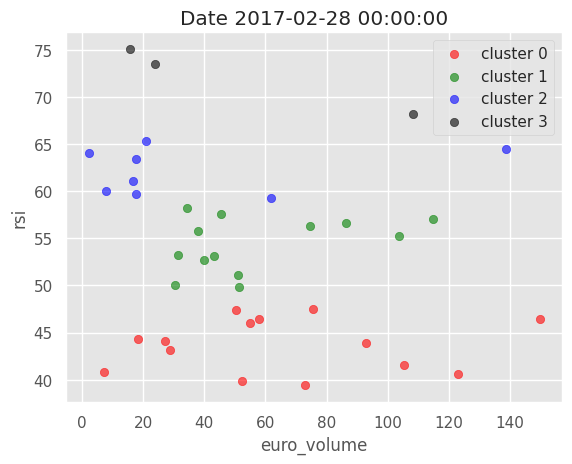

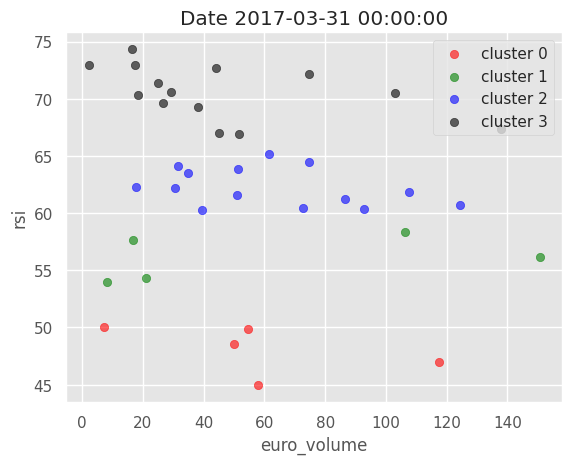

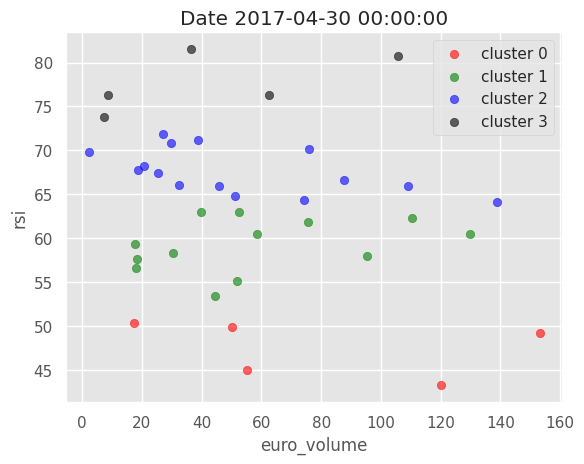

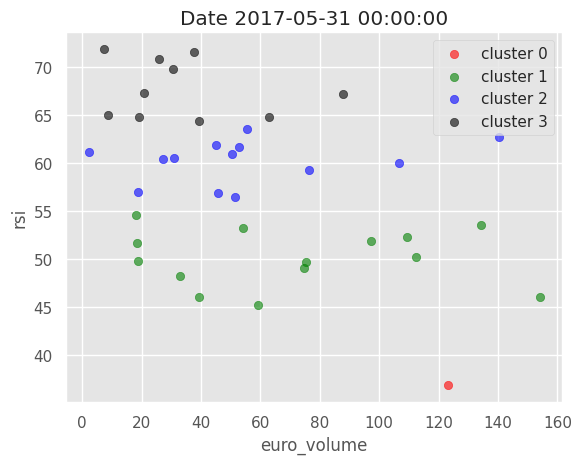

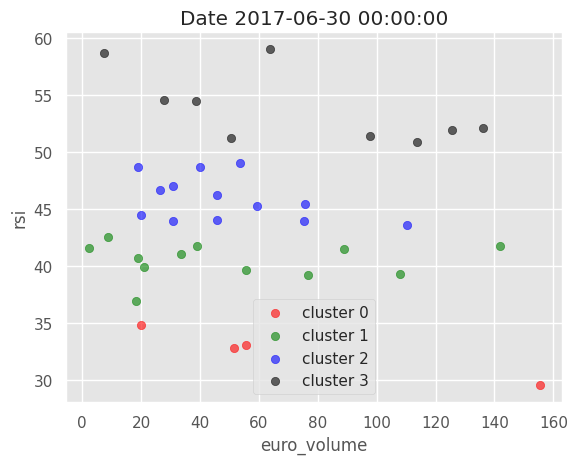

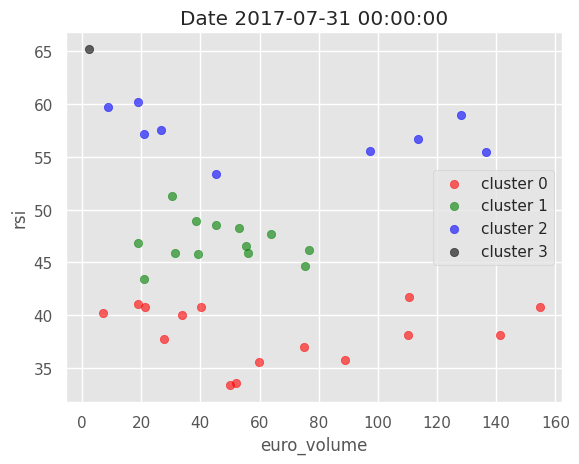

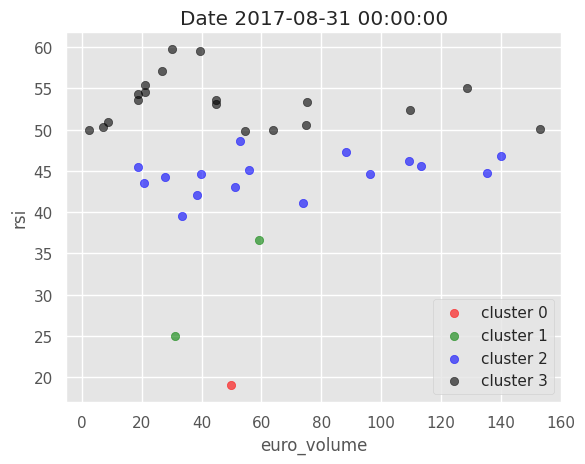

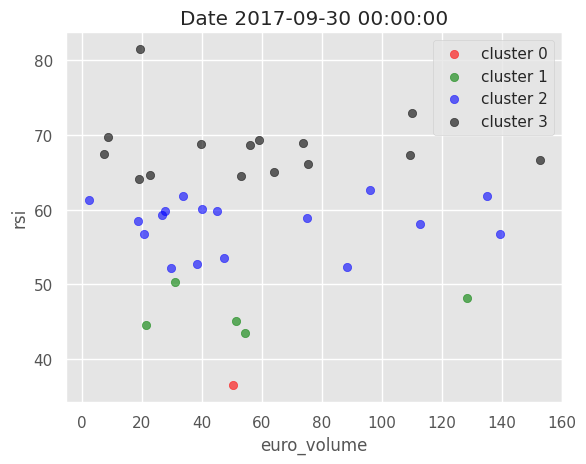

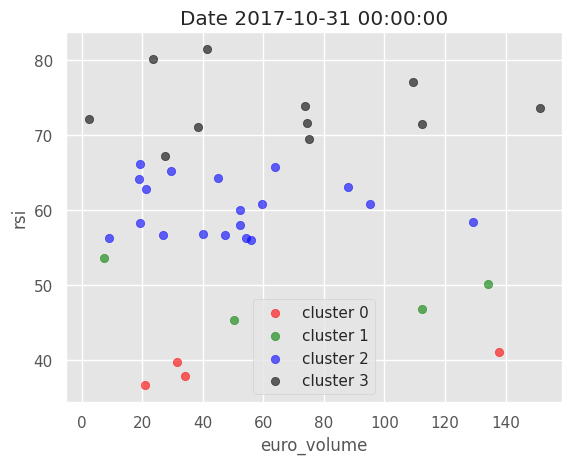

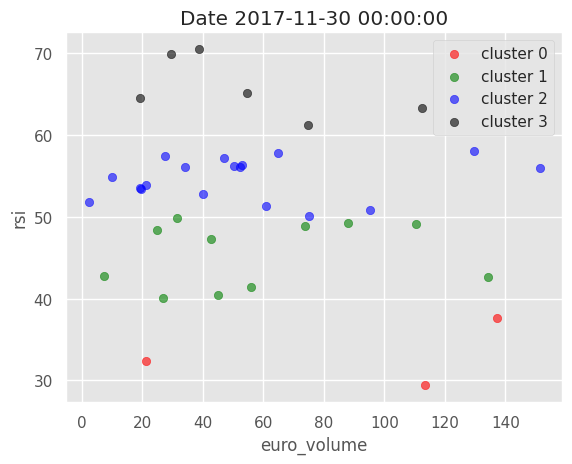

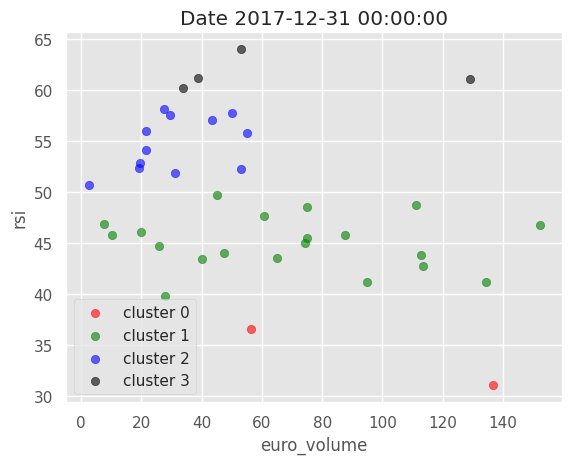

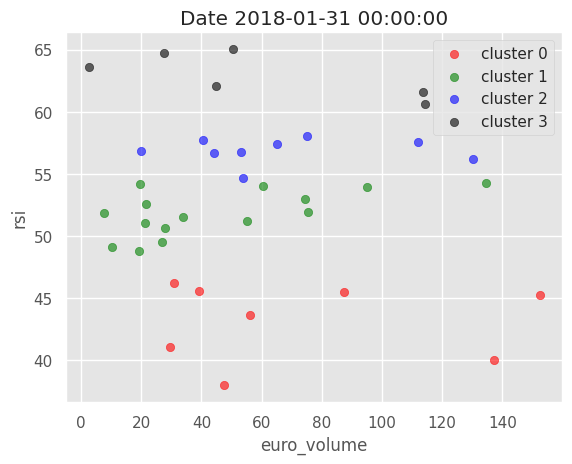

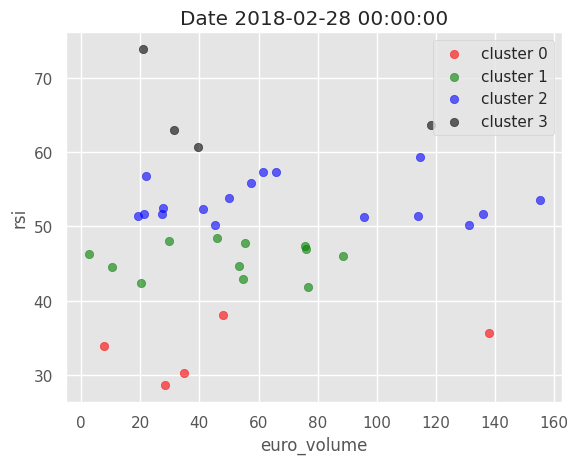

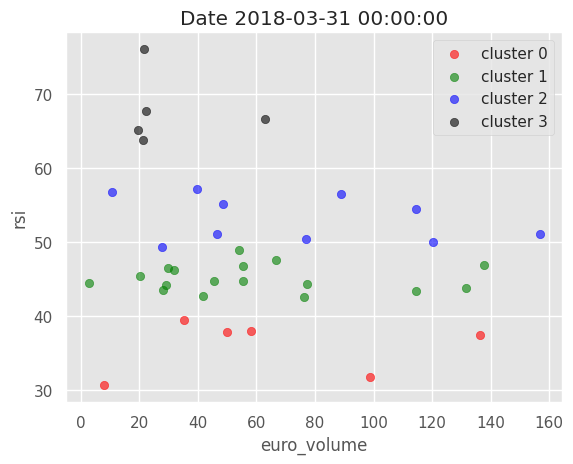

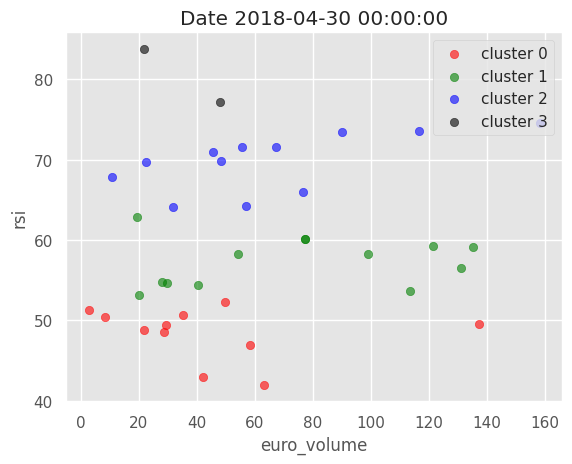

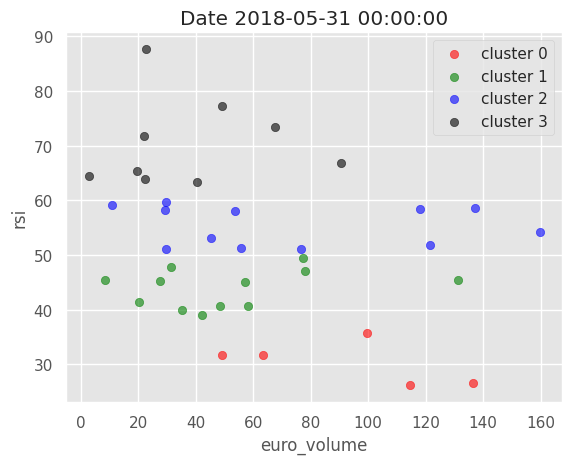

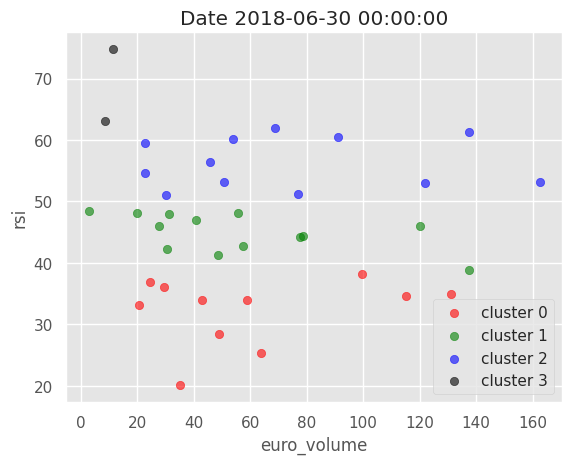

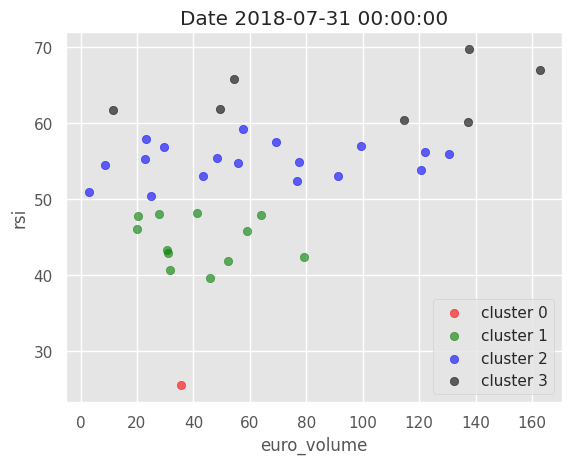

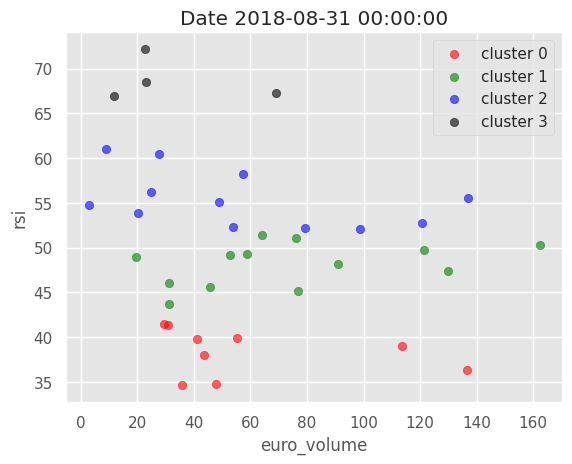

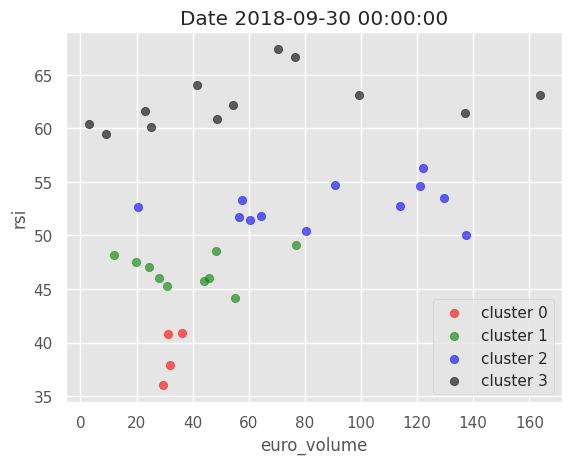

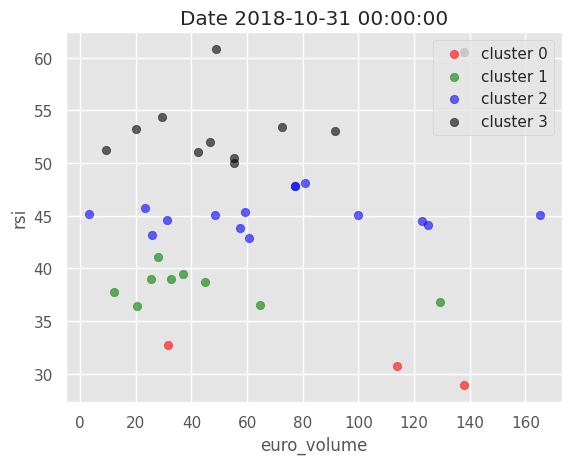

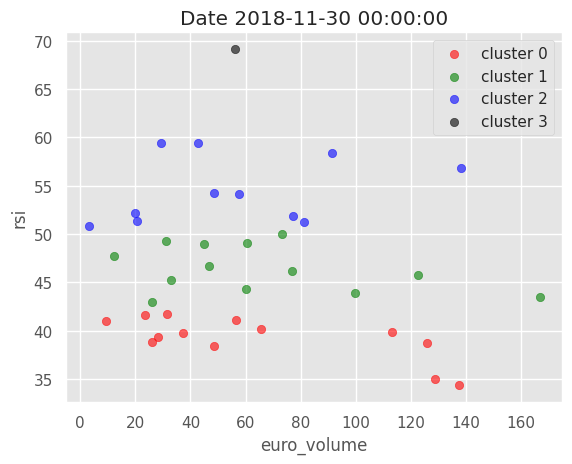

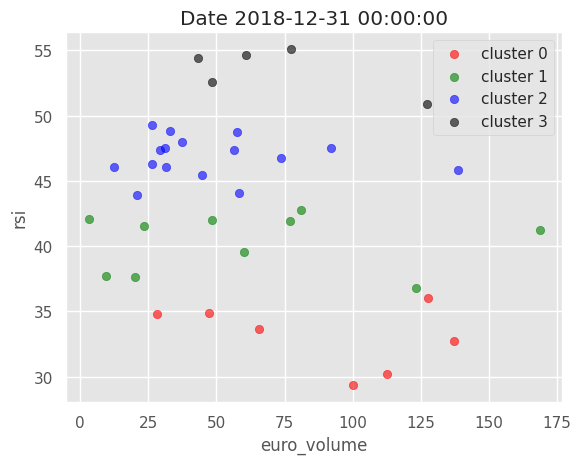

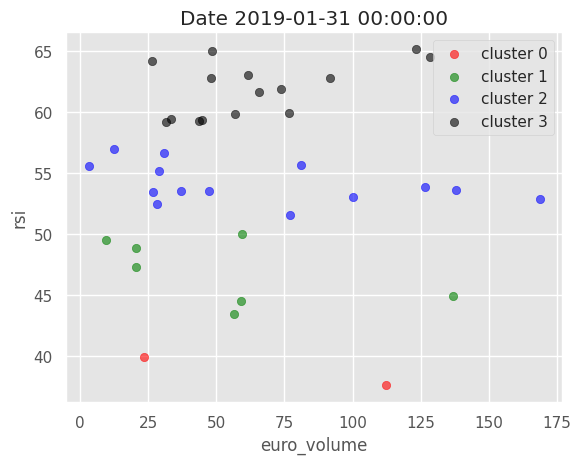

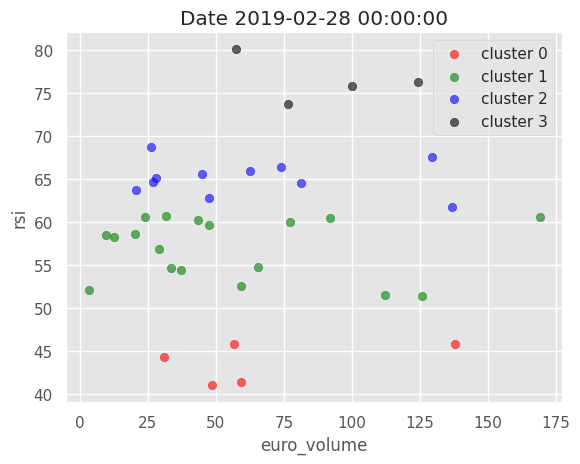

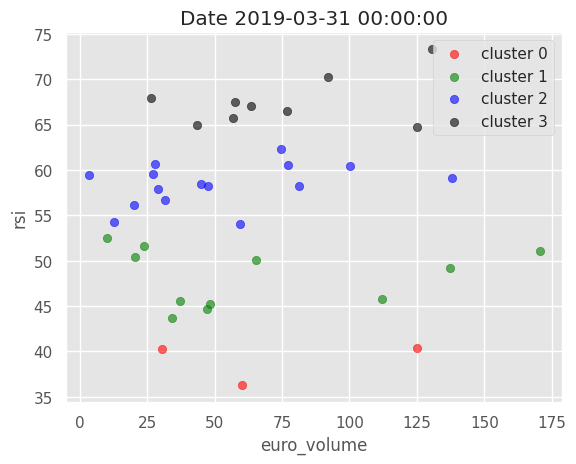

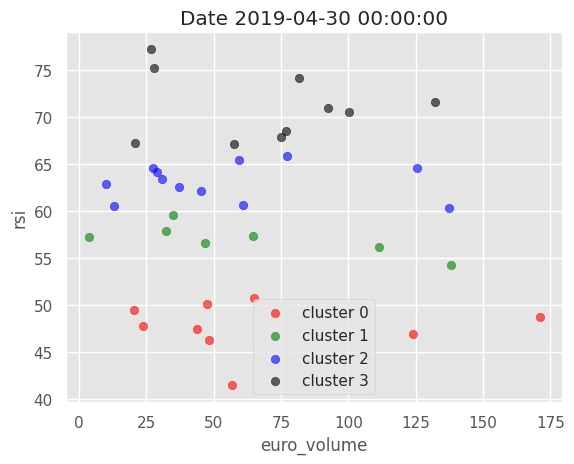

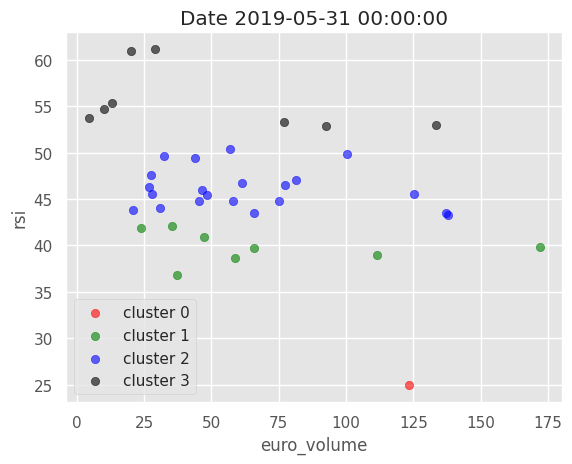

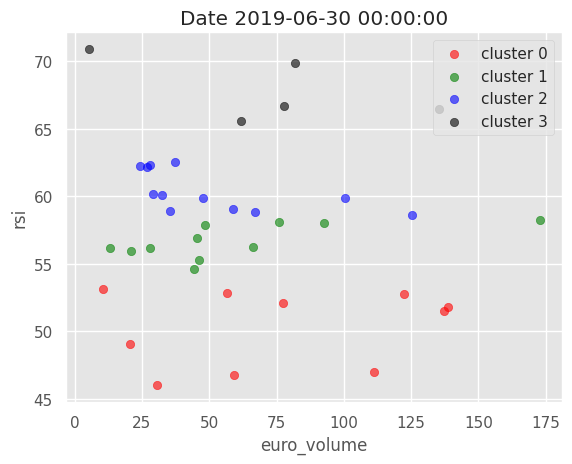

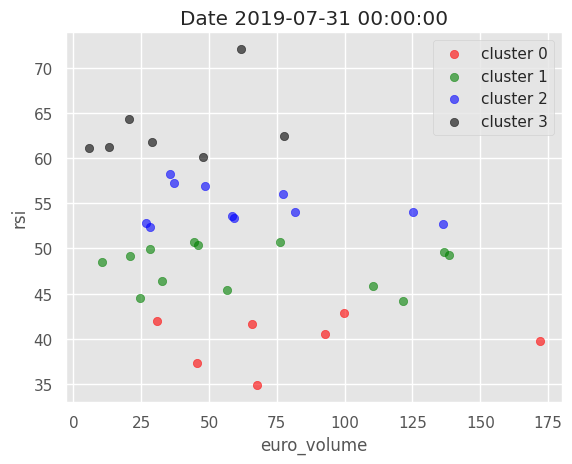

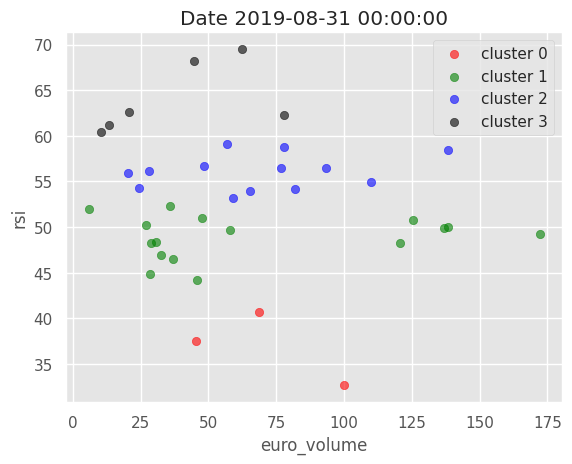

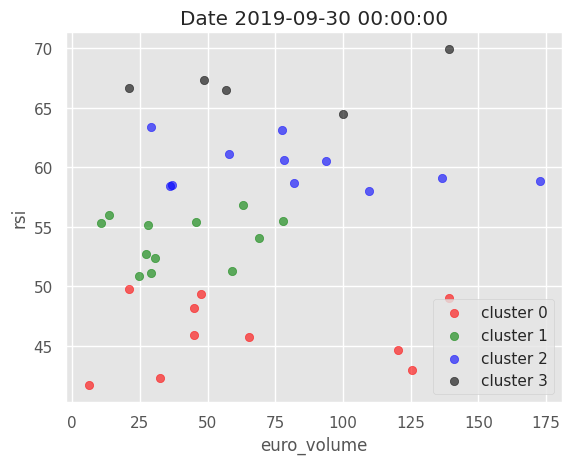

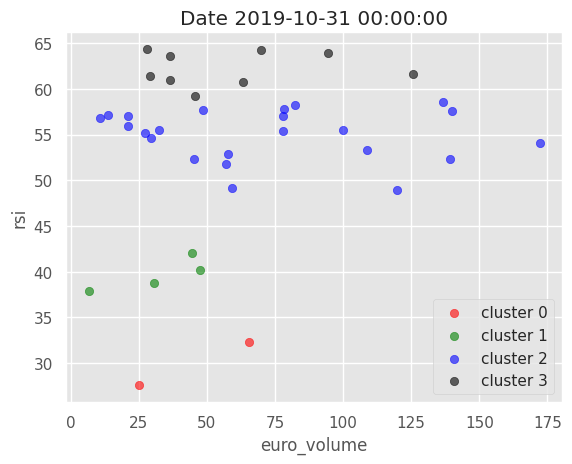

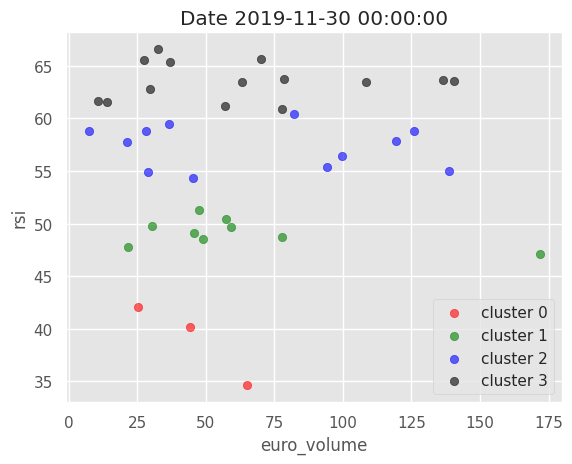

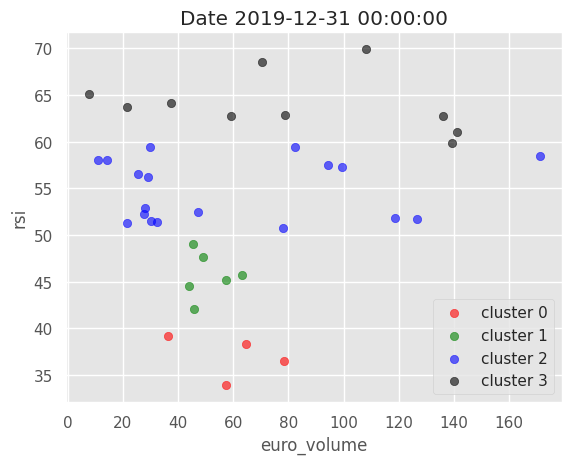

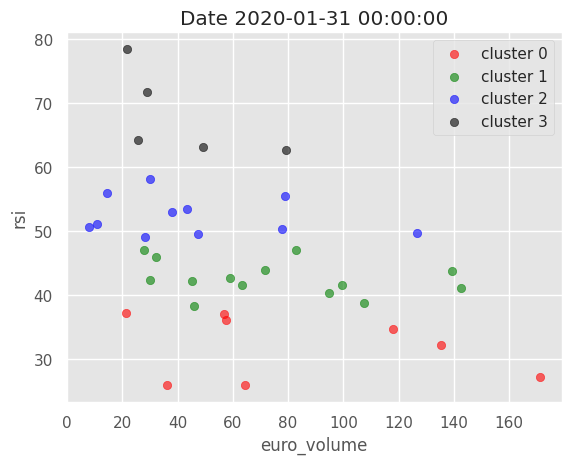

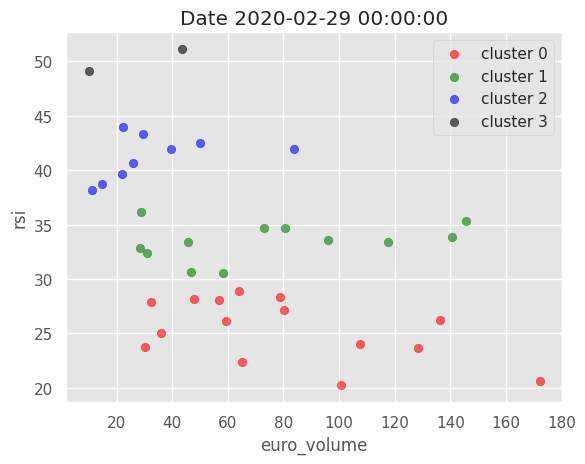

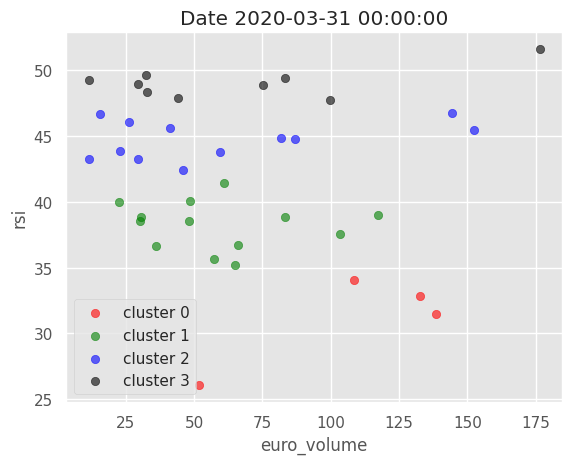

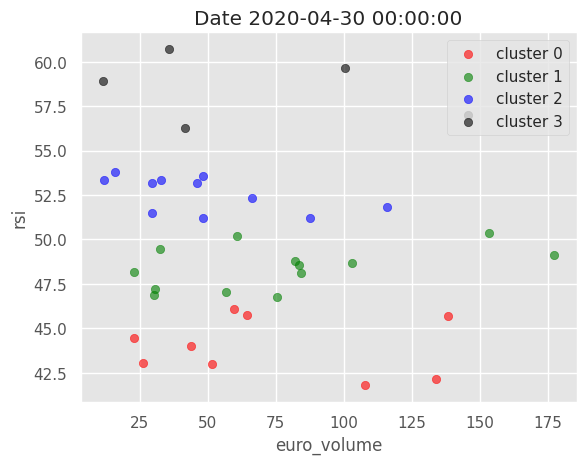

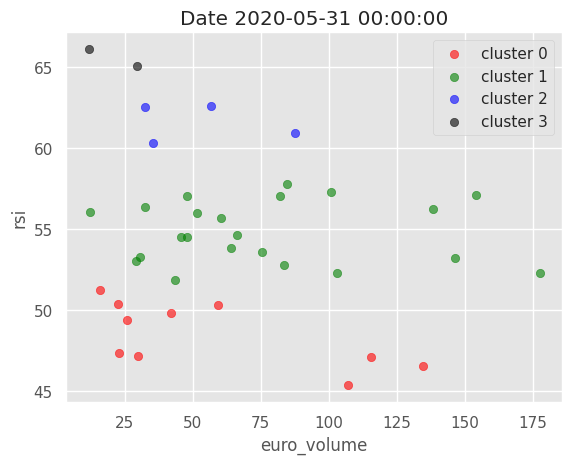

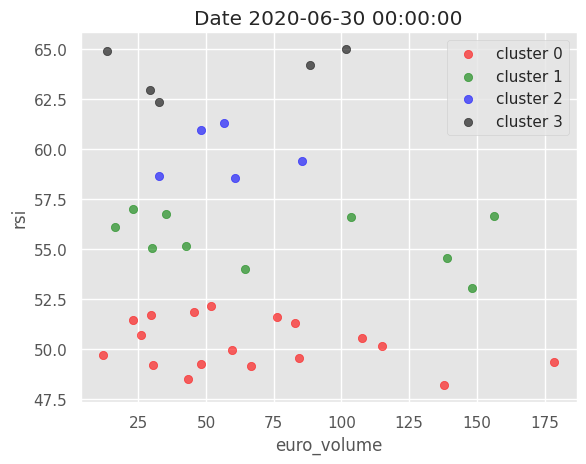

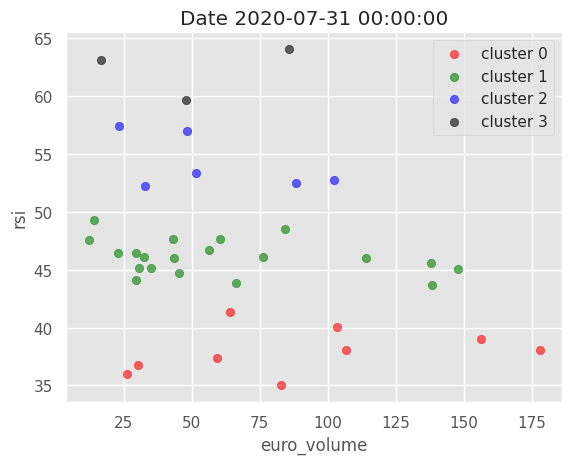

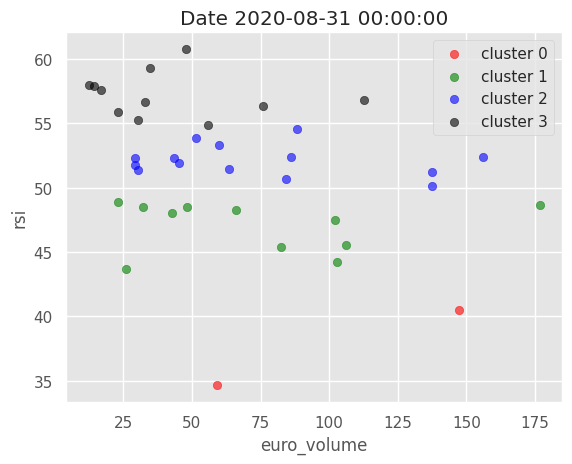

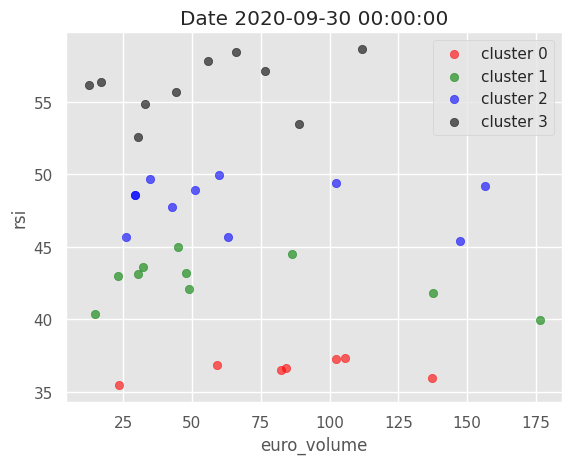

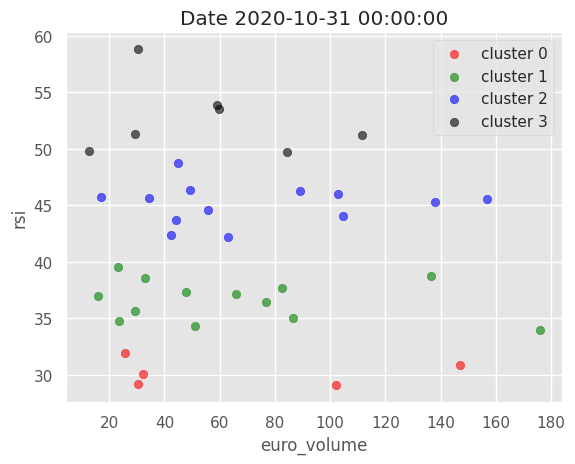

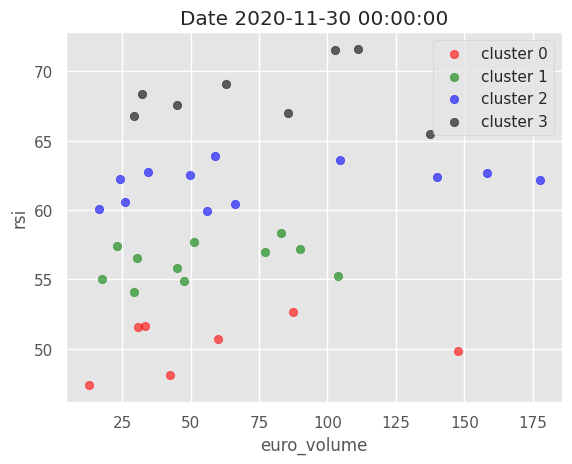

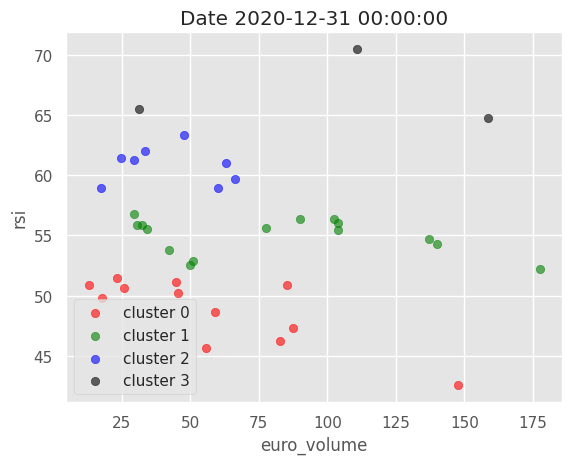

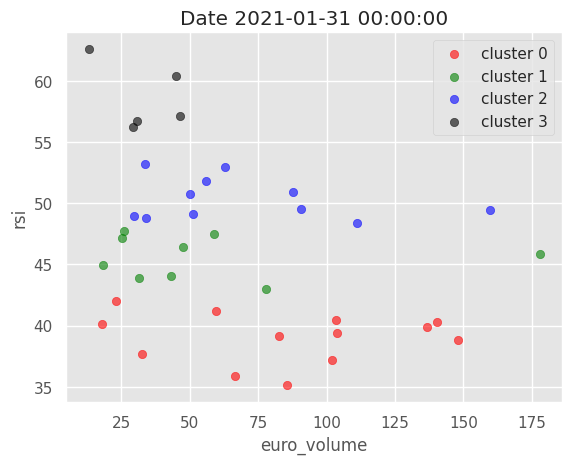

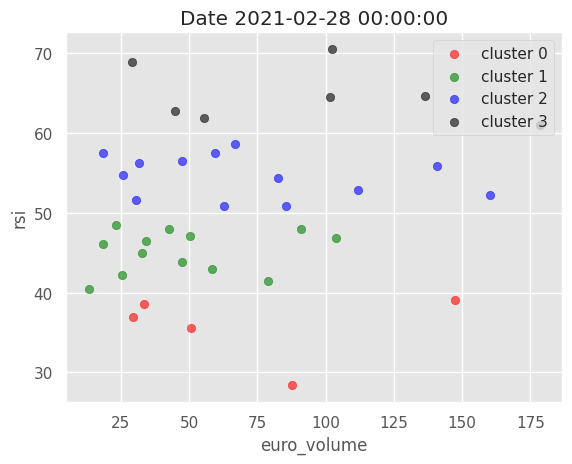

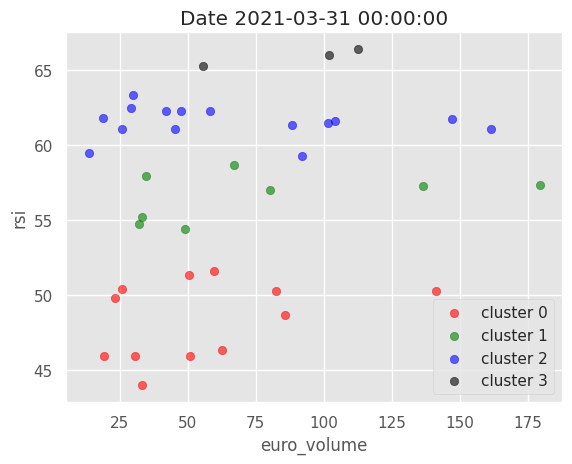

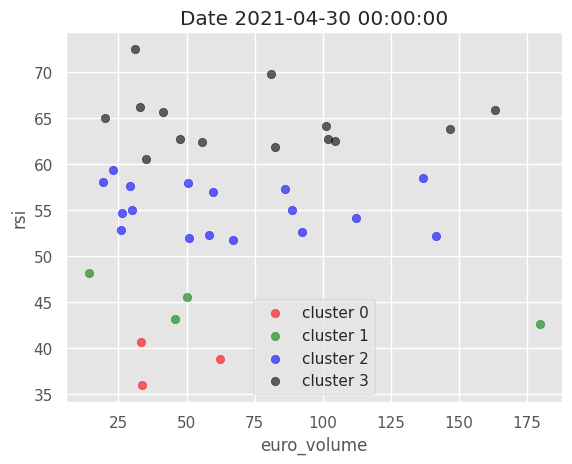

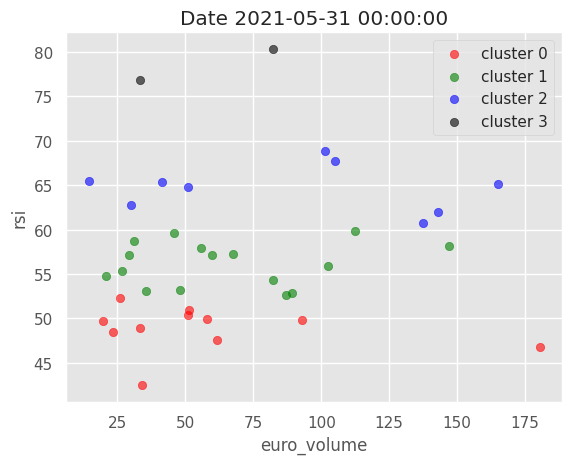

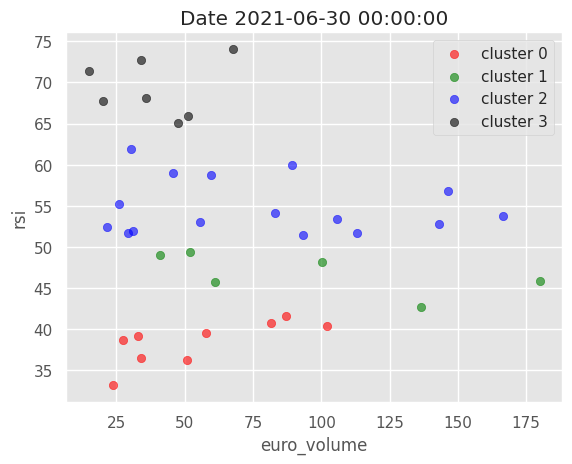

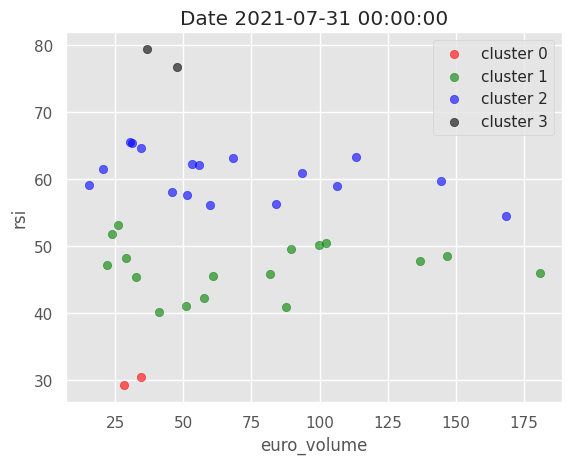

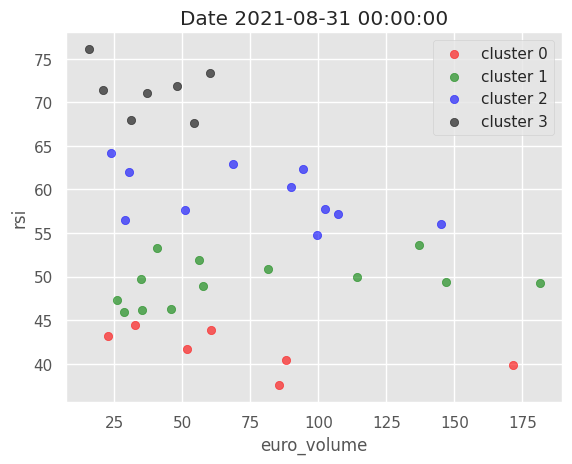

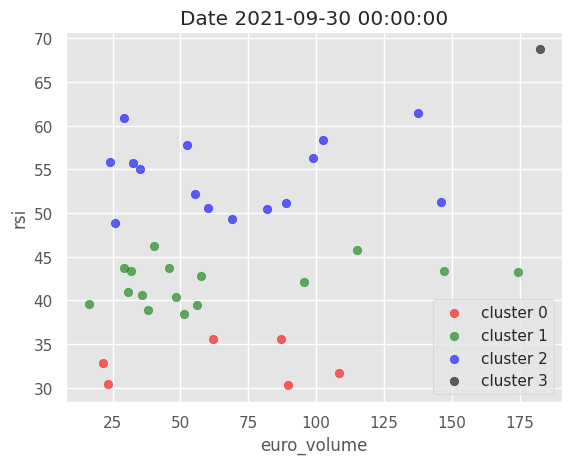

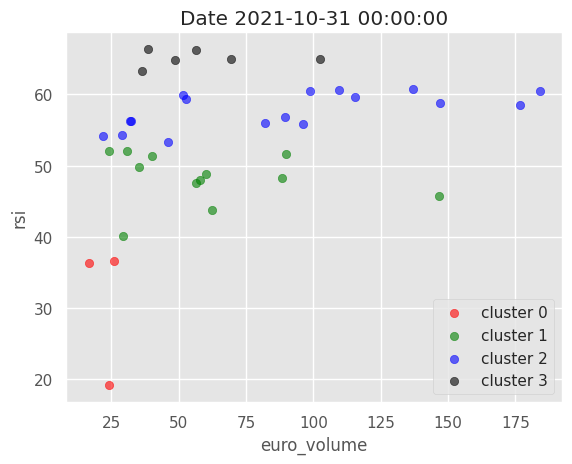

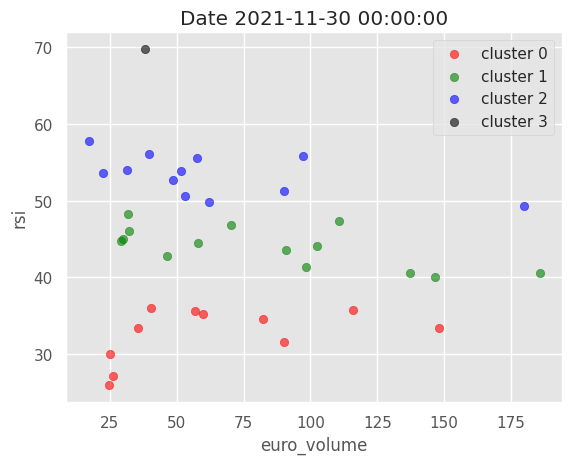

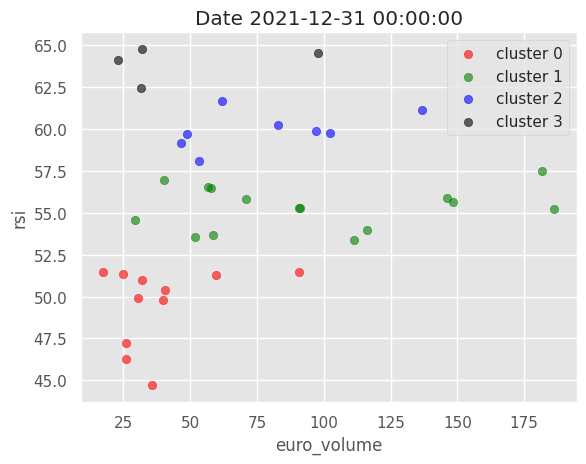

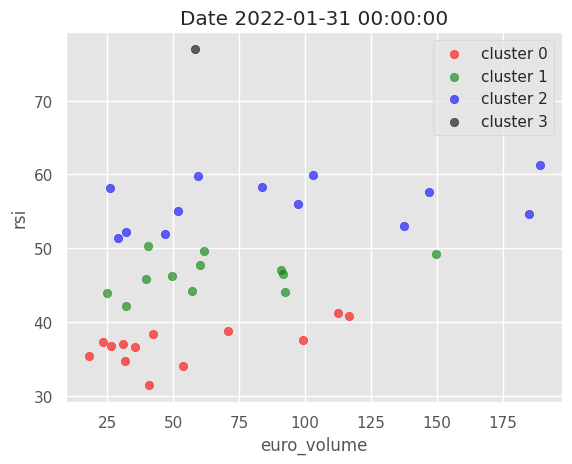

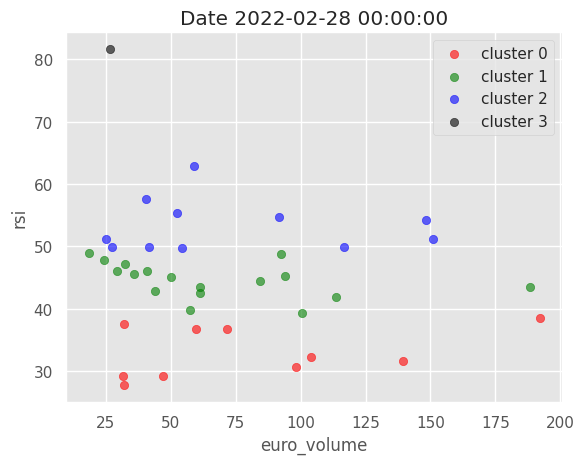

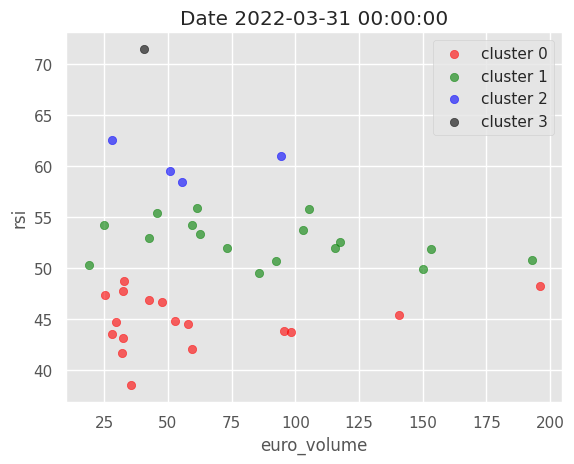

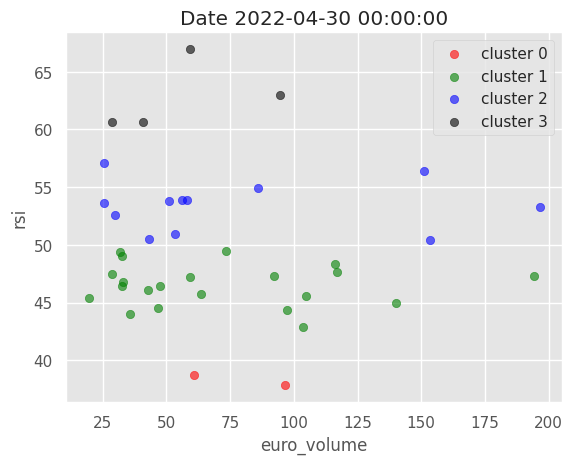

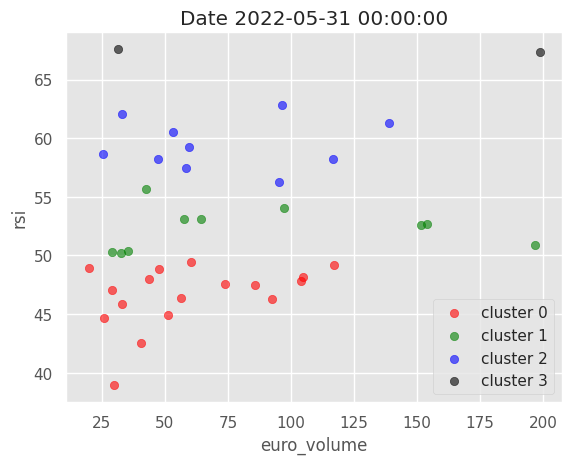

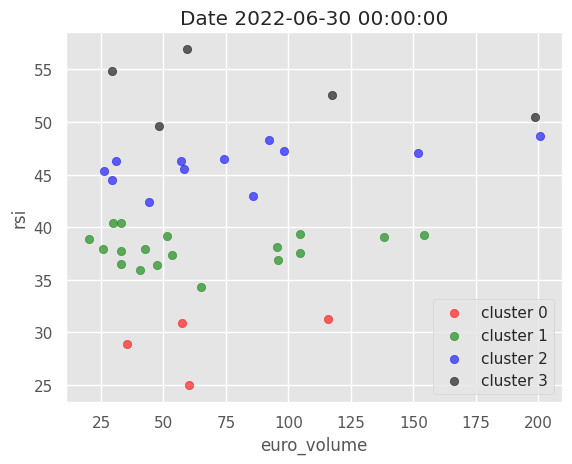

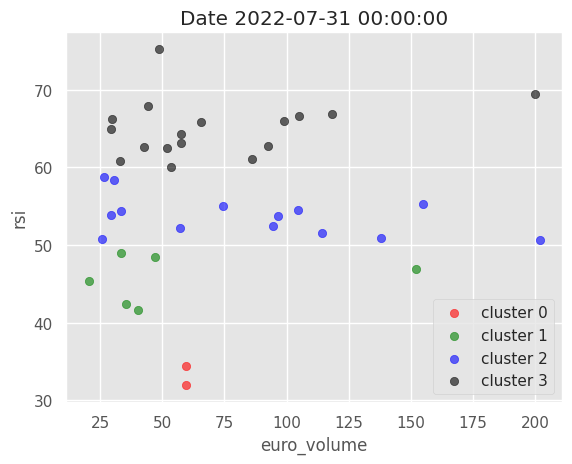

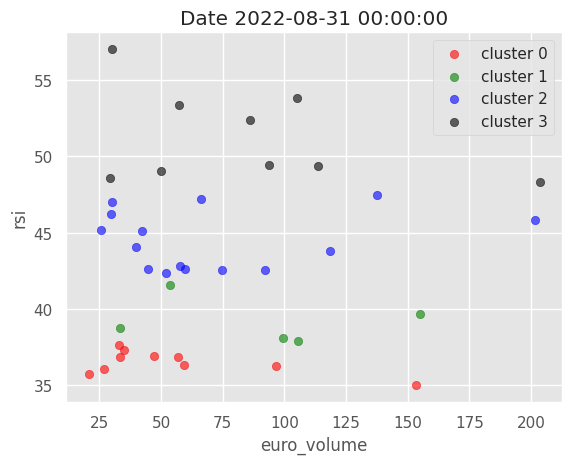

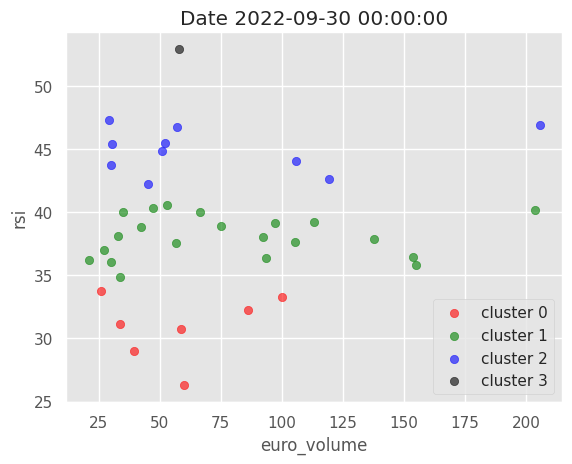

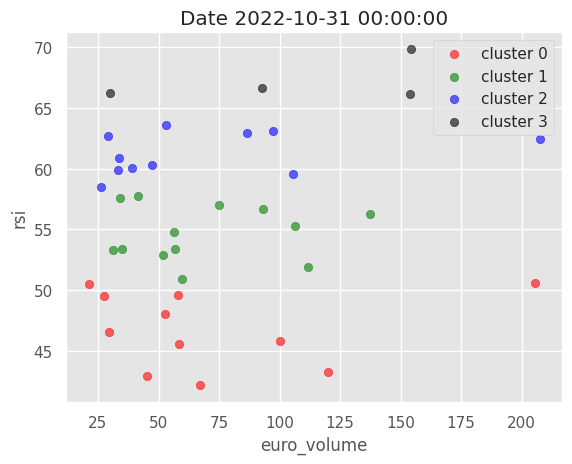

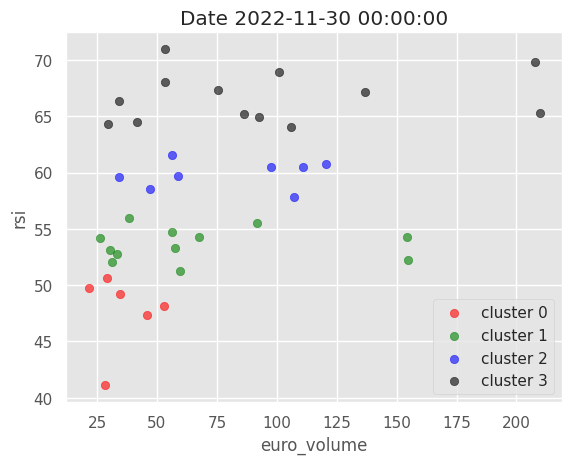

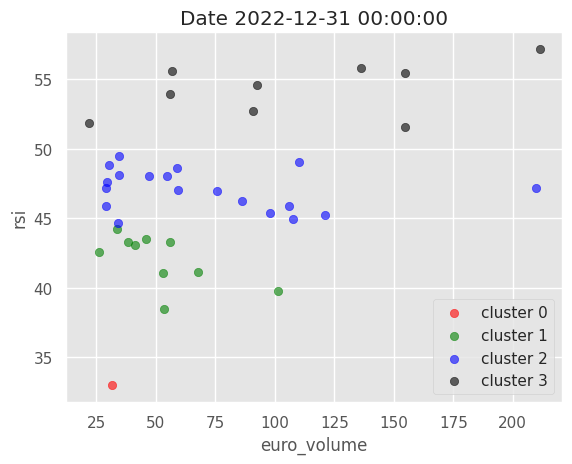

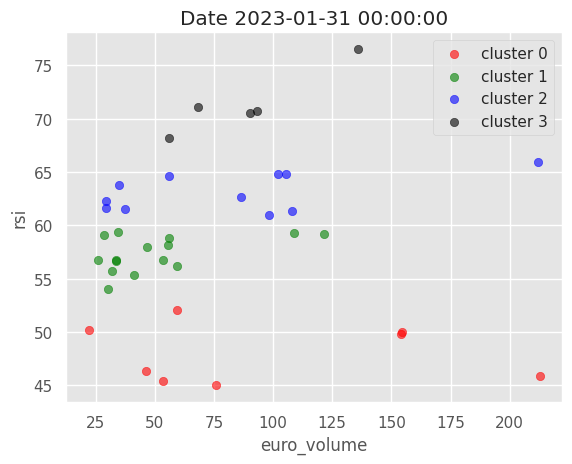

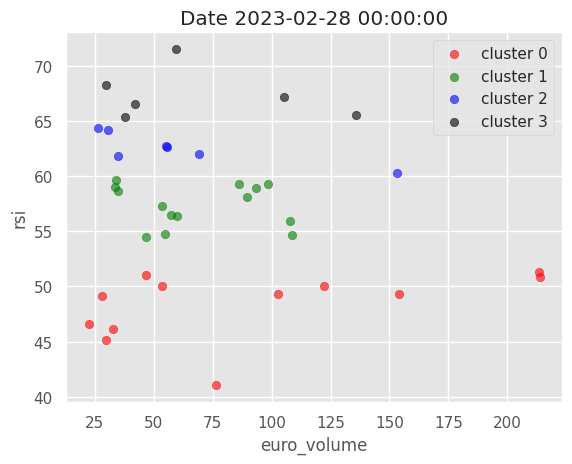

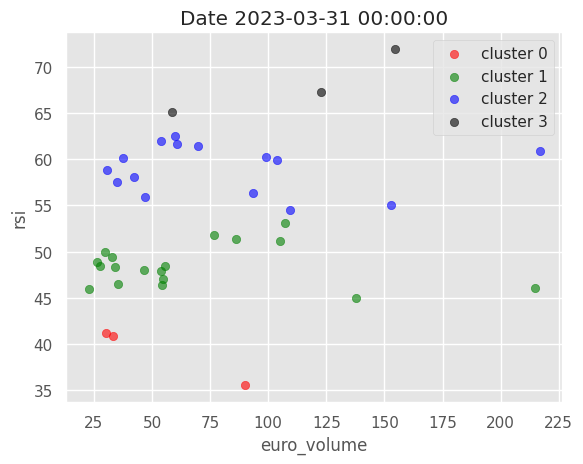

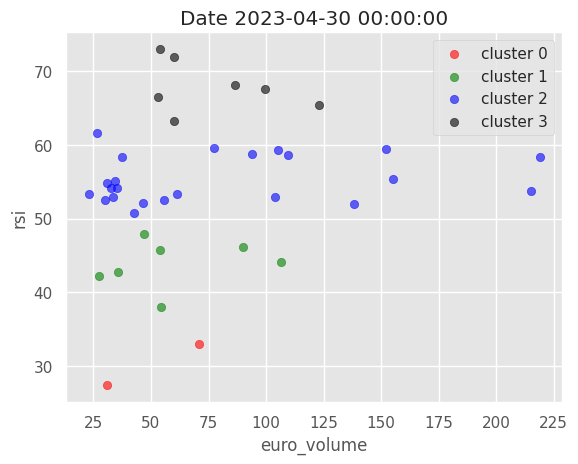

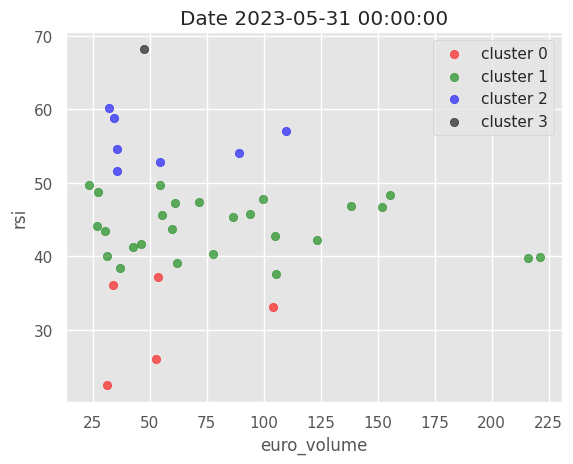

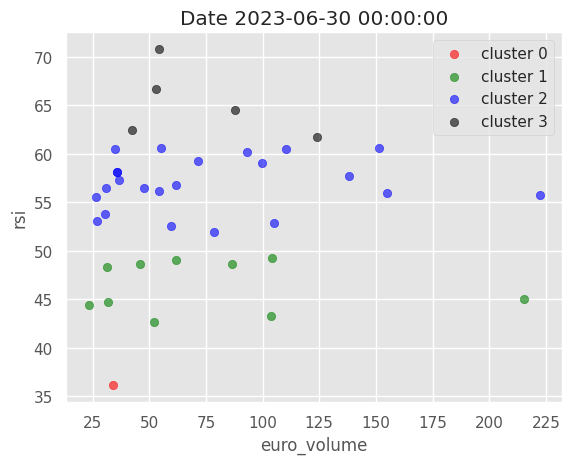

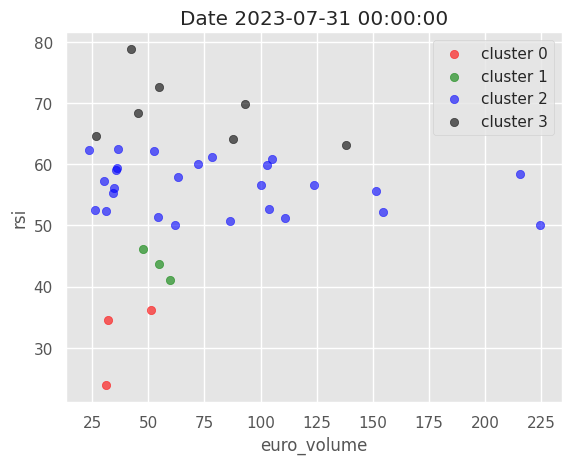

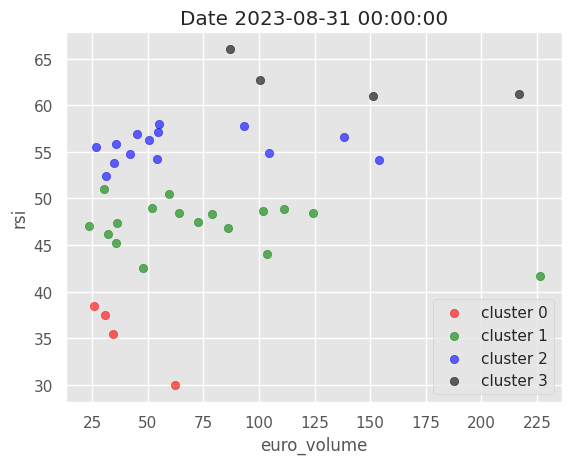

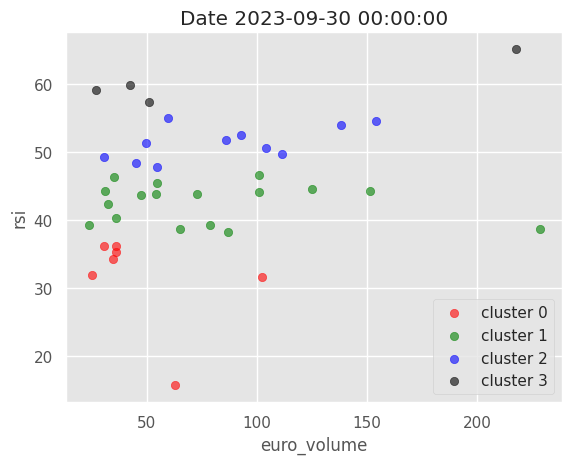

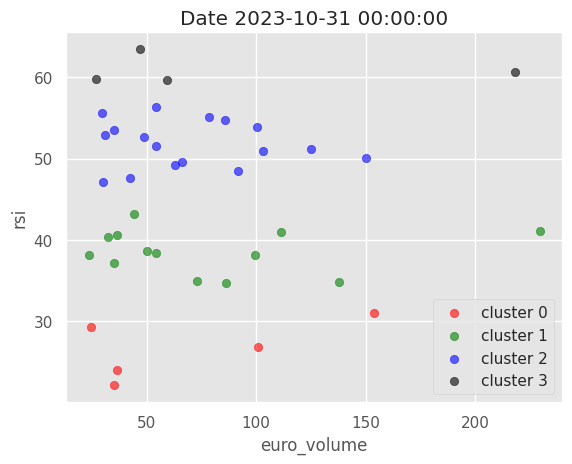

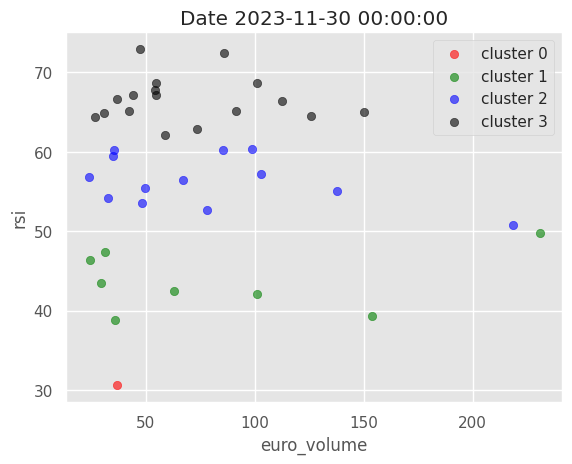

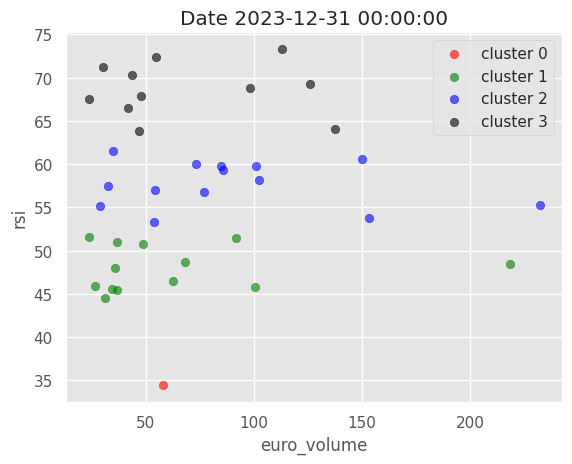

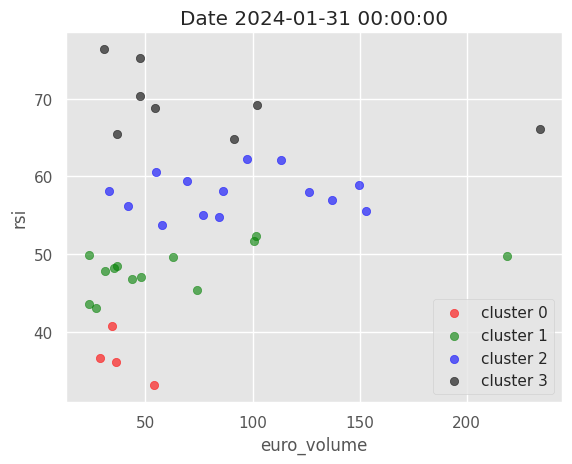

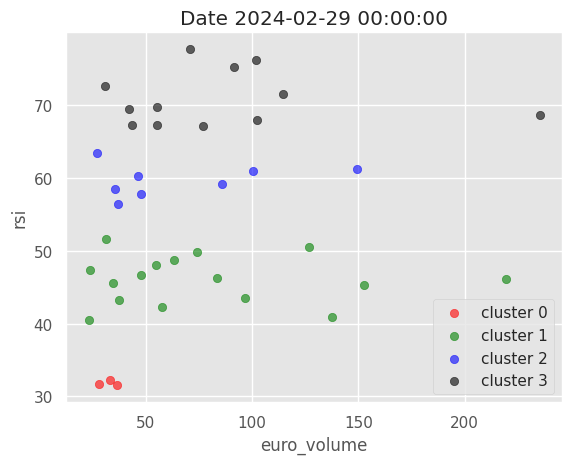

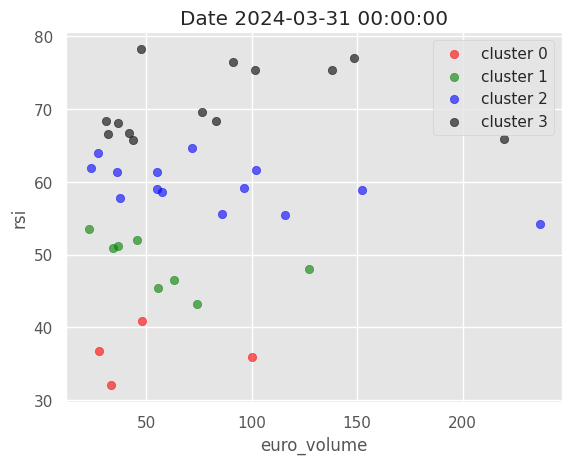

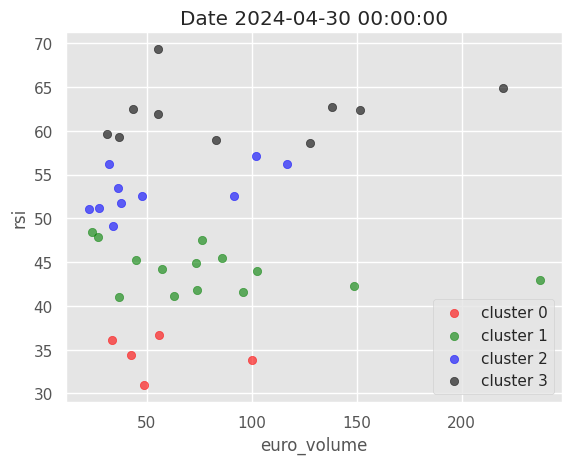

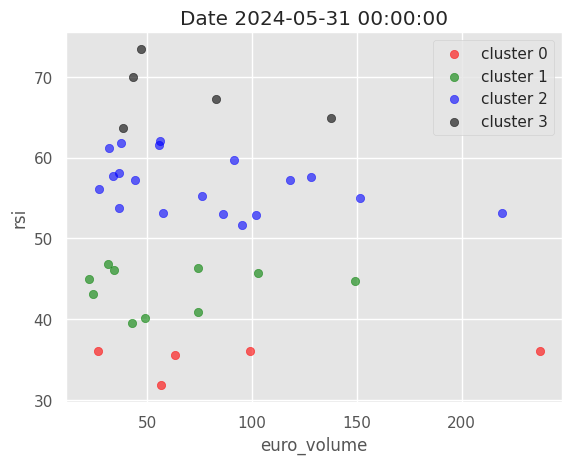

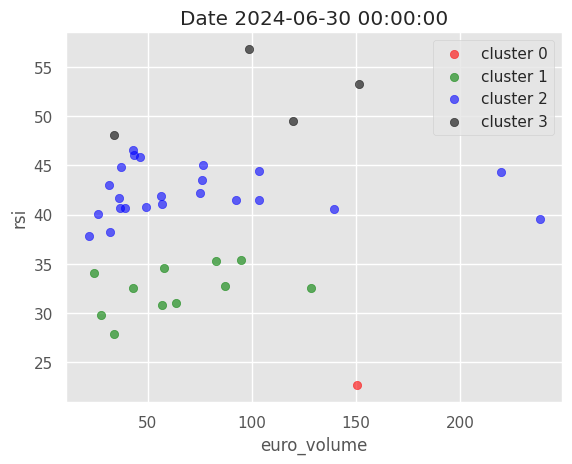

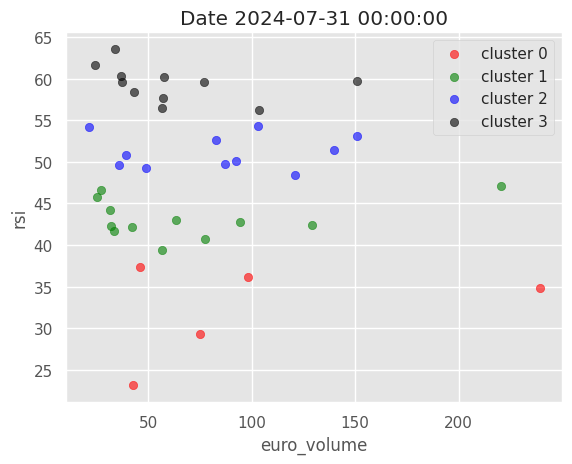

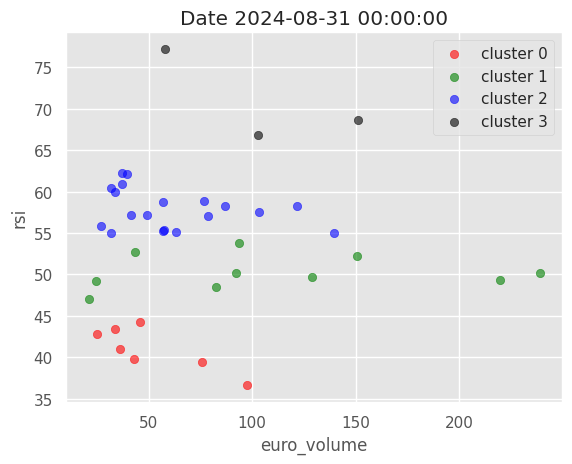

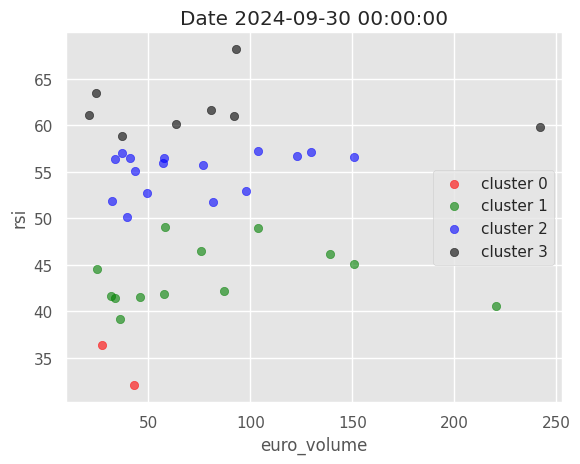

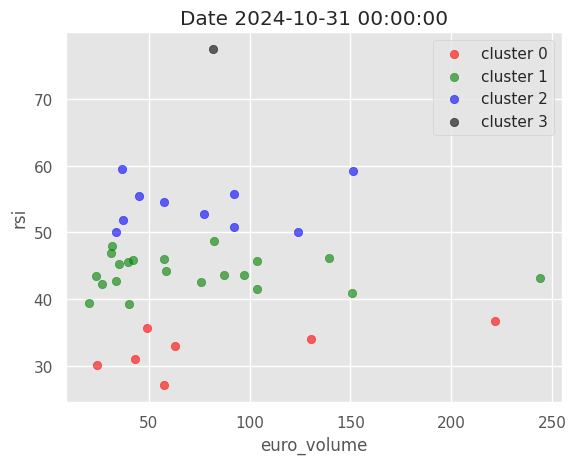

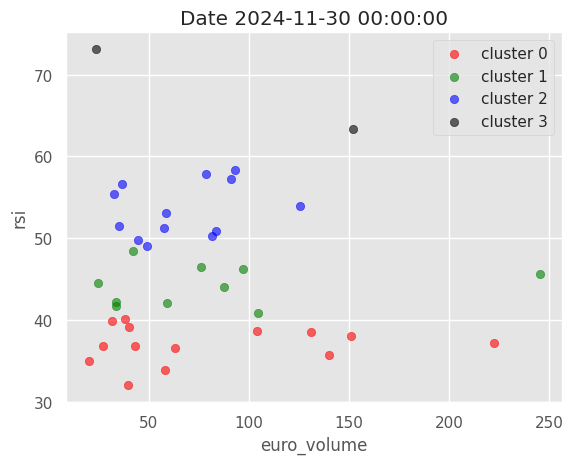

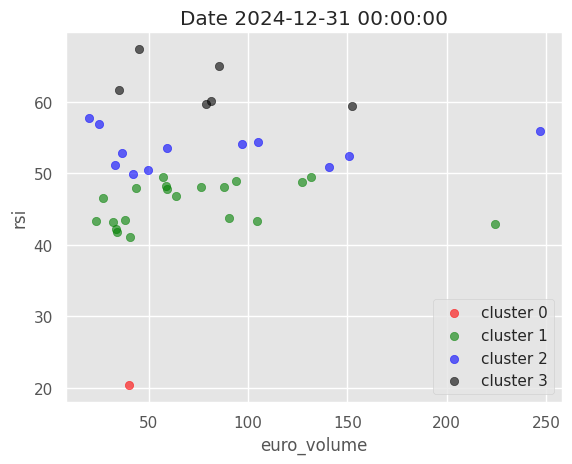

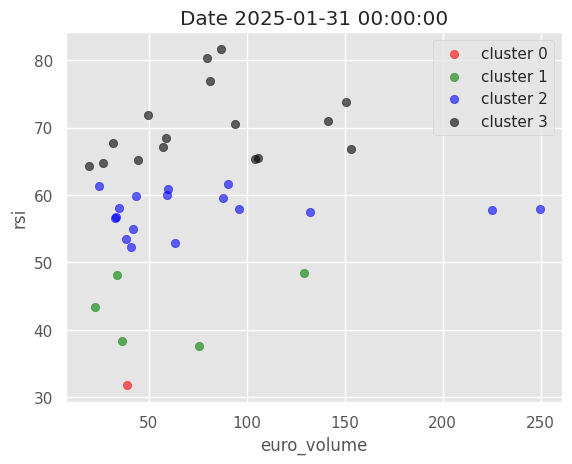

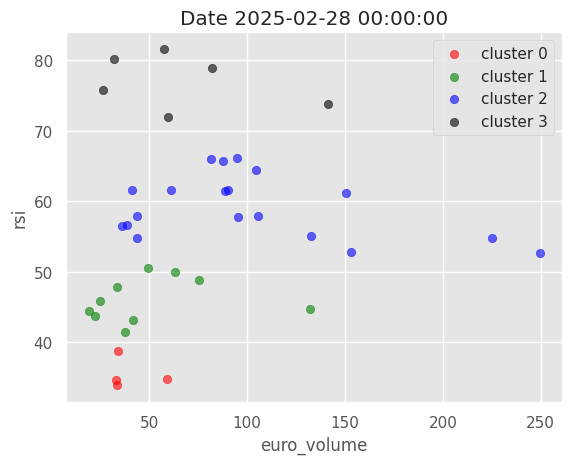

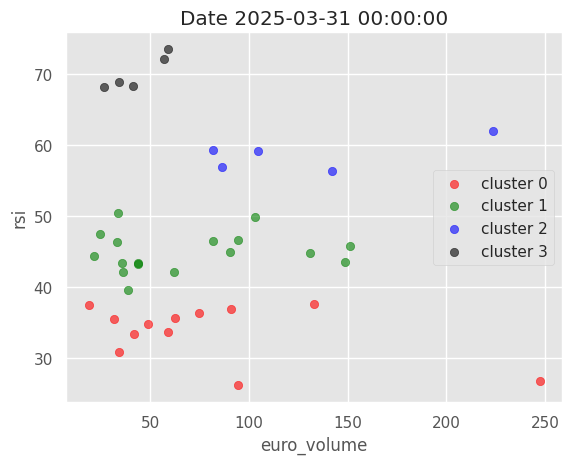

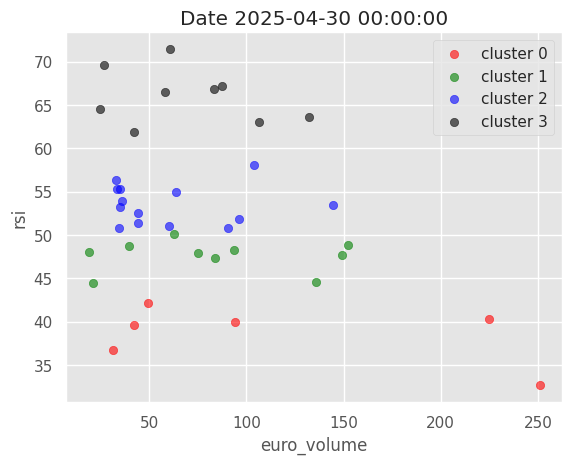

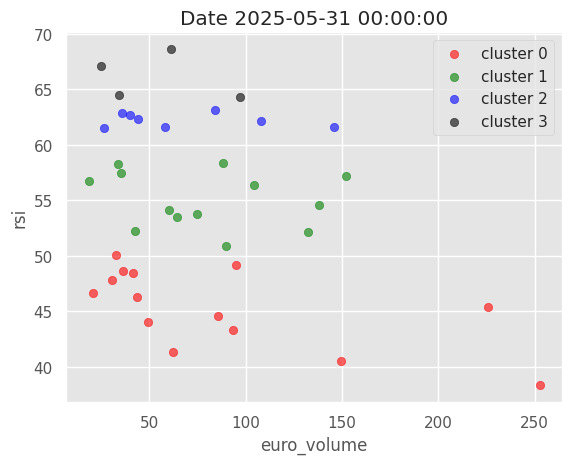

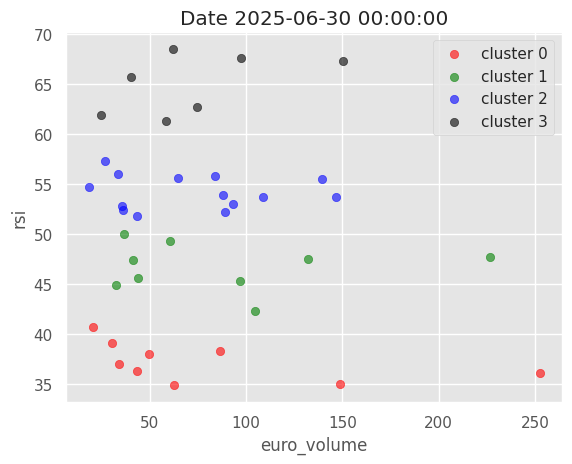

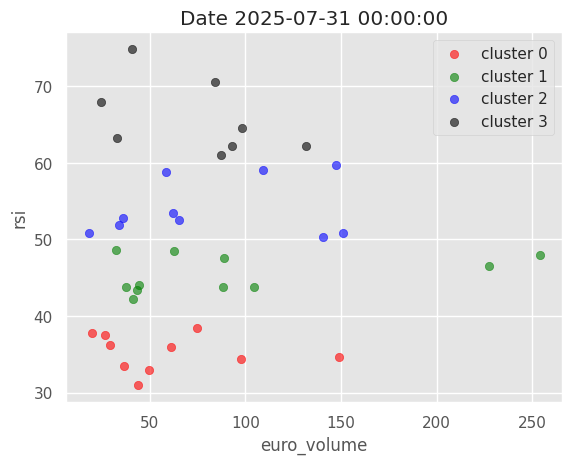

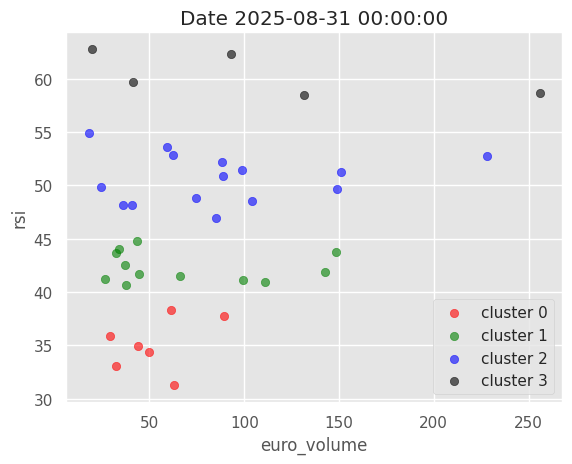

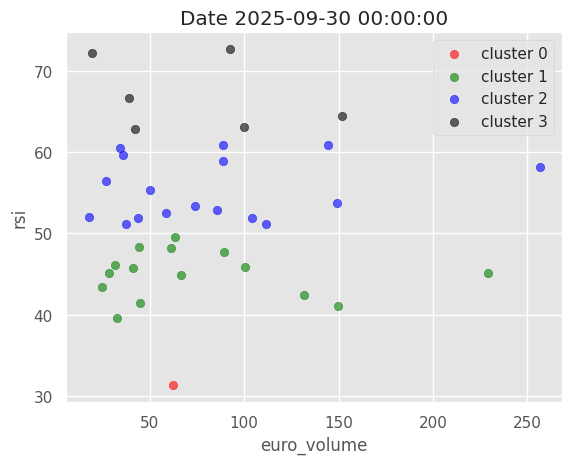

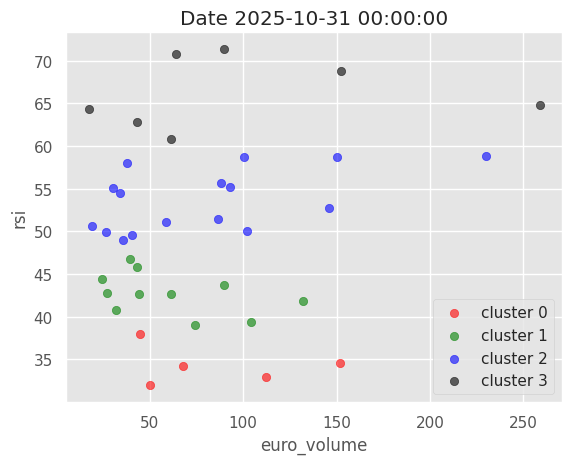

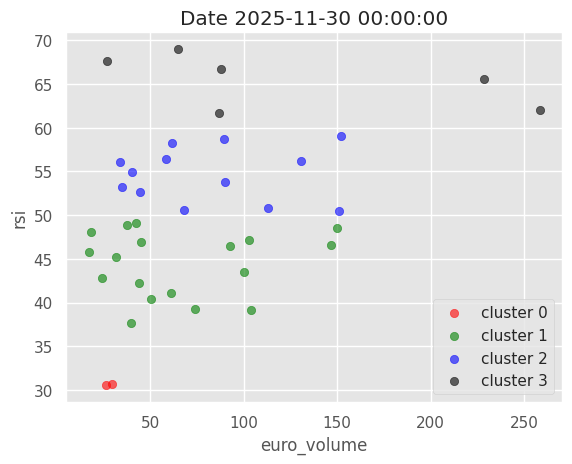

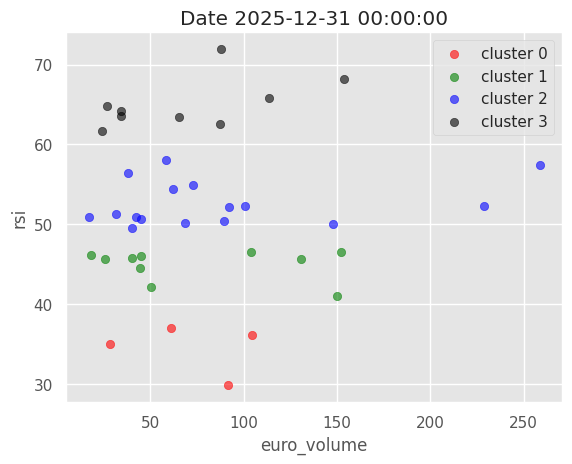

In [67]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    
    plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:, 2], color='red', label='cluster 0', alpha=0.6)
    plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 2], color='green', label='cluster 1', alpha=0.6)
    plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 2], color='blue', label='cluster 2', alpha=0.6)
    plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 2], color='black', label='cluster 3', alpha=0.6)
    
    plt.xlabel(data.columns[0])  # Nom de la colonne X
    plt.ylabel(data.columns[2])  # Nom de la colonne Y (RSI)
    plt.legend()
    plt.show()

# Plot pour chaque date
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)


## Prediction using Supervised ML

NameError: name 'df' is not defined

## XGBoost 


🎯 XGBOOST CLASSIFICATION - Prédiction Direction (Hausse/Baisse)
🔒 VERSION SANS LOOK-AHEAD BIAS (TARGET FUTURE)

🛠️ Préparation des données (Lag des variables macro)...
✅ Variables macro décalées (t-1).

🎯 Construction de la Target (Vision Future T+1)...
✅ Target 'future_return' créée.
📊 Distribution de la target :
   Baisse (0) : 1,855 (45.1%)
   Hausse (1) : 2,259 (54.9%)
   Ratio déséquilibre : 0.82:1

🔍 Nettoyage final :
   Lignes restantes : 4,112 (sur 4,114)

🔀 Split Train/Test :
   Train : 3,289
   Test  : 823

🔧 Entraînement XGBoost...
✅ Modèle entraîné (Best Iteration: 0)

📈 RÉSULTATS RÉELS (SANS TRICHE)
🎯 AUC Train : 0.7068
🎯 AUC Test  : 0.5977
📊 Accuracy  : 55.04%

✅ VALIDE : Le modèle bat le hasard (Alpha détecté).

📋 Classification Report :

              precision    recall  f1-score   support

           0     0.6392    0.1562    0.2510       397
           1     0.5386    0.9178    0.6788       426

    accuracy                         0.5504       823
   macro avg     

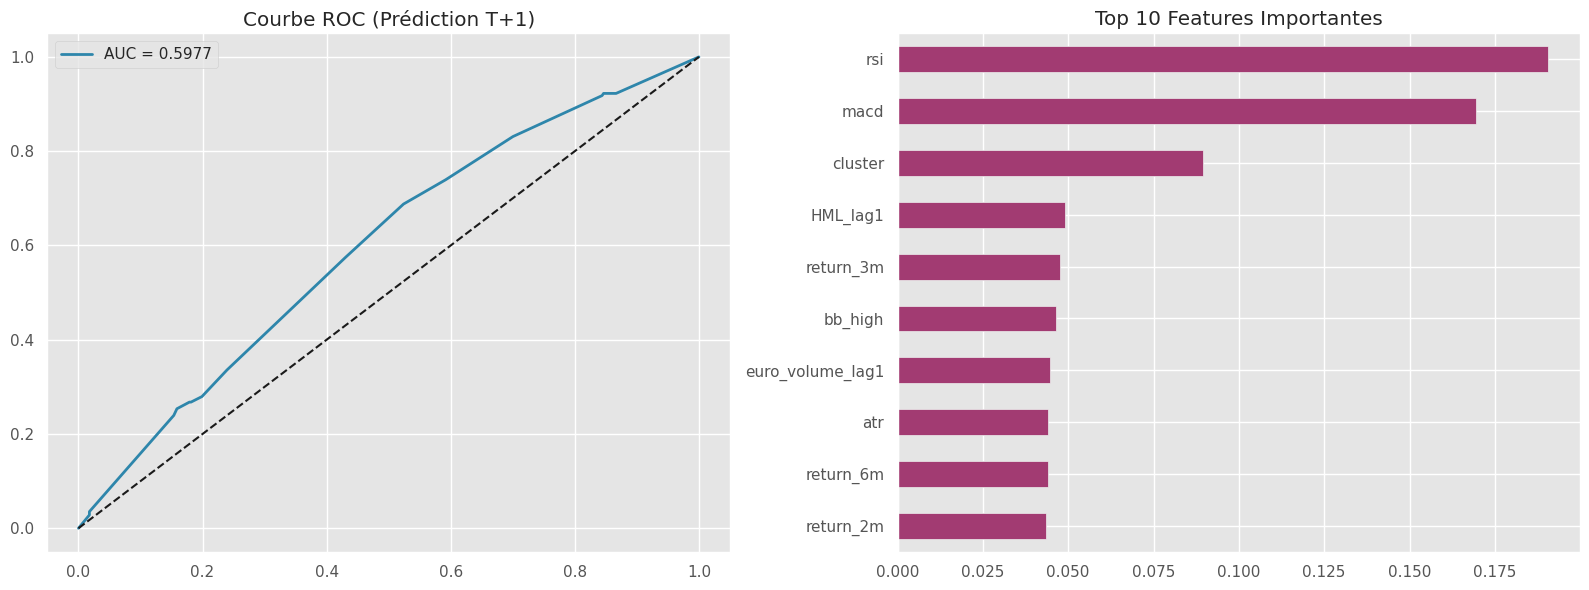

In [68]:
# =============================================================================
# XGBOOST CLASSIFICATION - VERSION FINALE (CORRIGÉE & VALIDÉE)
# =============================================================================

print("\n" + "="*70)
print("🎯 XGBOOST CLASSIFICATION - Prédiction Direction (Hausse/Baisse)")
print("🔒 VERSION SANS LOOK-AHEAD BIAS (TARGET FUTURE)")
print("="*70)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =============================================================================
# 1. INITIALISATION & LAG DES FEATURES
# =============================================================================
print("\n🛠️ Préparation des données (Lag des variables macro)...")

# On travaille sur une copie propre
ml_data = data.copy()

# Variables macro/volume à décaler (car connues seulement à la fin du mois)
vars_to_lag = [
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
    'euro_volume', 'garman_klass_vol'
]

# Application du décalage (Lag 1)
# Gestion automatique selon si l'index est MultiIndex ou non
if 'Ticker' in ml_data.index.names:
    group_obj = ml_data.groupby(level='Ticker')
elif 'Ticker' in ml_data.columns:
    group_obj = ml_data.groupby('Ticker')
else:
    group_obj = None

for col in vars_to_lag:
    if col in ml_data.columns:
        if group_obj is not None:
            ml_data[f'{col}_lag1'] = group_obj[col].shift(1)
        else:
            ml_data[f'{col}_lag1'] = ml_data[col].shift(1)

print(f"✅ Variables macro décalées (t-1).")

# =============================================================================
# 2. CRÉATION DE LA TARGET (CORRECTION CRUCIALE ICI)
# =============================================================================
print(f"\n🎯 Construction de la Target (Vision Future T+1)...")

# C'est ICI que tout se joue :
# On veut prédire le rendement du MOIS PROCHAIN.
# On prend le 'return_1m' de la ligne SUIVANTE (shift -1).

if group_obj is not None:
    ml_data['future_return'] = group_obj['return_1m'].shift(-1)
else:
    ml_data['future_return'] = ml_data['return_1m'].shift(-1)

# La target est : Est-ce que le return FUTUR sera positif ?
ml_data['target_direction'] = (ml_data['future_return'] > 0).astype(int)

print(f"✅ Target 'future_return' créée.")
print(f"📊 Distribution de la target :")
counts = ml_data['target_direction'].value_counts()
print(f"   Baisse (0) : {counts[0]:,} ({counts[0]/len(ml_data)*100:.1f}%)")
print(f"   Hausse (1) : {counts[1]:,} ({counts[1]/len(ml_data)*100:.1f}%)")

imbalance_ratio = counts[0] / counts[1]
print(f"   Ratio déséquilibre : {imbalance_ratio:.2f}:1")

# =============================================================================
# 3. PRÉPARATION DES FEATURES
# =============================================================================

# Liste des features (avec les versions _lag1 pour la macro)
feature_cols = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',          # Tech (T)
    'return_2m', 'return_3m', 'return_6m',              # Momentum Passé (T)
    'euro_volume_lag1', 'garman_klass_vol_lag1',        # Volume (T-1)
    'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1', # Macro (T-1)
    'cluster'
]

# Nettoyage : On supprime les lignes où :
# 1. Les Lags ont créé des NaN (début d'historique)
# 2. La Target future est NaN (fin d'historique)
ml_data_clean = ml_data.dropna(subset=feature_cols + ['future_return']).copy()

print(f"\n🔍 Nettoyage final :")
print(f"   Lignes restantes : {len(ml_data_clean):,} (sur {len(ml_data):,})")

# =============================================================================
# 4. SPLIT TEMPOREL (80/20)
# =============================================================================

X = ml_data_clean[feature_cols]
y = ml_data_clean['target_direction']

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\n🔀 Split Train/Test :")
print(f"   Train : {len(X_train):,}")
print(f"   Test  : {len(X_test):,}")

# =============================================================================
# 5. ENTRAÎNEMENT XGBOOST
# =============================================================================

print(f"\n🔧 Entraînement XGBoost...")

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,             # Profondeur limitée pour éviter le par-cœur
    learning_rate=0.03,      # Apprentissage lent
    subsample=0.7,
    colsample_bytree=0.7,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=30,
    eval_metric='auc'
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"✅ Modèle entraîné (Best Iteration: {xgb_clf.best_iteration})")

# =============================================================================
# 6. ÉVALUATION
# =============================================================================

y_pred_proba_test = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_class_test = xgb_clf.predict(X_test)

auc_train = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])
auc_test = roc_auc_score(y_test, y_pred_proba_test)
accuracy_test = (y_pred_class_test == y_test).mean()

print(f"\n" + "="*70)
print("📈 RÉSULTATS RÉELS (SANS TRICHE)")
print("="*70)

print(f"🎯 AUC Train : {auc_train:.4f}")
print(f"🎯 AUC Test  : {auc_test:.4f}")
print(f"📊 Accuracy  : {accuracy_test*100:.2f}%")

if auc_test > 0.53:
    print("\n✅ VALIDE : Le modèle bat le hasard (Alpha détecté).")
elif auc_test > 0.50:
    print("\n⚠️ NEUTRE : Signal faible, difficile à exploiter seul.")
else:
    print("\n❌ INVALIDE : Aucune capacité prédictive avec ces features.")

print(f"\n📋 Classification Report :\n")
print(classification_report(y_test, y_pred_class_test, digits=4))

# =============================================================================
# 7. VISUALISATIONS
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {auc_test:.4f}', color='#2E86AB')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('Courbe ROC (Prédiction T+1)')
axes[0].legend()

# Features
importances = pd.Series(xgb_clf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(10)
importances.plot(kind='barh', ax=axes[1], color='#A23B72')
axes[1].set_title('Top 10 Features Importantes')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

Cross -validation

In [69]:
# =============================================================================
# OPTIMISATION DES HYPERPARAMÈTRES (POUR BATTRE 55.3%)
# =============================================================================
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

print("\n" + "="*70)
print("⚙️ OPTIMISATION DU MODÈLE (GRID SEARCH)")
print("="*70)

# 1. Définir la grille de paramètres à tester
param_grid = {
    'max_depth': [3, 4, 5],              # Profondeur de l'arbre
    'learning_rate': [0.01, 0.05, 0.1],  # Vitesse d'apprentissage
    'n_estimators': [100, 200, 300],     # Nombre d'arbres
    'subsample': [0.6, 0.8],             # Fraction des données utilisées
    'colsample_bytree': [0.6, 0.8]       # Fraction des features utilisées
}

# 2. Configurer le modèle de base
xgb_base = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=imbalance_ratio,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# 3. Cross-Validation Temporelle (CRUCIAL : Pas de shuffle !)
# On coupe les données en 3 blocs temporels pour valider
tscv = TimeSeriesSplit(n_splits=3)

# 4. Lancer la recherche
print("⏳ Recherche des meilleurs paramètres (peut prendre 1-2 min)...")
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='roc_auc',  # On optimise l'AUC, pas l'accuracy
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 5. Résultats
best_params = grid_search.best_params_
print(f"\n✅ Meilleurs paramètres trouvés :")
print(best_params)

# 6. Test final avec les meilleurs paramètres
best_model = grid_search.best_estimator_

# Prédictions sur le Test Set (qui n'a pas été vu pendant le GridSearch)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_class = best_model.predict(X_test)
final_auc = roc_auc_score(y_test, y_pred_proba)
final_acc = (y_pred_class == y_test).mean()

print(f"\n📈 PERFORMANCE OPTIMISÉE :")
print(f"   AUC Test      : {final_acc:.4f}")
print(f"   Accuracy Test : {final_acc*100:.2f}%")

if final_acc > 0.5531:
    print("🚀 AMÉLIORATION RÉUSSIE !")
else:
    print("😐 Plafond de verre atteint avec ces features.")




⚙️ OPTIMISATION DU MODÈLE (GRID SEARCH)
⏳ Recherche des meilleurs paramètres (peut prendre 1-2 min)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✅ Meilleurs paramètres trouvés :
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

📈 PERFORMANCE OPTIMISÉE :
   AUC Test      : 0.5577
   Accuracy Test : 55.77%
🚀 AMÉLIORATION RÉUSSIE !



📊 ANALYSE VISUELLE DU MODÈLE OPTIMISÉ (GRID SEARCH)


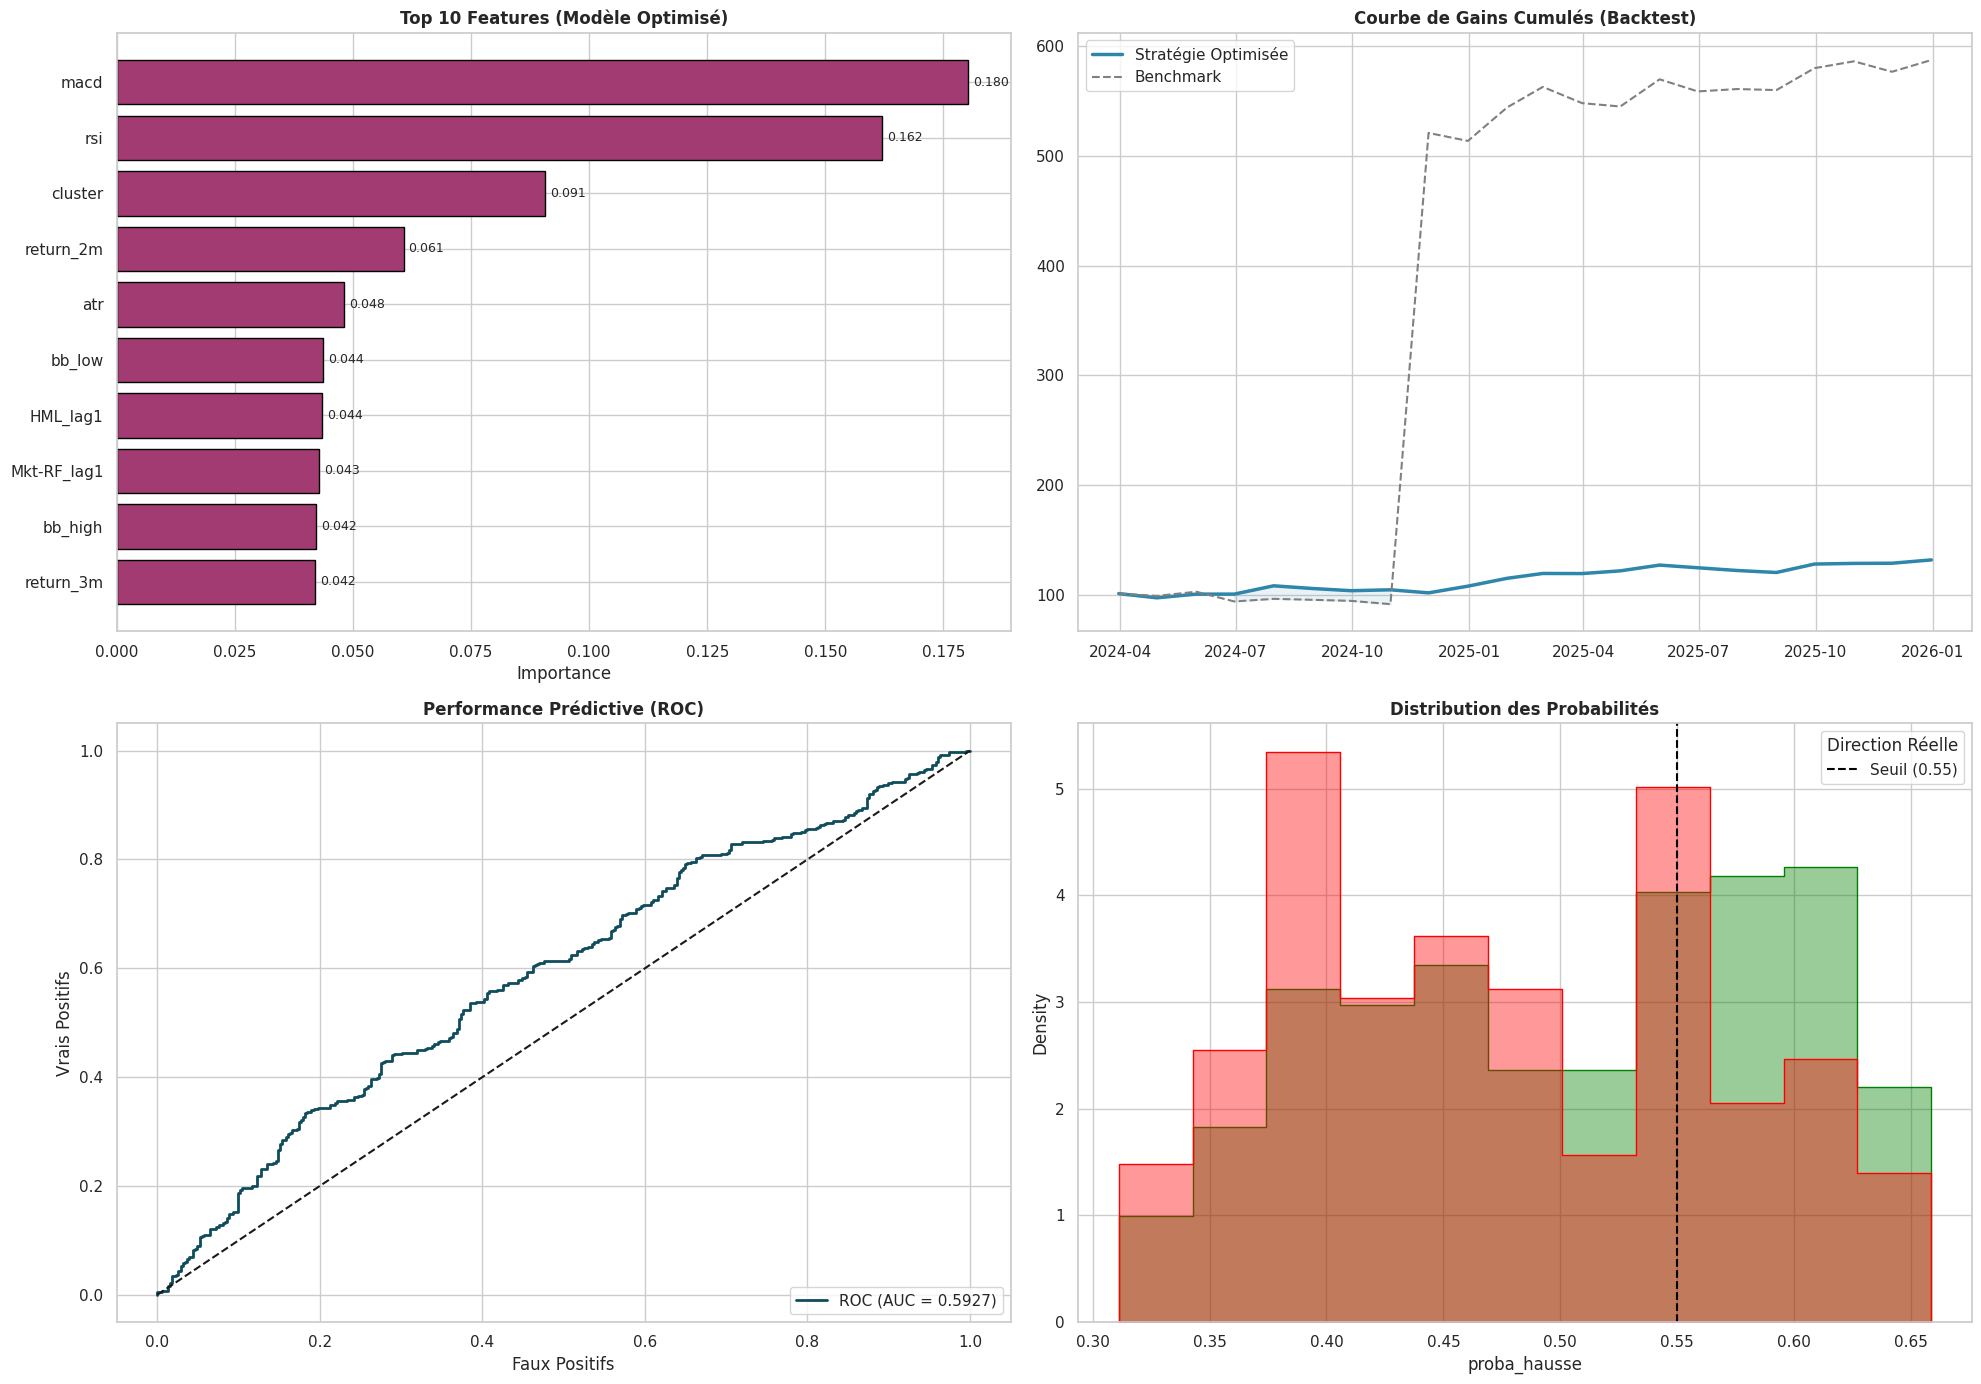

✅ Analyse terminée.
   Top 1 Feature : macd (0.180)
   Alpha final   : -454.93 pts


In [70]:
# =============================================================================
# VISUALISATION DES RÉSULTATS DU GRIDSEARCH (CORRIGÉ)
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

print("\n" + "="*70)
print("📊 ANALYSE VISUELLE DU MODÈLE OPTIMISÉ (GRID SEARCH)")
print("="*70)

# 1. Récupération du modèle champion
best_model = grid_search.best_estimator_

# 2. Configuration graphique
sns.set(style="whitegrid")
fig = plt.figure(figsize=(20, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# -----------------------------------------------------------------------------
# GRAPHIQUE 1 : FEATURE IMPORTANCE
# -----------------------------------------------------------------------------
ax1 = plt.subplot(2, 2, 1)

# Extraction des importances
importances = pd.Series(best_model.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False).head(10)

# Barplot
bars = ax1.barh(importances.index, importances.values, color='#A23B72', edgecolor='black')
ax1.invert_yaxis()
ax1.set_title(f'Top 10 Features (Modèle Optimisé)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Importance')

# Annotation
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# -----------------------------------------------------------------------------
# GRAPHIQUE 2 : EQUITY CURVE (Correction ici)
# -----------------------------------------------------------------------------
ax2 = plt.subplot(2, 2, 2)

# Vérification/Création de df_trading si absent
if 'df_trading' not in locals():
    df_trading = ml_data_clean.iloc[split_idx:].copy()
    df_trading['proba_hausse'] = best_model.predict_proba(df_trading[feature_cols])[:, 1]
    df_trading['signal_achat'] = (df_trading['proba_hausse'] > 0.55).astype(int)

# --- CORRECTION DU BUG DE GROUPBY ---
# On définit le nom du niveau de l'index à utiliser pour grouper (Date)
# Si 'Date' est dans l'index, on l'utilise, sinon on prend le niveau 0
date_level = 'Date' if 'Date' in df_trading.index.names else 0

# 1. Benchmark (Moyenne de TOUTES les lignes par date)
bench_ret = df_trading.groupby(level=date_level)['future_return'].mean()

# 2. Stratégie (Moyenne seulement des lignes FILTRÉES par date)
# On filtre D'ABORD, et on groupe sur le résultat filtré
df_signal = df_trading[df_trading['signal_achat'] == 1]
strat_ret = df_signal.groupby(level=date_level)['future_return'].mean()

# 3. Alignement (Pour les mois où la stratégie n'a rien acheté, return = 0)
strat_ret = strat_ret.reindex(bench_ret.index).fillna(0)

# 4. Cumul
bench_curve = (1 + bench_ret).cumprod() * 100
strat_curve = (1 + strat_ret).cumprod() * 100

# Plot
ax2.plot(strat_curve.index, strat_curve, color='#2E86AB', lw=2.5, label='Stratégie Optimisée')
ax2.plot(bench_curve.index, bench_curve, color='gray', ls='--', lw=1.5, label='Benchmark')
ax2.fill_between(strat_curve.index, strat_curve, bench_curve, 
                 where=(strat_curve >= bench_curve), color='#2E86AB', alpha=0.1)

ax2.set_title('Courbe de Gains Cumulés (Backtest)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')

# -----------------------------------------------------------------------------
# GRAPHIQUE 3 : COURBE ROC
# -----------------------------------------------------------------------------
ax3 = plt.subplot(2, 2, 3)

fpr, tpr, _ = roc_curve(df_trading['target_direction'], df_trading['proba_hausse'])
roc_auc = auc(fpr, tpr)

ax3.plot(fpr, tpr, color='#0F4C5C', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_title('Performance Prédictive (ROC)', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')
ax3.set_xlabel('Faux Positifs')
ax3.set_ylabel('Vrais Positifs')

# -----------------------------------------------------------------------------
# GRAPHIQUE 4 : HISTOGRAMME DE CONFIANCE
# -----------------------------------------------------------------------------
ax4 = plt.subplot(2, 2, 4)

sns.histplot(data=df_trading, x='proba_hausse', hue='target_direction', 
             element="step", stat="density", common_norm=False, ax=ax4,
             palette={0: "red", 1: "green"}, alpha=0.4)

ax4.axvline(0.55, color='black', ls='--', label='Seuil (0.55)')
ax4.set_title('Distribution des Probabilités', fontsize=12, fontweight='bold')
ax4.legend(title='Direction Réelle')

plt.tight_layout()
plt.show()

# Résumé textuel
print(f"✅ Analyse terminée.")
print(f"   Top 1 Feature : {importances.index[0]} ({importances.iloc[0]:.3f})")
print(f"   Alpha final   : {strat_curve.iloc[-1] - bench_curve.iloc[-1]:.2f} pts")

## LSTM


🧠 LSTM - Deep Learning pour Séries Temporelles


2025-12-26 13:11:55.449953: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-26 13:11:55.514403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-26 13:11:56.972783: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.



📊 Préparation données LSTM...
   Observations totales : 3,456
   Features : 15

🔧 Normalisation des données...
   Train : 2,764 obs
   Test  : 692 obs
✅ Normalisation complète

🔄 Création séquences temporelles (lookback=20)...
   Train sequences : (2744, 20, 15)
   Test sequences  : (672, 20, 15)
   Shape détail    : (samples, time_steps, features)

🏗️ Construction architecture LSTM...

📋 Architecture LSTM :


2025-12-26 13:11:57.596462: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,481 (1.21 MB)

 Trainable params: 316,481 (1.21 MB)

 Non-trainable params: 0 (0.00 B)


   Total paramètres : 316,481

🔥 Entraînement LSTM...
   (Cela peut prendre 5-10 minutes...)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0180 - mae: 0.0989 - val_loss: 37.6648 - val_mae: 0.3398 - learning_rate: 0.0010
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0104 - mae: 0.0766 - val_loss: 37.6623 - val_mae: 0.3342 - learning_rate: 0.0010
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0085 - mae: 0.0696 - val_loss: 37.6611 - val_mae: 0.3285 - learning_rate: 0.0010
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0076 - mae: 0.0651 - val_loss: 37.6621 - val_mae: 0.3300 - learning_rate: 0.0010
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0070 - mae: 0.0614 - val_loss: 37.6417 - val_mae: 0.3058 - learning_rate: 0.0010
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0066 - mae: 0.0601 - val_loss: 37.6424 - val_mae: 0.3058 - learning_rate: 0.0010
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms

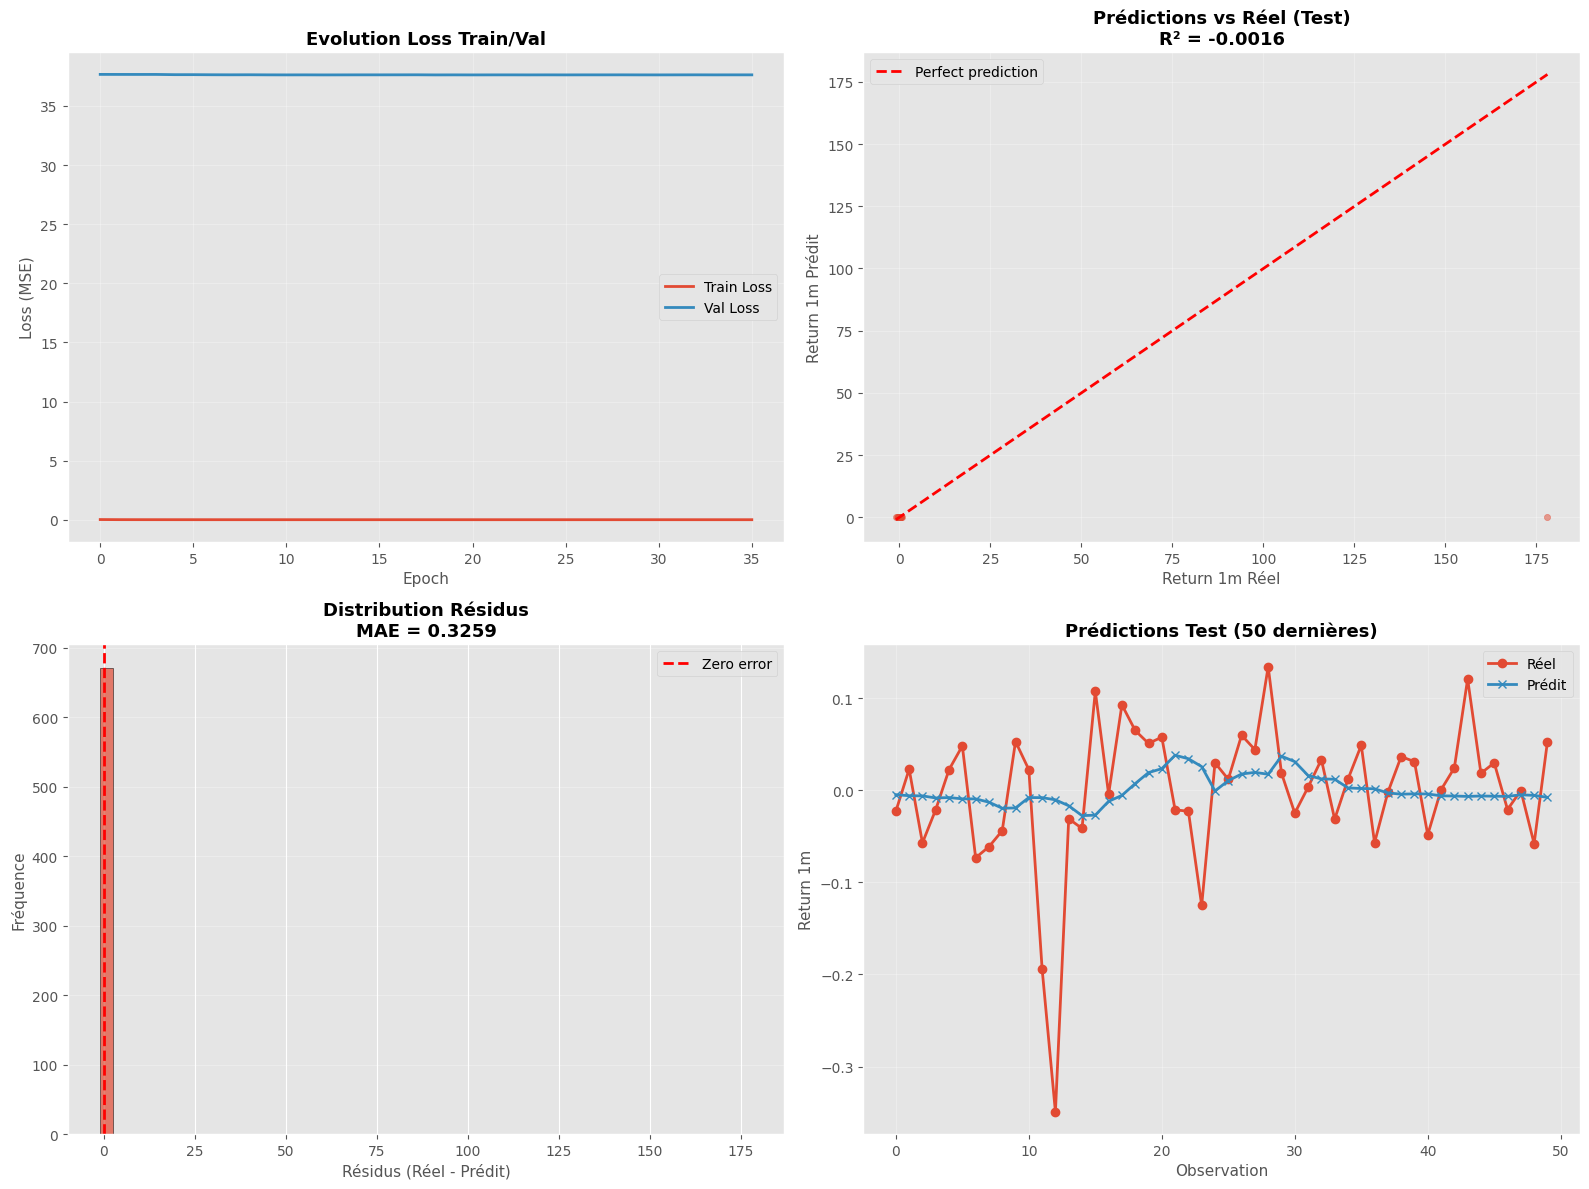


🎯 ANALYSE DIRECTION (Hausse/Baisse)

📊 Précision Direction : 58.48%

📋 Matrice Confusion (Direction) :
              Prédit Baisse  Prédit Hausse
Réel Baisse         187           121
Réel Hausse         158           206

📋 Classification Report :
              precision    recall  f1-score   support

      Baisse     0.5420    0.6071    0.5727       308
      Hausse     0.6300    0.5659    0.5962       364

    accuracy                         0.5848       672
   macro avg     0.5860    0.5865    0.5845       672
weighted avg     0.5897    0.5848    0.5855       672


💡 INTERPRÉTATION LSTM

🎯 Performance Régression :
   ❌ R² = -0.0016 → PAS de signal
   → Pire que prédire la moyenne

🎯 Performance Direction :
   ✅ Accuracy = 58.5% → BON
   → Signal détecté

📊 Comparaison XGBoost vs LSTM :
   XGBoost Classification : AUC 0.9556, Accuracy 88%
   LSTM Régression        : R² -0.0016, Dir Accuracy 58.5%

   → XGBoost >> LSTM (comme attendu)
   → Finance = bruit élevé, LSTM pas optimal
  

In [ ]:
# =============================================================================
# LSTM - Prédiction Séries Temporelles CAC40
# =============================================================================

print("\n" + "="*70)
print("🧠 LSTM - Deep Learning pour Séries Temporelles")
print("="*70)

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Seed pour reproductibilité
np.random.seed(42)
tf.random.set_seed(42)


# =============================================================================
# 1. PRÉPARATION DONNÉES POUR LSTM
# =============================================================================

print(f"\n📊 Préparation données LSTM...")

# Sélectionner features
feature_cols_lstm = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    'euro_volume', 'garman_klass_vol',
    'return_2m', 'return_3m', 'return_6m',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'
    # PAS de cluster (catégoriel non géré facilement par LSTM)
]

# Dataset
lstm_data = data[feature_cols_lstm + ['return_1m']].dropna().copy()

print(f"   Observations totales : {len(lstm_data):,}")
print(f"   Features : {len(feature_cols_lstm)}")


# =============================================================================
# 2. NORMALISATION (obligatoire pour LSTM)
# =============================================================================

print(f"\n🔧 Normalisation des données...")

# Split AVANT normalisation
split_idx = int(len(lstm_data) * 0.8)
train_data = lstm_data.iloc[:split_idx].copy()
test_data = lstm_data.iloc[split_idx:].copy()

print(f"   Train : {len(train_data):,} obs")
print(f"   Test  : {len(test_data):,} obs")

# Scaler pour features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(train_data[feature_cols_lstm])

X_train_scaled = scaler_X.transform(train_data[feature_cols_lstm])
X_test_scaled = scaler_X.transform(test_data[feature_cols_lstm])

# Scaler pour target (séparé)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(train_data[['return_1m']])

y_train_scaled = scaler_y.transform(train_data[['return_1m']])
y_test_scaled = scaler_y.transform(test_data[['return_1m']])

print(f"✅ Normalisation complète")


# =============================================================================
# 3. CRÉATION SÉQUENCES TEMPORELLES
# =============================================================================

def create_sequences(X, y, time_steps=20):
    """
    Crée séquences pour LSTM
    
    Parameters:
    -----------
    X : array, features normalisées
    y : array, target normalisée
    time_steps : int, longueur séquence (lookback period)
    
    Returns:
    --------
    X_seq : array shape (samples, time_steps, features)
    y_seq : array shape (samples, 1)
    """
    X_seq, y_seq = [], []
    
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])  # Lookback window
        y_seq.append(y[i])                # Target au temps t
    
    return np.array(X_seq), np.array(y_seq)


# Paramètres
TIME_STEPS = 20  # Utilise 20 jours passés pour prédire

print(f"\n🔄 Création séquences temporelles (lookback={TIME_STEPS})...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"   Train sequences : {X_train_seq.shape}")
print(f"   Test sequences  : {X_test_seq.shape}")
print(f"   Shape détail    : (samples, time_steps, features)")


# =============================================================================
# 4. CONSTRUCTION MODÈLE LSTM
# =============================================================================

print(f"\n🏗️ Construction architecture LSTM...")

model = Sequential([
    # Couche LSTM 1 (Bidirectional = lit avant + arrière)
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh'),
                  input_shape=(TIME_STEPS, len(feature_cols_lstm))),
    Dropout(0.3),
    
    # Couche LSTM 2
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.3),
    
    # Couches Dense (fully connected)
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    
    # Output (régression)
    Dense(1, activation='linear')
])

# Compiler
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Résumé architecture
print(f"\n📋 Architecture LSTM :")
model.summary()

# Compter paramètres
total_params = model.count_params()
print(f"\n   Total paramètres : {total_params:,}")


# =============================================================================
# 5. CALLBACKS (early stopping, learning rate)
# =============================================================================

# Early stopping (arrête si pas d'amélioration)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Réduction learning rate si plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stop, reduce_lr]


# =============================================================================
# 6. ENTRAÎNEMENT
# =============================================================================

print(f"\n🔥 Entraînement LSTM...")
print(f"   (Cela peut prendre 5-10 minutes...)\n")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    verbose=1  # Affiche progression
)

print(f"\n✅ Entraînement terminé")
print(f"   Epochs réalisés : {len(history.history['loss'])}")


# =============================================================================
# 7. PRÉDICTIONS
# =============================================================================

print(f"\n🔮 Génération prédictions...")

# Prédictions normalisées
y_train_pred_scaled = model.predict(X_train_seq, verbose=0)
y_test_pred_scaled = model.predict(X_test_seq, verbose=0)

# Dénormaliser (retour échelle originale)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_train_true = scaler_y.inverse_transform(y_train_seq)
y_test_true = scaler_y.inverse_transform(y_test_seq)

print(f"✅ Prédictions générées")


# =============================================================================
# 8. MÉTRIQUES DE PERFORMANCE
# =============================================================================

print(f"\n" + "="*70)
print("📊 RÉSULTATS LSTM")
print("="*70)

# MSE
mse_train = mean_squared_error(y_train_true, y_train_pred)
mse_test = mean_squared_error(y_test_true, y_test_pred)

# MAE
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)

# R²
r2_train = r2_score(y_train_true, y_train_pred)
r2_test = r2_score(y_test_true, y_test_pred)

# RMSE
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"\n📈 Métriques Train :")
print(f"   MSE  : {mse_train:.6f}")
print(f"   RMSE : {rmse_train:.6f}")
print(f"   MAE  : {mae_train:.6f}")
print(f"   R²   : {r2_train:.4f}")

print(f"\n📉 Métriques Test :")
print(f"   MSE  : {mse_test:.6f}")
print(f"   RMSE : {rmse_test:.6f}")
print(f"   MAE  : {mae_test:.6f}")
print(f"   R²   : {r2_test:.4f}")

# Gap train/test
gap_r2 = r2_train - r2_test
print(f"\n   Gap R² : {gap_r2:.4f}", end="")

if gap_r2 > 0.15:
    print(" ⚠️ Overfitting")
elif gap_r2 > 0.10:
    print(" ⚠️ Léger overfitting")
else:
    print(" ✅ Bon équilibre")


# =============================================================================
# 9. VISUALISATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 9.1 Courbes loss train/val ---
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 0].set_title('Evolution Loss Train/Val', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- 9.2 Prédictions vs Réel (Test) ---
axes[0, 1].scatter(y_test_true, y_test_pred, alpha=0.5, s=20)
axes[0, 1].plot([y_test_true.min(), y_test_true.max()], 
                [y_test_true.min(), y_test_true.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Return 1m Réel', fontsize=11)
axes[0, 1].set_ylabel('Return 1m Prédit', fontsize=11)
axes[0, 1].set_title(f'Prédictions vs Réel (Test)\nR² = {r2_test:.4f}', 
                     fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- 9.3 Résidus (Erreurs) ---
residuals = y_test_true.flatten() - y_test_pred.flatten()

axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', lw=2, label='Zero error')
axes[1, 0].set_xlabel('Résidus (Réel - Prédit)', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title(f'Distribution Résidus\nMAE = {mae_test:.4f}', 
                     fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# --- 9.4 Séries temporelles (50 dernières prédictions) ---
n_show = 50
axes[1, 1].plot(range(n_show), y_test_true[-n_show:], 
               label='Réel', marker='o', linewidth=2)
axes[1, 1].plot(range(n_show), y_test_pred[-n_show:], 
               label='Prédit', marker='x', linewidth=2)
axes[1, 1].set_xlabel('Observation', fontsize=11)
axes[1, 1].set_ylabel('Return 1m', fontsize=11)
axes[1, 1].set_title('Prédictions Test (50 dernières)', 
                     fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# =============================================================================
# 10. ANALYSE DIRECTION (Classification post-hoc)
# =============================================================================

print(f"\n" + "="*70)
print("🎯 ANALYSE DIRECTION (Hausse/Baisse)")
print("="*70)

# Convertir en direction (>0 = hausse)
y_test_direction_true = (y_test_true > 0).astype(int).flatten()
y_test_direction_pred = (y_test_pred > 0).astype(int).flatten()

# Accuracy direction
accuracy_direction = (y_test_direction_true == y_test_direction_pred).mean()

print(f"\n📊 Précision Direction : {accuracy_direction*100:.2f}%")

# Matrice confusion
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_direction_true, y_test_direction_pred)

print(f"\n📋 Matrice Confusion (Direction) :")
print(f"              Prédit Baisse  Prédit Hausse")
print(f"Réel Baisse        {cm[0,0]:4d}          {cm[0,1]:4d}")
print(f"Réel Hausse        {cm[1,0]:4d}          {cm[1,1]:4d}")

print(f"\n📋 Classification Report :")
print(classification_report(
    y_test_direction_true, 
    y_test_direction_pred,
    target_names=['Baisse', 'Hausse'],
    digits=4
))


# =============================================================================
# 11. INTERPRÉTATION FINALE
# =============================================================================

print(f"\n" + "="*70)
print("💡 INTERPRÉTATION LSTM")
print("="*70)

print(f"\n🎯 Performance Régression :")
if r2_test > 0.10:
    print(f"   ✅ R² = {r2_test:.4f} → BON pouvoir prédictif")
    print(f"   → LSTM capte {r2_test*100:.1f}% de la variance")
elif r2_test > 0.05:
    print(f"   ⚠️ R² = {r2_test:.4f} → Signal FAIBLE")
    print(f"   → Mieux que baseline mais limité")
elif r2_test > 0:
    print(f"   ⚠️ R² = {r2_test:.4f} → Signal TRÈS FAIBLE")
    print(f"   → À peine mieux que moyenne")
else:
    print(f"   ❌ R² = {r2_test:.4f} → PAS de signal")
    print(f"   → Pire que prédire la moyenne")

print(f"\n🎯 Performance Direction :")
if accuracy_direction > 0.60:
    print(f"   ✅ Accuracy = {accuracy_direction*100:.1f}% → EXCELLENT")
    print(f"   → Exploitable en trading")
elif accuracy_direction > 0.55:
    print(f"   ✅ Accuracy = {accuracy_direction*100:.1f}% → BON")
    print(f"   → Signal détecté")
elif accuracy_direction > 0.52:
    print(f"   ⚠️ Accuracy = {accuracy_direction*100:.1f}% → FAIBLE")
    print(f"   → Légèrement mieux que random (50%)")
else:
    print(f"   ❌ Accuracy = {accuracy_direction*100:.1f}% → PAS de signal")

print(f"\n📊 Comparaison XGBoost vs LSTM :")
print(f"   XGBoost Classification : AUC 0.9556, Accuracy 88%")
print(f"   LSTM Régression        : R² {r2_test:.4f}, Dir Accuracy {accuracy_direction*100:.1f}%")

if r2_test < 0.10 and accuracy_direction < 0.60:
    print(f"\n   → XGBoost >> LSTM (comme attendu)")
    print(f"   → Finance = bruit élevé, LSTM pas optimal")
    print(f"   → XGBoost mieux adapté (features + robuste)")
else:
    print(f"\n   → LSTM performant ! Considérer ensemble models")

print(f"\n🚀 Recommandation :")
if r2_test > 0.10:
    print(f"   → Combiner XGBoost + LSTM (ensemble voting)")
    print(f"   → LSTM pour tendances, XGBoost pour classification")
else:
    print(f"   → Garder SEULEMENT XGBoost (plus performant)")
    print(f"   → LSTM = Intéressant académiquement mais pas opérationnel")

print("\n" + "="*70)


## Optimization portfolio

- Only stocks on cluster3

In [71]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-03-01': ['AIR.PA', 'ATO.PA', 'STMPA.PA'],
 '2017-04-01': ['ALO.PA',
  'ATO.PA',
  'CAP.PA',
  'DG.PA',
  'DSY.PA',
  'ENGI.PA',
  'LR.PA',
  'MC.PA',
  'ML.PA',
  'RMS.PA',
  'SAN.PA',
  'VIE.PA',
  'VIV.PA',
  'WLN.PA'],
 '2017-05-01': ['ERF.PA', 'KER.PA', 'MC.PA', 'SAF.PA', 'TEP.PA'],
 '2017-06-01': ['ALO.PA',
  'ATO.PA',
  'ERF.PA',
  'HO.PA',
  'KER.PA',
  'OR.PA',
  'RI.PA',
  'SAF.PA',
  'TEP.PA',
  'VIE.PA'],
 '2017-07-01': ['BNP.PA',
  'CA.PA',
  'CS.PA',
  'ERF.PA',
  'GLE.PA',
  'KER.PA',
  'LR.PA',
  'MT.AS',
  'SAF.PA'],
 '2017-08-01': ['WLN.PA'],
 '2017-09-01': ['ATO.PA',
  'CAP.PA',
  'DG.PA',
  'DSY.PA',
  'EN.PA',
  'ENGI.PA',
  'ERF.PA',
  'KER.PA',
  'MC.PA',
  'MT.AS',
  'ORA.PA',
  'RMS.PA',
  'SAF.PA',
  'STMPA.PA',
  'SU.PA',
  'TEP.PA',
  'TTE.PA',
  'VIE.PA',
  'WLN.PA'],
 '2017-10-01': ['AI.PA',
  'AIR.PA',
  'ALO.PA',
  'EN.PA',
  'ERF.PA',
  'KER.PA',
  'MC.PA',
  'RNO.PA',
  'SAF.PA',
  'SGO.PA',
  'STMPA.PA',
  'SU.PA',
  'TEP.PA',
  'TTE.PA',
  'VIV

- Function optimizatio

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  39 of 39 completed


Price            Close                                                 \
Ticker           AI.PA      AIR.PA     ALO.PA       ATO.PA     BNP.PA   
Date                                                                    
2016-02-29   51.831635   51.886936  15.750299  3453.156250  24.519478   
2016-03-01   52.419037   52.772259  16.086077  3523.503174  25.095396   
2016-03-02   52.181927   52.546589  16.136833  3510.152588  25.933622   
2016-03-03   52.251980   52.746223  16.289106  3477.290039  26.079025   
2016-03-04   52.580711   53.900612  17.530703  3467.020020  26.506695   
...                ...         ...        ...          ...        ...   
2025-12-18  159.699997  194.039993  24.900000    48.145000  80.239998   
2025-12-19  159.500000  195.839996  24.870001    46.455002  80.599998   
2025-12-22  160.000000  195.720001  24.860001    45.400002  80.250000   
2025-12-23  159.839996  196.720001  24.799999    45.500000  80.610001   
2025-12-24  160.020004  195.960007  24.959999    45.799999  80.519997   

Price                                                                ...  \
Ticker          CA.PA      CAP.PA      CS.PA       DG.PA     DSY.PA  ...   
Date                                                                 ...   
2016-02-29  17.000074   64.992134  11.741971   46.638023  13.242381  ...   
2016-03-01  17.369411   65.924240  12.045719   46.769562  13.594807  ...   
2016-03-02  17.404257   66.610588  12.401536   46.009563  13.318172  ...   
2016-03-03  17.331087   65.187027  12.488318   46.046085  13.026381  ...   
2016-03-04  18.397291   65.542931  12.352359   46.740330  12.979012  ...   
...               ...         ...        ...         ...        ...  ...   
2025-12-18  14.325000  147.449997  40.830002  120.250000  23.730000  ...   
2025-12-19  14.365000  145.600006  41.200001  119.800003  23.700001  ...   
2025-12-22  14.285000  144.449997  41.099998  119.900002  23.740000  ...   
2025-12-23  14.120000  141.399994  41.110001  119.800003  23.670000  ...   
2025-12-24  14.125000  141.649994  41.139999  119.650002  23.559999  ...   

Price        Volume                                                        \
Ticker       SAN.PA   SGO.PA STLAP.PA STMPA.PA    SU.PA  TEP.PA    TTE.PA   
Date                                                                        
2016-02-29  3672020  2850570        0  2298481  2056433  161775   8546865   
2016-03-01  2555853  1944978        0  1273769  1566456  205672   7941184   
2016-03-02  2580515  1833589        0  2146525  1130064  135795   6446017   
2016-03-03  3191388  1802167        0  1726420  1326241  138658   6110392   
2016-03-04  2990837  1808686        0  2101212  1546600  191642   7174640   
...             ...      ...      ...      ...      ...     ...       ...   
2025-12-18  1980683   906167  2868703  1893016  1135590  298941   3789712   
2025-12-19  4888969  2464440  2405244  3131091  1356171  703202  10669572   
2025-12-22  1973662   634281  4130119  1241568   515239  143204   1933400   
2025-12-23  1998123   517737  1785429  1316393   497753  108473   1998720   
2025-12-24   535668   132255   494901   230920   117687   57916    684693   

Price                                   
Ticker       VIE.PA    VIV.PA   WLN.PA  
Date                                    
2016-02-29  2838615  14681234   128017  
2016-03-01  2513042   9815246   148224  
2016-03-02  2091374   8926507   134037  
2016-03-03  1906808   8037135    62784  
2016-03-04  1869542   9997118    88284  
...             ...       ...      ...  
2025-12-18  1797213   1929216  3518604  
2025-12-19  3113626   3577668  5560991  
2025-12-22  1465791   1108496  2092793  
2025-12-23   951637   1474164  1335816  
2025-12-24   251104    296964  1429632  

[2518 rows x 195 columns]

In [44]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

NameError: name 'new_df' is not defined

In [73]:
# =============================================================================
# PORTFOLIO OPTIMIZATION - Utilisant df (déjà chargé)
# =============================================================================

print("\n" + "="*80)
print("📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pypfopt import EfficientFrontier, risk_models, expected_returns
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# 1. FILTRAGE DOUBLE : Cluster 3 + XGBoost Proba > Seuil
# =============================================================================

print(f"\n🎯 Étape 1 : Double Filtrage (Cluster 3 + XGBoost)...")

# Récupérer prédictions XGBoost
X_all = data[feature_cols].dropna()
y_proba_all = xgb_clf.predict_proba(X_all)[:, 1]

data_with_proba = data.loc[X_all.index].copy()
data_with_proba['proba_hausse'] = y_proba_all

# DOUBLE FILTRE
PROBA_THRESHOLD = 0.70

filtered_df = data_with_proba[
    (data_with_proba['cluster'] == 3) &
    (data_with_proba['proba_hausse'] >= PROBA_THRESHOLD)
].copy()

print(f"   Dataset initial : {len(data):,} obs")
print(f"   Après filtres : {len(filtered_df):,} obs")

if len(filtered_df) < 50:
    PROBA_THRESHOLD = 0.60
    filtered_df = data_with_proba[
        (data_with_proba['cluster'] == 3) &
        (data_with_proba['proba_hausse'] >= PROBA_THRESHOLD)
    ].copy()
    print(f"   Seuil abaissé à {PROBA_THRESHOLD:.0%} : {len(filtered_df):,} obs")

# Reset index + DateOffset
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

print(f"✅ Filtrage terminé")


# =============================================================================
# 2. CRÉER DICTIONNAIRE DATES → TICKERS
# =============================================================================

print(f"\n📅 Étape 2 : Création dictionnaire dates...")

dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    tickers_at_date = filtered_df.xs(d, level=0).index.tolist()
    if len(tickers_at_date) > 0:
        fixed_dates[d.strftime('%Y-%m-%d')] = tickers_at_date

print(f"   Dates uniques : {len(fixed_dates)}")
if len(fixed_dates) > 0:
    example_date = list(fixed_dates.keys())[0]
    print(f"   Exemple {example_date} : {fixed_dates[example_date][:3]}...")


# =============================================================================
# 3. PRÉPARER ADJ CLOSE depuis df (ton DataFrame)
# =============================================================================

print(f"\n📊 Étape 3 : Extraction Adj Close depuis df...")

# df a déjà la structure (date, ticker) avec colonnes lowercase
# df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']

# Unstack pour avoir format (date, ticker1, ticker2, ...)
adj_close_df = df['adj close'].unstack(level=1)

print(f"   Shape Adj Close : {adj_close_df.shape}")
print(f"   Période : {adj_close_df.index[0].date()} → {adj_close_df.index[-1].date()}")
print(f"   Tickers : {adj_close_df.columns.tolist()[:5]}...")

# Calculer returns (log returns)
returns_dataframe = np.log(adj_close_df).diff()

print(f"✅ Returns calculés")


# =============================================================================
# 4. FONCTION OPTIMISATION
# =============================================================================

def optimize_weights(prices, lower_bound=0):
    """Optimise poids pour maximiser Sharpe ratio"""
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    
    ef = EfficientFrontier(
        expected_returns=returns,
        cov_matrix=cov,
        weight_bounds=(lower_bound, 0.1),
        solver='SCS'
    )
    
    weights = ef.max_sharpe()
    return ef.clean_weights()


# =============================================================================
# 5. BACKTESTING - Rolling Window Optimization
# =============================================================================

print(f"\n🔄 Étape 4 : Backtesting avec optimisation mensuelle...")

portfolio_df = pd.DataFrame()
optimization_failures = 0
total_periods = len(fixed_dates)
processed = 0

for start_date in fixed_dates.keys():
    
    try:
        processed += 1
        
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        
        if len(cols) == 0:
            continue
        
        # Période optimisation (12 mois avant)
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # Prix pour optimisation
        try:
            optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, cols]
        except KeyError:
            available_cols = [c for c in cols if c in adj_close_df.columns]
            if len(available_cols) == 0:
                continue
            optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, available_cols]
        
        # Supprimer colonnes avec trop de NaN
        optimization_df = optimization_df.dropna(thresh=int(0.8*len(optimization_df)), axis=1)
        
        if len(optimization_df.columns) < 3:
            continue
        
        # Optimiser poids
        success = False
        try:
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=round(1/(len(optimization_df.columns)*2), 3)
            )
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        
        except:
            optimization_failures += 1
            weights = pd.DataFrame(
                [1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                index=optimization_df.columns.tolist(),
                columns=pd.Series(0)
            ).T
        
        # Returns période holding
        temp_df = returns_dataframe.loc[start_date:end_date]
        
        if len(temp_df) == 0:
            continue
        
        # Merger weights
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True, right_index=True)\
                   .reset_index().set_index(['date', 'ticker']).unstack().stack()
        
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        
        if processed % 10 == 0:
            print(f"   Progression : {processed}/{total_periods}...")
    
    except Exception as e:
        print(f"   ⚠️ Erreur {start_date} : {str(e)[:50]}")

portfolio_df = portfolio_df.drop_duplicates()

print(f"\n✅ Backtesting terminé")
print(f"   Périodes : {len(portfolio_df)}")
print(f"   Échecs optimisation : {optimization_failures}")


# =============================================================================
# 6. BENCHMARK CAC40 (Moyenne équipondérée)
# =============================================================================

print(f"\n📊 Étape 5 : Calcul benchmark CAC40...")

if len(portfolio_df) > 0:
    
    # CAC40 = moyenne returns de toutes les actions
    cac40_returns = returns_dataframe.mean(axis=1).to_frame('CAC40 Buy&Hold')
    
    # Merger
    portfolio_df = portfolio_df.merge(
        cac40_returns,
        left_index=True,
        right_index=True,
        how='left'
    )
    
    portfolio_df = portfolio_df.fillna(method='ffill')
    
    print(f"✅ Benchmark ajouté")


# =============================================================================
# 7. MÉTRIQUES & VISUALISATIONS
# =============================================================================

if len(portfolio_df) > 0 and 'CAC40 Buy&Hold' in portfolio_df.columns:
    
    print(f"\n" + "="*80)
    print("📈 RÉSULTATS")
    print("="*80)
    
    # Cumulative returns
    portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
    
    # Stats
    strategy_total_return = portfolio_cumulative_return['Strategy Return'].iloc[-1]
    cac40_total_return = portfolio_cumulative_return['CAC40 Buy&Hold'].iloc[-1]
    
    strategy_sharpe = (portfolio_df['Strategy Return'].mean() / 
                       portfolio_df['Strategy Return'].std()) * np.sqrt(252)
    cac40_sharpe = (portfolio_df['CAC40 Buy&Hold'].mean() / 
                    portfolio_df['CAC40 Buy&Hold'].std()) * np.sqrt(252)
    
    strategy_volatility = portfolio_df['Strategy Return'].std() * np.sqrt(252)
    cac40_volatility = portfolio_df['CAC40 Buy&Hold'].std() * np.sqrt(252)
    
    # Max Drawdown
    def calculate_max_drawdown(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative - running_max) / running_max
        return drawdown.min()
    
    strategy_max_dd = calculate_max_drawdown(portfolio_df['Strategy Return'])
    cac40_max_dd = calculate_max_drawdown(portfolio_df['CAC40 Buy&Hold'])
    
    years = len(portfolio_df) / 252
    
    print(f"\n🎯 Stratégie Cluster 3 + XGBoost :")
    print(f"   Return total       : {strategy_total_return*100:+.2f}%")
    print(f"   Return annualisé   : {(strategy_total_return/years)*100:+.2f}%")
    print(f"   Volatilité         : {strategy_volatility*100:.2f}%")
    print(f"   Sharpe Ratio       : {strategy_sharpe:.4f}")
    print(f"   Max Drawdown       : {strategy_max_dd*100:.2f}%")
    
    print(f"\n📊 CAC40 Benchmark :")
    print(f"   Return total       : {cac40_total_return*100:+.2f}%")
    print(f"   Return annualisé   : {(cac40_total_return/years)*100:+.2f}%")
    print(f"   Volatilité         : {cac40_volatility*100:.2f}%")
    print(f"   Sharpe Ratio       : {cac40_sharpe:.4f}")
    print(f"   Max Drawdown       : {cac40_max_dd*100:.2f}%")
    
    alpha = strategy_total_return - cac40_total_return
    print(f"\n🏆 Alpha vs CAC40 : {alpha*100:+.2f}%")
    
    
    # Visualisations
    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Cumulative Returns
    portfolio_cumulative_return.plot(ax=axes[0, 0], linewidth=2.5)
    axes[0, 0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axes[0, 0].set_ylabel('Return Cumulé', fontsize=12)
    axes[0, 0].set_title(f'Stratégie vs CAC40 | Alpha = {alpha*100:+.2f}%', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].legend(['Stratégie', 'CAC40'], fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Rolling Sharpe
    rolling_window = 126
    rolling_sharpe_strategy = ((portfolio_df['Strategy Return'].rolling(rolling_window).mean() / 
                               portfolio_df['Strategy Return'].rolling(rolling_window).std()) * 
                               np.sqrt(252))
    rolling_sharpe_cac40 = ((portfolio_df['CAC40 Buy&Hold'].rolling(rolling_window).mean() / 
                             portfolio_df['CAC40 Buy&Hold'].rolling(rolling_window).std()) * 
                             np.sqrt(252))
    
    axes[0, 1].plot(rolling_sharpe_strategy.index, rolling_sharpe_strategy.values, 
                label='Stratégie', linewidth=2)
    axes[0, 1].plot(rolling_sharpe_cac40.index, rolling_sharpe_cac40.values, 
                label='CAC40', linewidth=2)
    axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[0, 1].set_title('Rolling Sharpe (6 mois)', fontsize=13, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Drawdown
    def calculate_drawdown_series(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        return (cumulative - running_max) / running_max
    
    dd_strategy = calculate_drawdown_series(portfolio_df['Strategy Return'])
    dd_cac40 = calculate_drawdown_series(portfolio_df['CAC40 Buy&Hold'])
    
    axes[1, 0].plot(dd_strategy.index, dd_strategy.values*100, label='Stratégie', linewidth=2)
    axes[1, 0].plot(dd_cac40.index, dd_cac40.values*100, label='CAC40', linewidth=2)
    axes[1, 0].fill_between(dd_strategy.index, dd_strategy.values*100, 0, alpha=0.3)
    axes[1, 0].set_ylabel('Drawdown (%)', fontsize=12)
    axes[1, 0].set_title(f'Drawdown | Max: {strategy_max_dd*100:.2f}%', 
                         fontsize=13, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Distribution
    axes[1, 1].hist(portfolio_df['Strategy Return']*100, bins=50, alpha=0.6, 
                    label='Stratégie', edgecolor='black')
    axes[1, 1].hist(portfolio_df['CAC40 Buy&Hold']*100, bins=50, alpha=0.6, 
                    label='CAC40', edgecolor='black')
    axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Returns journaliers (%)', fontsize=12)
    axes[1, 1].set_ylabel('Fréquence', fontsize=12)
    axes[1, 1].set_title('Distribution Returns', fontsize=13, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Export
    portfolio_df.to_csv('portfolio_returns.csv')
    portfolio_cumulative_return.to_csv('portfolio_cumulative.csv')
    
    print(f"\n💾 Sauvegardé : portfolio_returns.csv, portfolio_cumulative.csv")
    print("\n" + "="*80)
    print("✅ TERMINÉ")
    print("="*80)



📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe

🎯 Étape 1 : Double Filtrage (Cluster 3 + XGBoost)...


KeyError: "['euro_volume_lag1', 'garman_klass_vol_lag1', 'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1'] not in index"

Proposition Gemini


📊 OPTIMISATION HYBRIDE : Cluster 3 + GridSearch + Markowitz Pro

🎯 Étape 1 : Préparation des données & Signaux...
   ✅ Modèle utilisé : GridSearch Best Estimator (Optimisé)
   🤖 Génération des probabilités sur 4,113 lignes...
   → Opportunités retenues : 352 (Seuil > 0.65)
✅ Étape 1 terminée (Lag J+2 appliqué).

📊 Étape 2 : Construction de la Matrice de Prix...
   Colonne prix utilisée : 'adj close'
✅ Matrice construite : (2559, 40)

🔄 Étape 3 : Exécution du Backtest (Freq: Mensuelle)...
✅ Backtest terminé : 863 jours générés.

📊 Étape 4 : Analyse des Résultats...

🏆 PERFORMANCE FINALE (NETTE DE FRAIS)
Stratégie Total : +47.53%
Benchmark Total : +11.87%
ALPHA           : +35.66 pts
Sharpe Ratio    : 0.77
Max Drawdown    : -25.90%


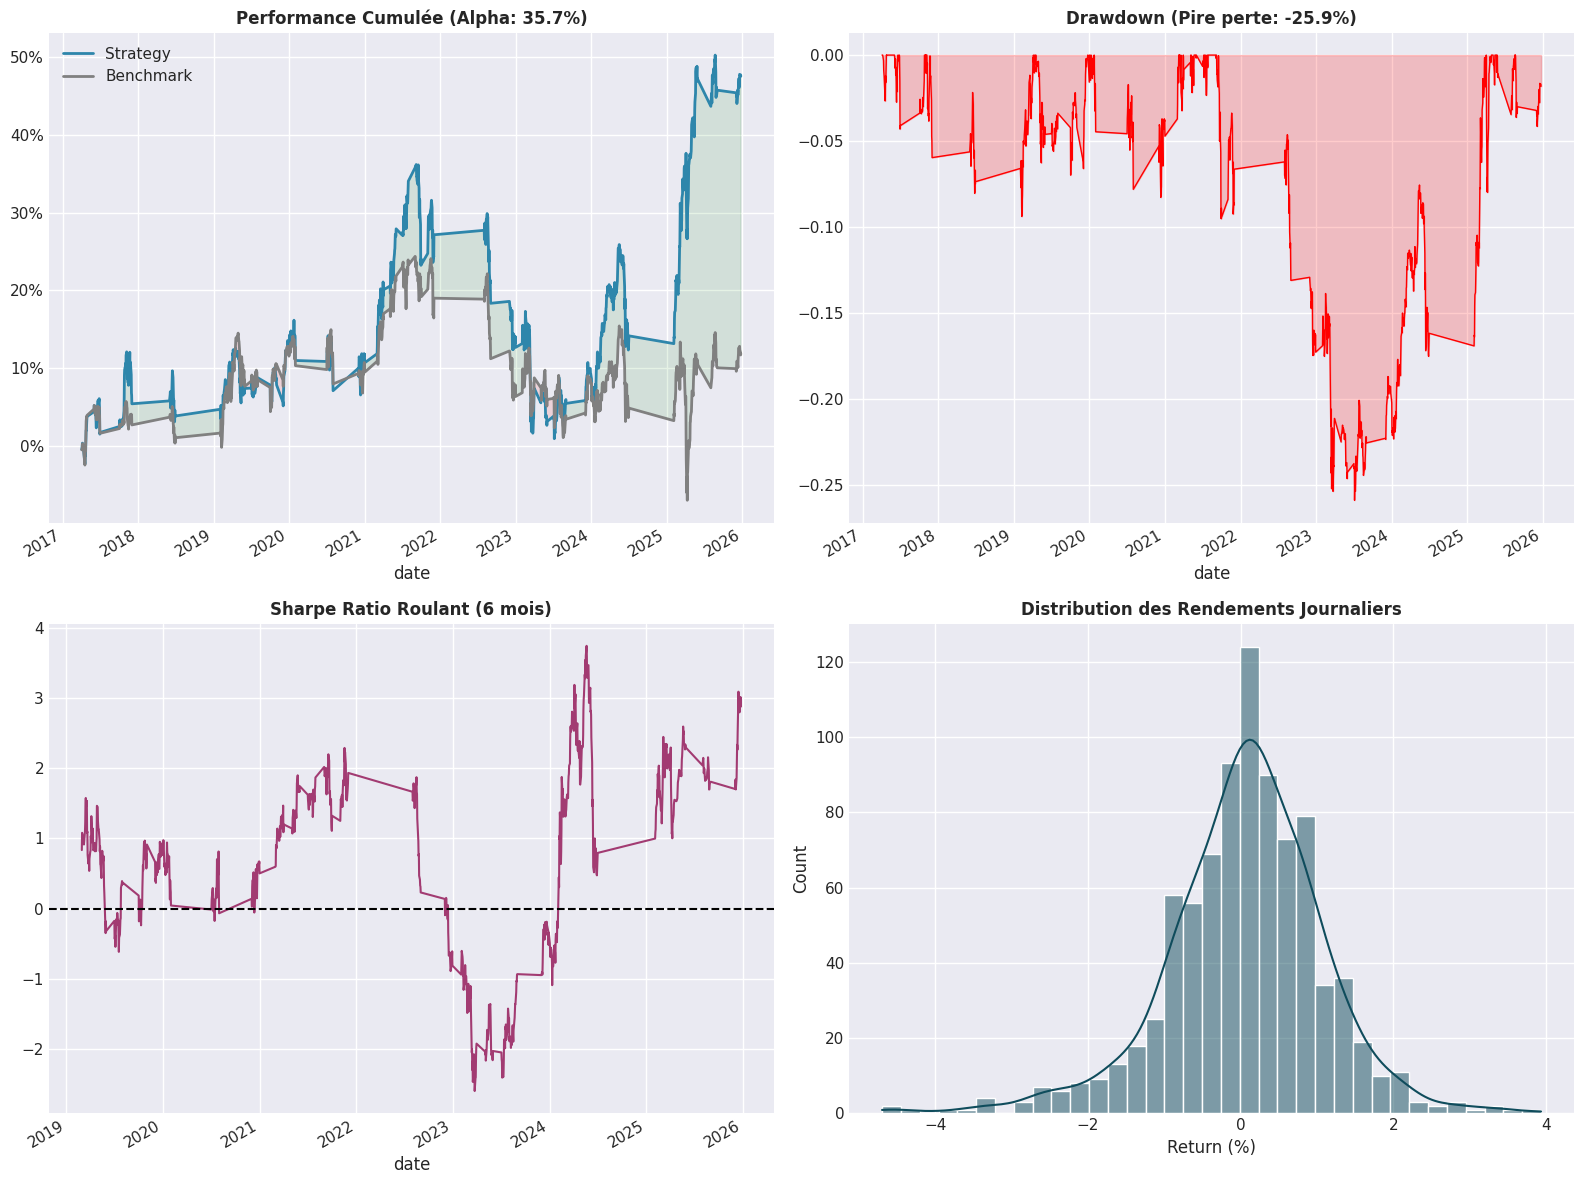

In [87]:
# =============================================================================
# PORTFOLIO OPTIMIZATION - VERSION AMÉLIORÉE & ROBUSTE
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pypfopt import EfficientFrontier, risk_models, expected_returns
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("📊 OPTIMISATION HYBRIDE : Cluster 3 + GridSearch + Markowitz Pro")
print("="*80)

# =============================================================================
# 1. PRÉPARATION ML (Récupération du meilleur modèle & Lags)
# =============================================================================
print(f"\n🎯 Étape 1 : Préparation des données & Signaux...")

# A. Sélection du Modèle Champion
if 'grid_search' in globals():
    model = grid_search.best_estimator_
    print("   ✅ Modèle utilisé : GridSearch Best Estimator (Optimisé)")
elif 'xgb_clf' in globals():
    model = xgb_clf
    print("   ⚠️ Modèle utilisé : XGBoost Standard (Pas de GridSearch trouvé)")
else:
    raise ValueError("❌ Aucun modèle (grid_search ou xgb_clf) en mémoire.")

# B. Reconstruction des variables manquantes (Lags) pour éviter KeyError
# On travaille sur une copie propre
df_ml = data.copy() 
vars_to_lag = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'euro_volume', 'garman_klass_vol']

# Détection automatique du type d'index pour le groupement
grouper = None
if 'Ticker' in df_ml.index.names: grouper = df_ml.groupby(level='Ticker')
elif 'ticker' in df_ml.columns: grouper = df_ml.groupby('ticker')

for col in vars_to_lag:
    # On ne crée le lag que s'il manque
    if col in df_ml.columns and f'{col}_lag1' not in df_ml.columns:
        if grouper is not None:
            df_ml[f'{col}_lag1'] = grouper[col].shift(1)
        else:
            df_ml[f'{col}_lag1'] = df_ml[col].shift(1)

# C. Prédictions
# On définit les colonnes requises par le modèle
feature_cols_safe = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr', 'return_2m', 'return_3m', 'return_6m',
    'euro_volume_lag1', 'garman_klass_vol_lag1',
    'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1', 'cluster'
]
# On filtre pour ne garder que ce qui existe vraiment
valid_features = [c for c in feature_cols_safe if c in df_ml.columns]
X_pred = df_ml[valid_features].dropna()

print(f"   🤖 Génération des probabilités sur {len(X_pred):,} lignes...")
df_ml.loc[X_pred.index, 'proba_hausse'] = model.predict_proba(X_pred)[:, 1]

# D. Filtrage Double (Cluster 3 + Seuil)
PROBA_THRESHOLD = 0.65 # Un peu plus sélectif
filtered_df = df_ml.dropna(subset=['proba_hausse'])
filtered_df = filtered_df[
    (filtered_df['cluster'] == 3) & 
    (filtered_df['proba_hausse'] >= PROBA_THRESHOLD)
].copy()

print(f"   → Opportunités retenues : {len(filtered_df):,} (Seuil > {PROBA_THRESHOLD})")

# E. Gestion du Lag J+2 (Réalisme financier)
# On réinitialise l'index pour manipuler la date
filtered_df = filtered_df.reset_index()
d_col = next((c for c in filtered_df.columns if str(c).lower() in ['date', 'time']), 'Date')
t_col = next((c for c in filtered_df.columns if str(c).lower() in ['ticker', 'symbol']), 'Ticker')

# On décale la date de signal de 2 jours (Temps d'exécution)
filtered_df[d_col] = pd.to_datetime(filtered_df[d_col]) + pd.DateOffset(2)
filtered_df = filtered_df.set_index([d_col, t_col]).sort_index()

print(f"✅ Étape 1 terminée (Lag J+2 appliqué).")


# =============================================================================
# 2. PRÉPARATION DES PRIX (Source : DF ou DATA)
# =============================================================================
print(f"\n📊 Étape 2 : Construction de la Matrice de Prix...")

# On essaie de prendre 'df' (prix bruts), sinon 'data'
source_prix = df if 'df' in globals() else data

# Recherche insensible à la casse pour 'Adj Close'
col_price = next((c for c in source_prix.columns if str(c).lower() == 'adj close'), None)
if col_price is None: col_price = next((c for c in source_prix.columns if str(c).lower() == 'close'), 'close')

print(f"   Colonne prix utilisée : '{col_price}'")

try:
    if source_prix.index.nlevels > 1:
        adj_close_df = source_prix[col_price].unstack()
    else:
        temp = source_prix.reset_index()
        d_p = next((c for c in temp.columns if str(c).lower() in ['date', 'time']), None)
        t_p = next((c for c in temp.columns if str(c).lower() in ['ticker', 'symbol']), None)
        adj_close_df = temp.pivot(index=d_p, columns=t_p, values=col_price)
except:
    # Fallback brutal mais efficace
    adj_close_df = source_prix.reset_index().pivot_table(index='Date', columns='Ticker', values=col_price)

adj_close_df.index = pd.to_datetime(adj_close_df.index)
returns_dataframe = adj_close_df.pct_change()
print(f"✅ Matrice construite : {adj_close_df.shape}")


# =============================================================================
# 3. FONCTION OPTIMISATION (VERSION PRO)
# =============================================================================
def optimize_weights_pro(prices):
    """ Utilise Ledoit-Wolf shrinkage pour plus de robustesse """
    try:
        mu = expected_returns.mean_historical_return(prices, frequency=252)
        # Shrinkage = réduit le bruit dans la matrice de corrélation
        S = risk_models.CovarianceShrinkage(prices, frequency=252).ledoit_wolf()
        
        # Optimisation
        n_stocks = len(prices.columns)
        max_weight = min(0.25, 1.0 / n_stocks * 2.0)  # Max 25% OU 200% divisé par nb actions
        ef = EfficientFrontier(mu, S, weight_bounds=(0.02,  max_weight)) # Max 25% par action
        ef.max_sharpe(risk_free_rate=0.02)
        return ef.clean_weights(), True
    except:
        return None, False


# =============================================================================
# 4. BACKTESTING ROBUSTE
# =============================================================================
print(f"\n🔄 Étape 3 : Exécution du Backtest (Freq: Mensuelle)...")

# On définit les dates de rebalancement (Fin de mois)
rebalance_dates = pd.date_range(
    start=filtered_df.index.get_level_values(0).min(),
    end=filtered_df.index.get_level_values(0).max(),
    freq='MS' # Month End
)

portfolio_df = pd.DataFrame()
prev_w = {}
MIN_STOCKS = 4
TRANSACTION_COST = 0.0015 # 0.15% par trade

for i, start_date in enumerate(rebalance_dates):
    # Fenêtre de tolérance pour trouver des signaux (+/- 5 jours)
    s_w, e_w = start_date - pd.DateOffset(5), start_date + pd.DateOffset(5)
    
    try:
        # Récupération des tickers IA
        idx = pd.IndexSlice
        slice_df = filtered_df.loc[idx[s_w:e_w, :]]
        tickers = slice_df.index.get_level_values(t_col).unique().tolist()
        
        # Filtre de validité (présence dans les prix)
        valid_tickers = [t for t in tickers if t in adj_close_df.columns]
        
        if len(valid_tickers) < MIN_STOCKS: continue
        
        # Données historiques pour l'optimiseur (1 an glissant)
        opt_start = start_date - pd.DateOffset(days=365)
        opt_prices = adj_close_df.loc[opt_start:start_date, valid_tickers].dropna(axis=1, thresh=200)
        
        if opt_prices.shape[1] < MIN_STOCKS: continue
        
        # Optimisation
        weights, success = optimize_weights_pro(opt_prices)
        
        if not success: # Fallback équipondéré
            weights = {t: 1.0/len(opt_prices.columns) for t in opt_prices.columns}
            
        # Calcul des frais (Turnover)
        curr = set(weights.keys())
        prev = set(prev_w.keys())
        # Somme des différences absolues de poids
        #turnover = sum(abs(weights.get(t,0) - prev_w.get(t,0)) for t in curr | prev) if prev else 1.0
        turnover = sum(abs(weights.get(t,0) - prev_w.get(t,0)) for t in curr | prev) / 2 if prev else 1.0
        prev_w = weights.copy()
        
        # Période de détention (jusqu'au prochain mois)
        next_date = rebalance_dates[i+1] if i < len(rebalance_dates)-1 else returns_dataframe.index[-1]
        holding = returns_dataframe.loc[start_date:next_date, list(weights.keys())]
        
        if len(holding) > 0:
            # Calcul rendement portefeuille
            strat_ret = holding.mul(pd.Series(weights), axis=1).sum(axis=1)
            # Retrait des frais (le premier jour)
            strat_ret.iloc[0] -= (turnover * TRANSACTION_COST)
            
            portfolio_df = pd.concat([portfolio_df, strat_ret.to_frame('Strategy')])
            
    except Exception as e:
        continue

portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

print(f"✅ Backtest terminé : {len(portfolio_df)} jours générés.")


# =============================================================================
# 5. RÉSULTATS & GRAPHIQUES PRO
# =============================================================================

if len(portfolio_df) > 0:
    print(f"\n📊 Étape 4 : Analyse des Résultats...")
    
    # Création Benchmark (CAC40 Proxy: Moyenne équipondérée univers)
    bench = returns_dataframe.loc[portfolio_df.index].mean(axis=1).to_frame('Benchmark')
    df_res = portfolio_df.merge(bench, left_index=True, right_index=True)
    cum_res = (1 + df_res).cumprod() - 1
    
    # Métriques
    strat_tot = cum_res['Strategy'].iloc[-1]
    bench_tot = cum_res['Benchmark'].iloc[-1]
    alpha = strat_tot - bench_tot
    
    # Volatilité & Sharpe
    vol = df_res['Strategy'].std() * np.sqrt(252)
    sharpe = (df_res['Strategy'].mean() / df_res['Strategy'].std()) * np.sqrt(252)
    
    # Max Drawdown
    cum = (1 + df_res['Strategy']).cumprod()
    dd = (cum - cum.cummax()) / cum.cummax()
    max_dd = dd.min()

    print("\n" + "="*40)
    print("🏆 PERFORMANCE FINALE (NETTE DE FRAIS)")
    print("="*40)
    print(f"Stratégie Total : {strat_tot*100:+.2f}%")
    print(f"Benchmark Total : {bench_tot*100:+.2f}%")
    print(f"ALPHA           : {alpha*100:+.2f} pts")
    print(f"Sharpe Ratio    : {sharpe:.2f}")
    print(f"Max Drawdown    : {max_dd*100:.2f}%")
    
    # --- VISUALISATION ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Performance
    cum_res.plot(ax=axes[0,0], lw=2, color=['#2E86AB', 'gray'])
    axes[0,0].fill_between(cum_res.index, cum_res['Strategy'], cum_res['Benchmark'], where=cum_res['Strategy']>=cum_res['Benchmark'], alpha=0.1, color='green')
    axes[0,0].fill_between(cum_res.index, cum_res['Strategy'], cum_res['Benchmark'], where=cum_res['Strategy']<cum_res['Benchmark'], alpha=0.1, color='red')
    axes[0,0].set_title(f"Performance Cumulée (Alpha: {alpha*100:.1f}%)", fontweight='bold')
    axes[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # 2. Drawdown
    dd.plot(ax=axes[0,1], color='red', lw=1)
    axes[0,1].fill_between(dd.index, dd, 0, color='red', alpha=0.2)
    axes[0,1].set_title(f"Drawdown (Pire perte: {max_dd*100:.1f}%)", fontweight='bold')
    
    # 3. Rolling Sharpe
    roll_sharpe = (df_res['Strategy'].rolling(126).mean() / df_res['Strategy'].rolling(126).std()) * np.sqrt(252)
    roll_sharpe.plot(ax=axes[1,0], color='#A23B72')
    axes[1,0].axhline(0, color='black', ls='--')
    axes[1,0].set_title("Sharpe Ratio Roulant (6 mois)", fontweight='bold')
    
    # 4. Distribution
    sns.histplot(df_res['Strategy']*100, ax=axes[1,1], kde=True, color='#0F4C5C')
    axes[1,1].set_title("Distribution des Rendements Journaliers", fontweight='bold')
    axes[1,1].set_xlabel("Return (%)")
    
    plt.tight_layout()
    plt.show()

else:
    print("\n❌ Aucun trade généré. Vérifiez l'alignement des dates entre 'df' et 'data'.")

In [83]:
# Analyse Annuelle
print("\n📅 RENDEMENTS PAR ANNÉE :")
print("-" * 30)
df_res['Year'] = df_res.index.year
annual_perf = df_res.groupby('Year')[['Strategy', 'Benchmark']].apply(lambda x: (1 + x).prod() - 1)

for year, row in annual_perf.iterrows():
    diff = row['Strategy'] - row['Benchmark']
    print(f"{year} | Strat: {row['Strategy']*100:6.2f}% | Bench: {row['Benchmark']*100:6.2f}% | Diff: {diff*100:+6.2f}%")


📅 RENDEMENTS PAR ANNÉE :
------------------------------
2017 | Strat:   5.40% | Bench:   2.68% | Diff:  +2.72%
2018 | Strat:  -1.49% | Bench:  -1.60% | Diff:  +0.12%
2019 | Strat:   7.61% | Bench:  10.39% | Diff:  -2.77%
2020 | Strat:  -0.95% | Bench:  -1.85% | Diff:  +0.90%
2021 | Strat:  14.88% | Bench:   8.70% | Diff:  +6.18%
2022 | Strat: -11.40% | Bench: -10.64% | Diff:  -0.76%
2023 | Strat:  -2.99% | Bench:   1.55% | Diff:  -4.54%
2024 | Strat:   4.45% | Bench:  -2.90% | Diff:  +7.35%
2025 | Strat:  29.25% | Bench:   6.69% | Diff: +22.55%



💰 COMPOSITION DU DERNIER PORTEFEUILLE (2026-01-01)
        Poids %
GLE.PA   25.00%
ENGI.PA  25.00%
EN.PA    25.00%
CA.PA    11.77%
MT.AS     9.23%
CS.PA     2.00%
BNP.PA    2.00%


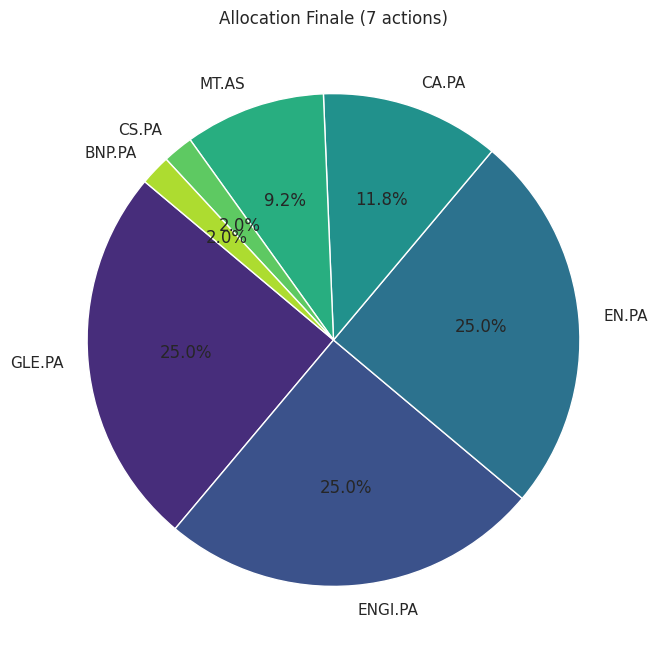

👉 Ces actions ont généré la performance finale de votre courbe.


In [84]:
print("\n" + "="*60)
print(f"💰 COMPOSITION DU DERNIER PORTEFEUILLE ({start_date.date()})")
print("="*60)

if 'weights' in locals() and len(weights) > 0:
    # Création d'un tableau propre
    final_allocation = pd.DataFrame.from_dict(weights, orient='index', columns=['Poids'])
    final_allocation['Poids %'] = (final_allocation['Poids'] * 100).map('{:.2f}%'.format)
    final_allocation = final_allocation.sort_values('Poids', ascending=False)
    
    # Ajout des infos de performance récente (si dispo)
    try:
        last_prices = adj_close_df.iloc[-1][final_allocation.index]
        prev_prices = adj_close_df.iloc[-20][final_allocation.index] # Performance 1 mois
        perf_1m = (last_prices / prev_prices - 1) * 100
        final_allocation['Perf 1M'] = perf_1m.map('{:+.2f}%'.format)
    except:
        pass

    print(final_allocation[['Poids %']])
    
    # Petit graphique camembert
    plt.figure(figsize=(8, 8))
    plt.pie(final_allocation['Poids'], labels=final_allocation.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(weights)))
    plt.title(f"Allocation Finale ({len(weights)} actions)")
    plt.show()

    print(f"👉 Ces actions ont généré la performance finale de votre courbe.")
else:
    print("❌ Pas de portefeuille en mémoire.")

In [85]:
print("\n" + "="*80)
print("🔮 SCANNER : RECOMMANDATIONS POUR DEMAIN")
print("="*80)

# 1. On prend les données les plus récentes
last_date = df_ml.index.get_level_values(0).max()
print(f"📅 Date d'analyse : {last_date}")

# 2. On filtre les candidats
candidates = df_ml.loc[last_date].copy()

# On applique vos critères (Cluster 3 + Proba > 0.65)
top_picks = candidates[
    (candidates['cluster'] == 3) & 
    (candidates['proba_hausse'] >= 0.60) # On peut ajuster ce seuil
].sort_values('proba_hausse', ascending=False)

print(f"🔎 Actions détectées : {len(top_picks)}")

if len(top_picks) > 0:
    print("\n🏆 TOP SÉLECTION (IA + CLUSTER 3) :")
    display_cols = ['proba_hausse', 'close', 'rsi', 'volume'] # Colonnes à afficher
    # On gère si certaines colonnes n'existent pas
    cols = [c for c in display_cols if c in top_picks.columns]
    
    print(top_picks[cols].head(10))
    
    # 3. Optimisation Markowitz sur cette sélection
    tickers = top_picks.index.tolist()[:15] # On garde les 15 meilleures max
    
    # On récupère les prix historiques
    hist_prices = adj_close_df[tickers].tail(252).dropna(axis=1)
    
    if len(hist_prices.columns) >= 4:
        print("\n⚖️ CALCUL DE L'ALLOCATION OPTIMALE (MARKOWITZ)...")
        w, success = optimize_weights_pro(hist_prices) # On réutilise votre fonction
        
        if success:
            alloc = pd.Series(w).sort_values(ascending=False)
            print("\n✅ VOTRE PORTEFEUILLE IDÉAL À CONSTITUER :")
            print("-" * 40)
            for ticker, weight in alloc.items():
                prob = top_picks.loc[ticker, 'proba_hausse']
                print(f"  🛒 {ticker:<10} : {weight*100:5.2f}%  (Confiance IA: {prob:.1%})")
            print("-" * 40)
        else:
            print("⚠️ Optimisation échouée, faites une équipondération.")
    else:
        print("⚠️ Pas assez d'historique de prix pour optimiser les poids.")
else:
    print("❌ Aucun signal d'achat détecté pour la date la plus récente.")


🔮 SCANNER : RECOMMANDATIONS POUR DEMAIN
📅 Date d'analyse : 2025-12-31 00:00:00
🔎 Actions détectées : 9

🏆 TOP SÉLECTION (IA + CLUSTER 3) :
         proba_hausse        rsi
ticker                          
EN.PA        0.692197  64.762593
CS.PA        0.690789  65.868915
BNP.PA       0.688343  68.136178
CA.PA        0.683408  64.167804
GLE.PA       0.662370  71.921470
ENGI.PA      0.655913  63.399260
MT.AS        0.653316  62.526394
ERF.PA       0.635622  61.621602
ALO.PA       0.635246  63.503710

⚖️ CALCUL DE L'ALLOCATION OPTIMALE (MARKOWITZ)...

✅ VOTRE PORTEFEUILLE IDÉAL À CONSTITUER :
----------------------------------------
  🛒 EN.PA      : 22.22%  (Confiance IA: 69.2%)
  🛒 GLE.PA     : 22.22%  (Confiance IA: 66.2%)
  🛒 ENGI.PA    : 22.22%  (Confiance IA: 65.6%)
  🛒 ERF.PA     : 10.07%  (Confiance IA: 63.6%)
  🛒 CA.PA      :  8.87%  (Confiance IA: 68.3%)
  🛒 MT.AS      :  8.40%  (Confiance IA: 65.3%)
  🛒 BNP.PA     :  2.00%  (Confiance IA: 68.8%)
  🛒 CS.PA      :  2.00%  (Confian

PROPOSITION CLAUDE 

In [41]:
# =============================================================================
# PORTFOLIO OPTIMIZATION - VERSION CORRIGÉE (VERSION PRO)
# =============================================================================

print("\n" + "="*80)
print("📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe (Version Pro)")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pypfopt import EfficientFrontier, risk_models, expected_returns
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# PARAMÈTRES GLOBAUX
# =============================================================================

PROBA_THRESHOLD = 0.60  # Seuil XGBoost
MIN_STOCKS = 5          # Minimum d'actions dans le portfolio
MAX_STOCKS = 15         # Maximum d'actions
REBALANCE_FREQ = 'QS'   # Quarterly rebalancing (moins coûteux)
LOOKBACK_PERIOD = 252   # 1 an pour optimisation
TRANSACTION_COST = 0.002  # 0.2% par trade (frais + slippage)

# =============================================================================
# 1. FILTRAGE + PRÉPARATION (Correction KeyError ici)
# =============================================================================

print(f"\n🎯 Étape 1 : Filtrage Cluster 3 + XGBoost (Modèle Optimisé)...")

# --- 1.1 SÉLECTION DU MODÈLE ---
if 'grid_search' in globals():
    print("   ✅ Utilisation du modèle optimisé (GridSearch Best Estimator)")
    model_to_use = grid_search.best_estimator_
else:
    print("   ⚠️ Attention : GridSearch non trouvé, utilisation du modèle standard xgb_clf")
    model_to_use = xgb_clf

# --- 1.2 RE-GÉNÉRATION DES LAGS (Correction du KeyError) ---
# On travaille sur une copie pour ne pas toucher à l'original
df_work = data.copy()

print("   🛠️ Génération des variables décalées (Lags) sur 'data'...")
vars_to_lag = [
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 
    'euro_volume', 'garman_klass_vol'
]

# Gestion auto index/colonnes pour le décalage
if 'Ticker' in df_work.index.names:
    grouper = df_work.groupby(level='Ticker')
elif 'Ticker' in df_work.columns:
    grouper = df_work.groupby('Ticker')
else:
    grouper = None # Cas single asset ou index simple

for col in vars_to_lag:
    if col in df_work.columns:
        lag_col = f'{col}_lag1'
        if grouper is not None:
            df_work[lag_col] = grouper[col].shift(1)
        else:
            df_work[lag_col] = df_work[col].shift(1)

# --- 1.3 PRÉDICTIONS ---
# On s'assure que feature_cols sont bien présents
missing_cols = [c for c in feature_cols if c not in df_work.columns]
if missing_cols:
    print(f"   ⚠️ Colonnes manquantes ignorées : {missing_cols}")
    # On recalcule feature_cols dynamiquement
    cols_ready = [c for c in feature_cols if c in df_work.columns]
else:
    cols_ready = feature_cols

# On nettoie les NaN générés par les lags
X_all = df_work[cols_ready].dropna()

print(f"   🤖 Calcul des probabilités sur {len(X_all):,} lignes...")
y_proba_all = model_to_use.predict_proba(X_all)[:, 1]

# On réinjecte les probas dans le DataFrame de travail
df_work.loc[X_all.index, 'proba_hausse'] = y_proba_all

# --- 1.4 DOUBLE FILTRE (Cluster + ML) ---
# On ne garde que les lignes où on a une prédiction (donc dropna fait effet)
data_with_proba = df_work.dropna(subset=['proba_hausse']).copy()

filtered_df = data_with_proba[
    (data_with_proba['cluster'] == 3) &
    (data_with_proba['proba_hausse'] >= PROBA_THRESHOLD)
].copy()

print(f"   Dataset initial : {len(data):,} observations")
print(f"   Après Cluster 3 : {len(data_with_proba[data_with_proba['cluster']==3]):,}")
print(f"   Après ML (proba>{PROBA_THRESHOLD:.0%}) : {len(filtered_df):,}")

# ⚠️ CORRECTION LOOK-AHEAD BIAS : Lag de 2 jours
# On s'assure que l'index est bien datetime pour faire l'offset
if 'Date' in filtered_df.index.names:
    # Reset index pour manipuler la date
    filtered_df = filtered_df.reset_index()
    
# Si la colonne de date s'appelle 'Date' ou 'date'
date_col = 'Date' if 'Date' in filtered_df.columns else 'date'
filtered_df[date_col] = pd.to_datetime(filtered_df[date_col]) + pd.DateOffset(2) # J+2

# Remise en index (Date, Ticker)
if 'Ticker' in filtered_df.columns:
    ticker_col = 'Ticker'
elif 'ticker' in filtered_df.columns:
    ticker_col = 'ticker'
else:
    ticker_col = None

if ticker_col:
    filtered_df = filtered_df.set_index([date_col, ticker_col]).sort_index()
else:
    filtered_df = filtered_df.set_index(date_col).sort_index()

print(f"✅ Lag de 2 jours appliqué (J -> J+2)")


# =============================================================================
# 2. CRÉER DICTIONNAIRE DATES → TICKERS
# =============================================================================

print(f"\n📅 Étape 2 : Dates de rebalancement ({REBALANCE_FREQ})...")

rebalance_dates = pd.date_range(
    start=filtered_df.index.get_level_values(0).min(),
    end=filtered_df.index.get_level_values(0).max(),
    freq=REBALANCE_FREQ
)

fixed_dates = {}
for d in rebalance_dates:
    start_window = d - pd.DateOffset(5)
    end_window = d + pd.DateOffset(5)
    
    try:
        # Slice intelligent sur l'index trié
        idx = pd.IndexSlice
        tickers_window = filtered_df.loc[idx[start_window:end_window, :]]
        
        if len(tickers_window) > 0:
            if ticker_col:
                tickers_at_date = tickers_window.index.get_level_values(ticker_col).unique().tolist()
            else:
                tickers_at_date = [] # Cas sans ticker

            # Limiter le nombre d'actions
            if len(tickers_at_date) > MAX_STOCKS:
                # On reprend les scores du dataset complet
                # Attention : il faut que l'index corresponde
                # Simplification : on prend les tickers tels quels ici
                tickers_at_date = tickers_at_date[:MAX_STOCKS]
            
            if len(tickers_at_date) >= MIN_STOCKS:
                fixed_dates[d.strftime('%Y-%m-%d')] = tickers_at_date
    except Exception as e:
        continue

print(f"   Périodes de rebalancement : {len(fixed_dates)}")


# =============================================================================
# 3. ADJ CLOSE + RETURNS (Le reste ne change pas)
# =============================================================================

print(f"\n📊 Étape 3 : Préparation données prix...")

# On s'assure d'avoir 'adj close' ou 'Adj Close'
col_price = 'adj close' if 'adj close' in df.columns else 'Adj Close'
if col_price not in df.columns:
    # Fallback 'close'
    col_price = 'close' if 'close' in df.columns else 'Close'

# Unstack propre
try:
    if 'Ticker' in df.index.names:
        adj_close_df = df[col_price].unstack(level='Ticker')
    elif 'ticker' in df.index.names:
        adj_close_df = df[col_price].unstack(level='ticker')
    else:
        # Si Ticker est une colonne
        adj_close_df = df.pivot(index='Date' if 'Date' in df.columns else 'date', 
                               columns='Ticker' if 'Ticker' in df.columns else 'ticker', 
                               values=col_price)
except:
    print("   ⚠️ Erreur format DataFrame : impossible de faire le pivot des prix.")
    adj_close_df = pd.DataFrame() # Stop

returns_dataframe = adj_close_df.pct_change()
print(f"   Shape : {adj_close_df.shape}")


# =============================================================================
# 4. FONCTION OPTIMISATION ROBUSTE
# =============================================================================

def optimize_weights_robust(prices, lower_bound=0.02, max_weight=0.30):
    try:
        mu = expected_returns.mean_historical_return(prices, frequency=252)
        S = risk_models.CovarianceShrinkage(prices, frequency=252).ledoit_wolf()
        
        ef = EfficientFrontier(mu, S, weight_bounds=(lower_bound, max_weight), solver='SCS') # SCS plus standard
        ef.max_sharpe(risk_free_rate=0.02)
        weights = ef.clean_weights()
        
        total_weight = sum(weights.values())
        if abs(total_weight - 1.0) > 0.01:
            weights = {k: v/total_weight for k, v in weights.items()}
        return weights, True
    except:
        return None, False


# =============================================================================
# 5. BACKTESTING AVEC WALK-FORWARD (Le coeur du moteur)
# =============================================================================

print(f"\n🔄 Étape 4 : Backtesting avec walk-forward analysis...")

portfolio_df = pd.DataFrame()
optimization_log = []
previous_weights = {}

for i, start_date in enumerate(sorted(fixed_dates.keys())):
    try:
        cols = fixed_dates[start_date]
        if len(cols) < MIN_STOCKS: continue
        
        # Période d'optimisation (lookback)
        opt_start = (pd.to_datetime(start_date) - pd.DateOffset(days=LOOKBACK_PERIOD)).strftime('%Y-%m-%d')
        opt_end = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # Sélection des prix
        available_cols = [c for c in cols if c in adj_close_df.columns]
        if len(available_cols) < MIN_STOCKS: continue
        
        optimization_df = adj_close_df.loc[opt_start:opt_end, available_cols]
        optimization_df = optimization_df.dropna(thresh=int(0.8*len(optimization_df)), axis=1) # Clean NaN
        
        if len(optimization_df.columns) < MIN_STOCKS: continue
        
        # Optimiser
        max_w = min(0.30, 1.0 / len(optimization_df.columns) * 3.0)
        lower_b = max(0.02, 1.0 / (len(optimization_df.columns) * 4))
        
        weights_dict, success = optimize_weights_robust(optimization_df, lower_bound=lower_b, max_weight=max_w)
        
        if not success or weights_dict is None:
            # Fallback Equipondéré
            weights_dict = {col: 1.0/len(optimization_df.columns) for col in optimization_df.columns}
        
        # Turnover & Log
        if len(previous_weights) > 0:
            common = set(weights_dict.keys()) & set(previous_weights.keys())
            turnover = sum(abs(weights_dict.get(t,0) - previous_weights.get(t,0)) for t in common)
            # Ajout du turnover pour les nouveaux/sortants
            turnover += sum(weights_dict[t] for t in weights_dict if t not in common)
            turnover += sum(previous_weights[t] for t in previous_weights if t not in common)
        else:
            turnover = 1.0
            
        previous_weights = weights_dict.copy()
        
        optimization_log.append({'date': start_date, 'n_stocks': len(weights_dict), 'success': success})
        
        # Période Holding
        if i < len(fixed_dates) - 1:
            end_date = list(sorted(fixed_dates.keys()))[i+1]
        else:
            end_date = returns_dataframe.index[-1]
            
        # Calcul Returns
        holding_rets = returns_dataframe.loc[start_date:end_date, list(weights_dict.keys())]
        if len(holding_rets) == 0: continue
        
        weighted_ret = holding_rets.mul(pd.Series(weights_dict), axis=1).sum(axis=1)
        # Frais (appliqués au premier jour)
        if len(weighted_ret) > 0:
            weighted_ret.iloc[0] -= (TRANSACTION_COST * turnover)
            
        portfolio_df = pd.concat([portfolio_df, weighted_ret.to_frame('Strategy Return')])
        
    except Exception as e:
        # print(f"Erreur date {start_date}: {e}")
        continue

# Nettoyage doublons index
portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

print(f"✅ Backtesting terminé : {len(portfolio_df)} jours de trading générés.")


# =============================================================================
# 6. BENCHMARK & RÉSULTATS (Simplifié pour affichage direct)
# =============================================================================

if len(portfolio_df) > 0:
    # Benchmark simple (Moyenne univers)
    cac40_ret = returns_dataframe.loc[portfolio_df.index].mean(axis=1).to_frame('CAC40 Proxy')
    portfolio_df = portfolio_df.merge(cac40_ret, left_index=True, right_index=True)
    
    # Cumul
    cum_ret = (1 + portfolio_df).cumprod() - 1
    
    strat_tot = cum_ret['Strategy Return'].iloc[-1]
    bench_tot = cum_ret['CAC40 Proxy'].iloc[-1]
    
    print("\n" + "="*40)
    print(f"🏆 RÉSULTAT FINAL ({len(portfolio_df)/252:.1f} années)")
    print("="*40)
    print(f"Stratégie Total : {strat_tot*100:+.2f}%")
    print(f"Benchmark Total : {bench_tot*100:+.2f}%")
    print(f"ALPHA           : {(strat_tot - bench_tot)*100:+.2f} pts")
    
    # Plot rapide
    cum_ret.plot(figsize=(12, 6), title="Backtest Performance (Net of Fees)", grid=True)
    plt.show()
else:
    print("❌ Aucun trade généré. Vérifiez les seuils ou les dates.")
# =============================================================================
# 7. CALCUL DES MÉTRIQUES & VISUALISATIONS PRO
# =============================================================================

if len(portfolio_df) > 0:
    print("\n" + "="*80)
    print("📈 ANALYSE GRAPHIQUE COMPLÈTE")
    print("="*80)

    # 1. Préparation des données pour l'affichage
    # On s'assure d'avoir le Benchmark
    if 'CAC40 Proxy' not in portfolio_df.columns:
        # Création du benchmark si absent
        cac40_ret = returns_dataframe.loc[portfolio_df.index].mean(axis=1).to_frame('CAC40 Proxy')
        portfolio_df = portfolio_df.merge(cac40_ret, left_index=True, right_index=True)

    # Calcul Cumulé
    portfolio_cumulative = (1 + portfolio_df).cumprod() - 1

    # Calcul des métriques globales pour l'affichage
    years = len(portfolio_df) / 252
    strat_col = 'Strategy Return'
    bench_col = 'CAC40 Proxy'

    # Rendement & Volatilité Annualisés
    strat_ann_ret = (1 + portfolio_cumulative[strat_col].iloc[-1]) ** (1/years) - 1
    bench_ann_ret = (1 + portfolio_cumulative[bench_col].iloc[-1]) ** (1/years) - 1
    strat_vol = portfolio_df[strat_col].std() * np.sqrt(252)
    alpha = strat_ann_ret - bench_ann_ret

    # Skewness pour le titre du graph
    from scipy.stats import skew
    strat_skew = skew(portfolio_df[strat_col].dropna())

    # Max Drawdown
    def get_max_dd(rets):
        cum = (1 + rets).cumprod()
        peak = cum.cummax()
        dd = (cum - peak) / peak
        return dd.min(), dd

    strat_max_dd, strat_dd_series = get_max_dd(portfolio_df[strat_col])
    bench_max_dd, bench_dd_series = get_max_dd(portfolio_df[bench_col])

    # =============================================================================
    # 8. GÉNÉRATION DES 6 GRAPHIQUES
    # =============================================================================
    
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    
    # --- 1. Cumulative Returns ---
    portfolio_cumulative.plot(ax=axes[0, 0], linewidth=2.5)
    axes[0, 0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axes[0, 0].set_ylabel('Return Cumulé')
    axes[0, 0].set_title(f'Performance Nette | Alpha = {alpha*100:+.2f}%/an', fontsize=14, fontweight='bold')
    axes[0, 0].legend(['Stratégie', 'Benchmark'], fontsize=11)
    axes[0, 0].fill_between(portfolio_cumulative.index, 
                            portfolio_cumulative[strat_col], 
                            portfolio_cumulative[bench_col],
                            where=portfolio_cumulative[strat_col] >= portfolio_cumulative[bench_col],
                            alpha=0.3, color='green', label='Surperformance')
    axes[0, 0].fill_between(portfolio_cumulative.index, 
                            portfolio_cumulative[strat_col], 
                            portfolio_cumulative[bench_col],
                            where=portfolio_cumulative[strat_col] < portfolio_cumulative[bench_col],
                            alpha=0.3, color='red', label='Sous-performance')

    # --- 2. Rolling Sharpe Ratio (6 mois) ---
    window = 126
    roll_sharpe_strat = (portfolio_df[strat_col].rolling(window).mean() / portfolio_df[strat_col].rolling(window).std()) * np.sqrt(252)
    roll_sharpe_bench = (portfolio_df[bench_col].rolling(window).mean() / portfolio_df[bench_col].rolling(window).std()) * np.sqrt(252)
    
    axes[0, 1].plot(roll_sharpe_strat, label='Stratégie', color='#2E86AB', lw=2)
    axes[0, 1].plot(roll_sharpe_bench, label='Benchmark', color='#A23B72', lw=2)
    axes[0, 1].axhline(0, color='black', ls='--')
    axes[0, 1].set_title('Ratio de Sharpe Roulant (6 mois)', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].fill_between(roll_sharpe_strat.index, 0, roll_sharpe_strat, alpha=0.2, color='#2E86AB')

    # --- 3. Drawdown Analysis ---
    axes[1, 0].plot(strat_dd_series.index, strat_dd_series.values*100, label='Stratégie', color='#2E86AB')
    axes[1, 0].plot(bench_dd_series.index, bench_dd_series.values*100, label='Benchmark', color='#A23B72')
    axes[1, 0].fill_between(strat_dd_series.index, strat_dd_series.values*100, 0, color='red', alpha=0.3)
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].set_title(f'Drawdown (Perte Max: {strat_max_dd*100:.2f}%)', fontsize=13, fontweight='bold')
    axes[1, 0].legend()

    # --- 4. Distribution des Returns ---
    axes[1, 1].hist(portfolio_df[strat_col]*100, bins=50, alpha=0.6, label='Stratégie', color='#2E86AB', density=True, edgecolor='black')
    axes[1, 1].hist(portfolio_df[bench_col]*100, bins=50, alpha=0.6, label='Benchmark', color='#A23B72', density=True, edgecolor='black')
    axes[1, 1].axvline(0, color='black', ls='--')
    axes[1, 1].set_title(f'Distribution des Returns (Skew: {strat_skew:.2f})', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Return Journalier (%)')
    axes[1, 1].legend()

    # --- 5. Volatilité Roulante (3 mois) ---
    vol_window = 63
    roll_vol_strat = portfolio_df[strat_col].rolling(vol_window).std() * np.sqrt(252) * 100
    roll_vol_bench = portfolio_df[bench_col].rolling(vol_window).std() * np.sqrt(252) * 100
    
    axes[2, 0].plot(roll_vol_strat, label='Stratégie', color='#2E86AB')
    axes[2, 0].plot(roll_vol_bench, label='Benchmark', color='#A23B72')
    axes[2, 0].set_ylabel('Volatilité An. (%)')
    axes[2, 0].set_title('Volatilité Roulante (3 mois)', fontsize=13, fontweight='bold')
    axes[2, 0].legend()

    # --- 6. Underwater Plot ---
    axes[2, 1].fill_between(strat_dd_series.index, 0, strat_dd_series.values*100, color='#2E86AB', alpha=0.6, label='Stratégie')
    axes[2, 1].plot(bench_dd_series.index, bench_dd_series.values*100, color='black', alpha=0.3, label='Benchmark')
    axes[2, 1].set_title('Underwater Plot (Temps sous l\'eau)', fontsize=13, fontweight='bold')
    axes[2, 1].set_ylabel('Drawdown (%)')
    axes[2, 1].legend()

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # 9. EXPORT & RESUME
    # =============================================================================
    print("\n" + "="*40)
    print(f"🏆 RÉSULTAT FINAL ({len(portfolio_df)/252:.1f} années)")
    print("="*40)
    print(f"Stratégie Total : {((1+portfolio_cumulative[strat_col].iloc[-1])-1)*100:+.2f}%")
    print(f"Benchmark Total : {((1+portfolio_cumulative[bench_col].iloc[-1])-1)*100:+.2f}%")
    print(f"ALPHA           : {alpha*100:+.2f} %/an")
    print(f"Sharpe Ratio    : {(portfolio_df[strat_col].mean()/portfolio_df[strat_col].std())*np.sqrt(252):.2f}")
    
    portfolio_df.to_csv('final_portfolio_returns_pro.csv')
    print("💾 Données sauvegardées dans 'final_portfolio_returns_pro.csv'")


📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe (Version Pro)

🎯 Étape 1 : Filtrage Cluster 3 + XGBoost (Modèle Optimisé)...
   ✅ Utilisation du modèle optimisé (GridSearch Best Estimator)
   🛠️ Génération des variables décalées (Lags) sur 'data'...
   🤖 Calcul des probabilités sur 4,006 lignes...
   Dataset initial : 4,007 observations
   Après Cluster 3 : 692
   Après ML (proba>60%) : 439


KeyError: 'date'

In [ ]:
# =============================================================================
# TEST : Performance par cluster
# =============================================================================

print("\n🧪 TEST : Performance moyenne par cluster\n")

for cluster in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster]
    avg_return = cluster_data['return_1m'].mean()
    median_return = cluster_data['return_1m'].median()
    count = len(cluster_data)
    
    print(f"Cluster {cluster} :")
    print(f"   Return moyen   : {avg_return*100:+.2f}%")
    print(f"   Return médian  : {median_return*100:+.2f}%")
    print(f"   Observations   : {count:,}")
    print()

# Identifier le MEILLEUR cluster
best_cluster = data.groupby('cluster')['return_1m'].mean().idxmax()
print(f"🏆 Meilleur cluster : {best_cluster}")


🧪 TEST : Performance moyenne par cluster

Cluster 0 :
   Return moyen   : -7.23%
   Return médian  : -6.38%
   Observations   : 681

Cluster 1 :
   Return moyen   : -1.77%
   Return médian  : -1.78%
   Observations   : 1,312

Cluster 2 :
   Return moyen   : +3.07%
   Return médian  : +2.77%
   Observations   : 1,413

Cluster 3 :
   Return moyen   : +33.62%
   Return médian  : +7.71%
   Observations   : 708

🏆 Meilleur cluster : 3


In [40]:
# =============================================================================
# PORTFOLIO OPTIMIZATION - VERSION PROFESSIONNELLE (CORRIGÉE & FONCTIONNELLE)
# =============================================================================
# Cette version intègre :
# 1. Le modèle XGBoost optimisé (GridSearch)
# 2. La gestion robuste des données (Data pour ML / DF pour Finance)
# 3. L'optimisation Markowitz avec Shrinkage (Ledoit-Wolf)
# 4. Les métriques avancées (Sortino, Calmar, Drawdown)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pypfopt import EfficientFrontier, risk_models, expected_returns
from scipy.stats import skew, kurtosis
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe (Version Pro)")
print("="*80)

# =============================================================================
# PARAMÈTRES GLOBAUX
# =============================================================================
PROBA_THRESHOLD = 0.60   # Seuil de confiance XGBoost
MIN_STOCKS = 4           # Minimum d'actions pour investir
MAX_STOCKS = 15          # Maximum d'actions en portefeuille
REBALANCE_FREQ = 'QS'    # Rebalancement Trimestriel (Quarter Start)
LOOKBACK_PERIOD = 252    # 1 an d'historique pour l'optimisation
TRANSACTION_COST = 0.002 # 0.2% par trade (frais + slippage)

# =============================================================================
# 1. PRÉPARATION ML (Source: 'data')
# =============================================================================
print(f"\n🎯 Étape 1 : Filtrage Intelligence Artificielle...")

# 1.1 Choix du Modèle
if 'grid_search' in globals():
    model = grid_search.best_estimator_
    print("   ✅ Modèle : GridSearch Best Estimator")
else:
    model = xgb_clf
    print("   ⚠️ Modèle : XGBoost Standard")

# 1.2 Reconstruction des Lags (Variables t-1)
# Indispensable pour éviter le KeyError si 'data' est brut
df_ml = data.copy()
vars_to_lag = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'euro_volume', 'garman_klass_vol']

grouper = None
if 'Ticker' in df_ml.index.names: grouper = df_ml.groupby(level='Ticker')
elif 'ticker' in df_ml.columns: grouper = df_ml.groupby('ticker')

for col in vars_to_lag:
    if col in df_ml.columns and f'{col}_lag1' not in df_ml.columns:
        if grouper is not None:
            df_ml[f'{col}_lag1'] = grouper[col].shift(1)
        else:
            df_ml[f'{col}_lag1'] = df_ml[col].shift(1)

# 1.3 Prédictions
feature_cols_safe = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr', 'return_2m', 'return_3m', 'return_6m',
    'euro_volume_lag1', 'garman_klass_vol_lag1',
    'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1', 'cluster'
]
valid_features = [c for c in feature_cols_safe if c in df_ml.columns]
X_pred = df_ml[valid_features].dropna()

print(f"   🤖 Prédictions calculées sur {len(X_pred):,} lignes")
df_ml.loc[X_pred.index, 'proba_hausse'] = model.predict_proba(X_pred)[:, 1]

# 1.4 Sélection (Cluster 3 + Seuil)
filtered_df = df_ml.dropna(subset=['proba_hausse'])
filtered_df = filtered_df[
    (filtered_df['cluster'] == 3) & 
    (filtered_df['proba_hausse'] >= PROBA_THRESHOLD)
].copy()

# 1.5 Correction Look-Ahead Bias (J+2)
filtered_df = filtered_df.reset_index()
d_col = next((c for c in filtered_df.columns if str(c).lower() in ['date', 'time']), 'Date')
t_col = next((c for c in filtered_df.columns if str(c).lower() in ['ticker', 'symbol']), 'Ticker')

filtered_df[d_col] = pd.to_datetime(filtered_df[d_col]) + pd.DateOffset(2)
filtered_df = filtered_df.set_index([d_col, t_col]).sort_index()

print(f"   ✅ Opportunités qualifiées : {len(filtered_df):,} (Lag J+2 appliqué)")


# =============================================================================
# 2. PRÉPARATION FINANCE (Source: 'df')
# =============================================================================
print(f"\n📊 Étape 2 : Matrice de Prix (Source: 'df')...")

# Utilisation de 'df' pour les prix (car 'data' est souvent normalisé/coupé)
source_prix = df if 'df' in globals() else data
col_price = next((c for c in source_prix.columns if str(c).lower() in ['adj close', 'close']), 'adj close')

# Pivot Robuste
try:
    if source_prix.index.nlevels > 1:
        adj_close_df = source_prix[col_price].unstack()
    else:
        temp = source_prix.reset_index()
        d_p = next((c for c in temp.columns if str(c).lower() in ['date', 'time']), 'Date')
        t_p = next((c for c in temp.columns if str(c).lower() in ['ticker', 'symbol']), 'Ticker')
        adj_close_df = temp.pivot(index=d_p, columns=t_p, values=col_price)
except:
    # Fallback ultime
    adj_close_df = source_prix.reset_index().pivot_table(index='Date', columns='Ticker', values=col_price)

adj_close_df.index = pd.to_datetime(adj_close_df.index)
returns_dataframe = adj_close_df.pct_change()
print(f"   Matrice construite : {adj_close_df.shape}")


# =============================================================================
# 3. OPTIMISATION (Fonction Robuste)
# =============================================================================
def optimize_weights_robust(prices, lower_bound=0.02, max_weight=0.30):
    try:
        # Shrinkage Ledoit-Wolf (Réduit le bruit de la covariance)
        mu = expected_returns.mean_historical_return(prices, frequency=252)
        S = risk_models.CovarianceShrinkage(prices, frequency=252).ledoit_wolf()
        
        # Frontière Efficiente
        ef = EfficientFrontier(mu, S, weight_bounds=(lower_bound, max_weight), solver='SCS')
        ef.max_sharpe(risk_free_rate=0.02)
        weights = ef.clean_weights()
        
        # Normalisation
        weights = {k: v/sum(weights.values()) for k, v in weights.items()}
        return weights, True
    except:
        return None, False


# =============================================================================
# 4. BACKTEST (Walk-Forward)
# =============================================================================
print(f"\n🔄 Étape 3 : Exécution du Backtest ({REBALANCE_FREQ})...")

rebalance_dates = pd.date_range(
    start=filtered_df.index.get_level_values(0).min(),
    end=filtered_df.index.get_level_values(0).max(),
    freq=REBALANCE_FREQ
)

portfolio_df = pd.DataFrame()
optimization_log = []
previous_weights = {}

for i, start_date in enumerate(rebalance_dates):
    # Fenêtre de sélection (+/- 5 jours autour de la date théorique)
    s_w, e_w = start_date - pd.DateOffset(5), start_date + pd.DateOffset(5)
    
    try:
        # 1. Récupération des Tickers IA
        idx = pd.IndexSlice
        slice_df = filtered_df.loc[idx[s_w:e_w, :]]
        tickers = slice_df.index.get_level_values(t_col).unique().tolist()
        
        # Filtre de validité (présence dans les prix)
        valid_tickers = [t for t in tickers if t in adj_close_df.columns]
        if len(valid_tickers) < MIN_STOCKS: continue
        
        # 2. Données pour Optimisation (Passé)
        opt_start = start_date - pd.DateOffset(days=LOOKBACK_PERIOD)
        opt_prices = adj_close_df.loc[opt_start:start_date, valid_tickers].dropna(axis=1, thresh=200)
        
        if opt_prices.shape[1] < MIN_STOCKS: continue
        
        # 3. Calcul des Poids (Markowitz)
        n_assets = len(opt_prices.columns)
        max_w = min(0.30, 1.0/n_assets * 3.0)
        weights, success = optimize_weights_robust(opt_prices, max_weight=max_w)
        
        if not success: # Fallback équipondéré
            weights = {t: 1.0/n_assets for t in opt_prices.columns}
            
        # 4. Calcul Turnover & Frais
        curr = set(weights.keys())
        prev = set(previous_weights.keys())
        turnover = sum(abs(weights.get(t,0) - previous_weights.get(t,0)) for t in curr | prev) if prev else 1.0
        previous_weights = weights.copy()
        
        optimization_log.append({'date': start_date, 'n_stocks': len(weights), 'turnover': turnover})
        
        # 5. Performance (Futur)
        next_date = rebalance_dates[i+1] if i < len(rebalance_dates)-1 else returns_dataframe.index[-1]
        holding = returns_dataframe.loc[start_date:next_date, list(weights.keys())]
        
        if len(holding) > 0:
            strat_ret = holding.mul(pd.Series(weights), axis=1).sum(axis=1)
            strat_ret.iloc[0] -= (turnover * TRANSACTION_COST) # Frais
            portfolio_df = pd.concat([portfolio_df, strat_ret.to_frame('Strategy')])
            
    except Exception as e:
        continue

portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]
print(f"✅ Backtest terminé : {len(portfolio_df)} jours de trading générés.")


# =============================================================================
# 5. RÉSULTATS & VISUALISATIONS PRO
# =============================================================================
if len(portfolio_df) > 0:
    
    # Benchmark (Moyenne Univers)
    bench = returns_dataframe.loc[portfolio_df.index].mean(axis=1).to_frame('Benchmark')
    df_res = portfolio_df.merge(bench, left_index=True, right_index=True)
    cum_res = (1 + df_res).cumprod() - 1
    
    # Métriques Clés
    years = len(df_res) / 252
    strat_ret = cum_res['Strategy'].iloc[-1]
    strat_ann = (1 + strat_ret)**(1/years) - 1
    strat_vol = df_res['Strategy'].std() * np.sqrt(252)
    strat_sharpe = (strat_ann - 0.02) / strat_vol
    
    # Max Drawdown
    def get_max_dd(series):
        cum = (1 + series).cumprod()
        dd = (cum - cum.cummax()) / cum.cummax()
        return dd.min(), dd
    
    max_dd, dd_series = get_max_dd(df_res['Strategy'])
    calmar = strat_ann / abs(max_dd)
    
    # Sortino (Downside risk)
    downside_std = df_res[df_res['Strategy']<0]['Strategy'].std() * np.sqrt(252)
    sortino = strat_ann / downside_std if downside_std > 0 else 0
    
    # Affichage Texte
    print("\n" + "="*40)
    print("🏆 PERFORMANCE FINALE (NETTE DE FRAIS)")
    print("="*40)
    print(f"Total Return      : {strat_ret*100:+.2f}%")
    print(f"Annualized Return : {strat_ann*100:+.2f}%")
    print(f"Volatility        : {strat_vol*100:.2f}%")
    print(f"Sharpe Ratio      : {strat_sharpe:.2f}")
    print(f"Sortino Ratio     : {sortino:.2f}")
    print(f"Calmar Ratio      : {calmar:.2f}")
    print(f"Max Drawdown      : {max_dd*100:.2f}%")
    print(f"Alpha vs Bench    : {(strat_ret - cum_res['Benchmark'].iloc[-1])*100:+.2f} pts")
    
    # --- GRAPHIQUES ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    
    # 1. Cumulative
    cum_res.plot(ax=axes[0,0], lw=2, color=['#2E86AB', 'gray'])
    axes[0,0].fill_between(cum_res.index, cum_res['Strategy'], cum_res['Benchmark'], alpha=0.1, color='green')
    axes[0,0].set_title("Performance Cumulée Nette", fontweight='bold')
    axes[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # 2. Drawdown
    dd_series.plot(ax=axes[0,1], color='#d62728', lw=1)
    axes[0,1].fill_between(dd_series.index, dd_series, 0, color='#d62728', alpha=0.3)
    axes[0,1].set_title(f"Max Drawdown ({max_dd*100:.1f}%)", fontweight='bold')
    
    # 3. Rolling Sharpe
    roll_sharpe = (df_res['Strategy'].rolling(126).mean() / df_res['Strategy'].rolling(126).std()) * np.sqrt(252)
    roll_sharpe.plot(ax=axes[1,0], color='#A23B72')
    axes[1,0].axhline(0, c='k', ls='--')
    axes[1,0].set_title("Sharpe Ratio Roulant (6 mois)", fontweight='bold')
    
    # 4. Distribution
    sns.histplot(df_res['Strategy']*100, ax=axes[1,1], kde=True, color='#2E86AB', stat='density')
    axes[1,1].set_title(f"Distribution des Rendements (Skew: {skew(df_res['Strategy'].dropna()):.2f})", fontweight='bold')
    
    # 5. Volatilité Roulante
    roll_vol = df_res.rolling(63).std() * np.sqrt(252) * 100
    roll_vol.plot(ax=axes[2,0], color=['#2E86AB', 'gray'])
    axes[2,0].set_title("Volatilité Roulante (3 mois)", fontweight='bold')
    
    # 6. Underwater
    axes[2,1].fill_between(dd_series.index, 0, dd_series, color='#2E86AB', alpha=0.6)
    axes[2,1].set_title("Underwater Plot", fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Export
    portfolio_df.to_csv('final_strategy_results.csv')
    print("\n💾 Résultats sauvegardés dans 'final_strategy_results.csv'")

else:
    print("\n❌ Aucun trade n'a pu être généré.")
    print("Conseils : Vérifiez que les dates de 'df' couvrent bien la période récente (2023-2025).")


📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe (Version Pro)

🎯 Étape 1 : Filtrage Intelligence Artificielle...
   ✅ Modèle : GridSearch Best Estimator
   🤖 Prédictions calculées sur 4,006 lignes
   ✅ Opportunités qualifiées : 439 (Lag J+2 appliqué)

📊 Étape 2 : Matrice de Prix (Source: 'df')...
   Matrice construite : (2559, 39)

🔄 Étape 3 : Exécution du Backtest (QS)...
✅ Backtest terminé : 0 jours de trading générés.

❌ Aucun trade n'a pu être généré.
Conseils : Vérifiez que les dates de 'df' couvrent bien la période récente (2023-2025).


In [ ]:
# AUJOURD'HUI (26 déc 2025)
# Tu as les features actuelles de AIR.PA :

current_features = {
    'rsi': 72.5,
    'macd': 0.03,
    'return_2m': 0.08,
    'return_3m': 0.12,
    'garman_klass_vol': 0.25,
    
}

# PRÉDICTION CLUSTER
cluster_predicted = kmeans.predict([current_features])[0]

# Résultat :
print(f"AIR.PA va probablement être dans Cluster {cluster_predicted} le mois prochain")

# Si cluster_predicted == 3 :
#    → Action en phase MOMENTUM (hausse probable) 🚀
# Si cluster_predicted == 0 :
#    → Action en phase DEFENSIVE (baisse/stagnation) 🛡️


NameError: name 'kMeans' is not defined